# Project1: Particle identification in Liquid Argon Time Projection Chambers

<img src="http://deeplearnphysics.org/DataChallenge/static/images/Entry078_data.png" alt="TPC3D" style="width: 400px;"/>

## Introduction

---

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">Data Scientist (n.): Person who is better at statistics than any software engineer and better at software engineering than any statistician.</p>&mdash; Josh Wills (@josh_wills) <a href="https://twitter.com/josh_wills/status/198093512149958656?ref_src=twsrc%5Etfw">May 3, 2012</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script> 

---
### Time Projection Chambers (TPC)
Liquid argon TPCs are a type of neutrino detector which aims at providing high-resolution 3D track reconstruction which can in principle provide unprecedented detail in neutrino event reconstruction.

Charged particles in liquid argon produce ionization electrons, which drift to the readout wire planes in an electric field of 273 V/cm. It takes 2.3 ms for an ionization electron to drift across the full width of the detector.
One such LArTPC detector is found in the MicroBooNE experiment. MicroBoone has been recording data since 2015, and continuously records charge drifted and its arrival time on each wire. 
As a charged particle passes through a medium, it will create ionisation. In a TPC, an electric field causes the produced electrons to drift to anode wires at the end of the vessel. The drift time and the position of the hit wire are combined to provide a 3D reconstruction of the event.

Wire and time data can be converted into an image format (charge on each wire versus drift time) while maintaining high resolution in wire, time and charge amplitude space. These information-rich
LArTPC images are suitable for applying deep learning tools.


### Example of first images from MicroBooNE experiment
Liquid argon TPCs are ideal for neutrino experiments because they provide a relatively large target mass (unlike gas TPCs, which by their nature have relatively low densities). Neutrino interactions with LAr nuclei can result in several distinc signatures, such as a proton (p) and electron (e) being produced at a vertex point ([images from 2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841)):

<img src="https://inspirehep.net/files/cba430719ebf8bcb922cda5f98cb9824" alt="MicroBooNE" style="width: 300px;"/> 

a proton, electron and photon (y) being produced from a vertex point. The photon flies through the material undetected and converts to a electron and positron pair ([pair production](https://en.wikipedia.org/wiki/Pair_production)) creating an electromagnetic shower.

<img src="https://inspirehep.net/files/619950f112f0d77089e97134025c6d4e" alt="MicroBooNE" style="width: 300px;"/> 

a proton and muon:

<img src="https://inspirehep.net/files/9fe207573f051203a98987930e7a56c1" alt="MicroBooNE" style="width: 300px;"/> 

and many other topologies. Classification of particles within the detector volume is therefore vital to being able to detect and measure neutrino collisions. You can read up on how MicroBooNE designed a convolutional neural network to identify images at [2010.08653 [hep-ex]](https://inspirehep.net/literature/1823841), which may serve as inpiration for your own CNNs.

## TPC DATASET
We will be using the open dataset from [deeplearningphysics.org](http://deeplearnphysics.org/DataChallenge/), which consists of liquid argon time projection chamber (LArTPC) simulated data. There are some great resources in terms of [Tutorials](http://deeplearnphysics.org/Blog/tutorial_summary.html#tutorial_summary) which describe the data, though the code that is used there is not applicable here directly.

The subset of the dataset used are 90K in total simulated events for the purpouse of particle classification. Unlike the images we see above, the events here only have one particle in them, for the purpouse of doing particle by particle classification.

Each event contains 3 projected images on the XY, YZ, and ZX planes.
Each 2D image spans 128cm x 128cm space with 256 x 256 pixels, meaning each pixel corresponds to 0.5 cm in vertical and horizontal size. 

### Example 
Three 2D projected images from an event of a simulated electron. Blue colors are lower pixel intensity, meaning little to no ionisation capture, while red pixels are hot, meaning high ionisation. The point where the true particle is produced is marked with an X is taken from the truth information.

![panes](https://cernbox.cern.ch/index.php/s/ulFmgU3nAjw9X8i/download)

In [1]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Keras import(s)
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential, load_model, save_model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D,RepeatVector, Conv2DTranspose, MaxPooling2D, Concatenate, Lambda,BatchNormalization, UpSampling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.regularizers import l1_l2
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, ParameterGrid
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last
import scipy.sparse as sparse


# My own imports, only including the main ones

# Import required packages and print confusion matrix
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns



---
### The image dataset

You can download the datasets from [this folder](https://cernbox.cern.ch/index.php/s/qk8uZgYlg7VubRi). You need both `LArTPC_images_90k.npz` and `LArTPC_truth_90k.npy`

In [3]:
images = sparse.load_npz("LArTPC_images_90k.npz")
print(type(images),images.shape,np.prod(images.shape))

<class 'scipy.sparse.csr.csr_matrix'> (90000, 196608) 514850816


**Note on image data**

The data has been pre-prepared and loaded as **sparse matrices**. We use this special format since each image has `(256x256x3)= ` 197 thousand pixels. Loading the entire 90'000 images in a **dense matrix** (every value filled) to RAM would be **17 billion pixels and over 30GB** of nessesary RAM!

However, since we have lots and lots of 0s in the images, which are largely empty except for pixels with particle activity, we can ignore the 0s with a sparce representation of the data, by keeping track of the index of the active pixels.


In [4]:
images

<90000x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 66286812 stored elements in Compressed Sparse Row format>

With our sparse representation we only load **66 million active pixels** and their indexes (positions), which only take up around **500 MB**! 

Notice that our data images are flattened to 196608 pixels from the original (256,256,3). This is because sparce matrices only support two dimensional matrices. To get back our original image we need to reshape the image back.

Here is a function to retrive the original 3 images in the XY, YZ and ZX planes

**IMPORTANT:** Converting the images this way requires conversion to dense matrix, meaning the zeros are reintreduced. Hece we should only do this on a few events! 

In [5]:
def toimage(sparsearray):
    #Convert to dense array, and reshape to three 2D images
    reshape = sparsearray.toarray().reshape((256,256,3))
    return reshape[:,:,0], reshape[:,:,1], reshape[:,:,2]

Lets grab the 1st particle and retrieve the images using the `jet` color map.



In [6]:
XY,YZ,ZX = toimage(images[0])

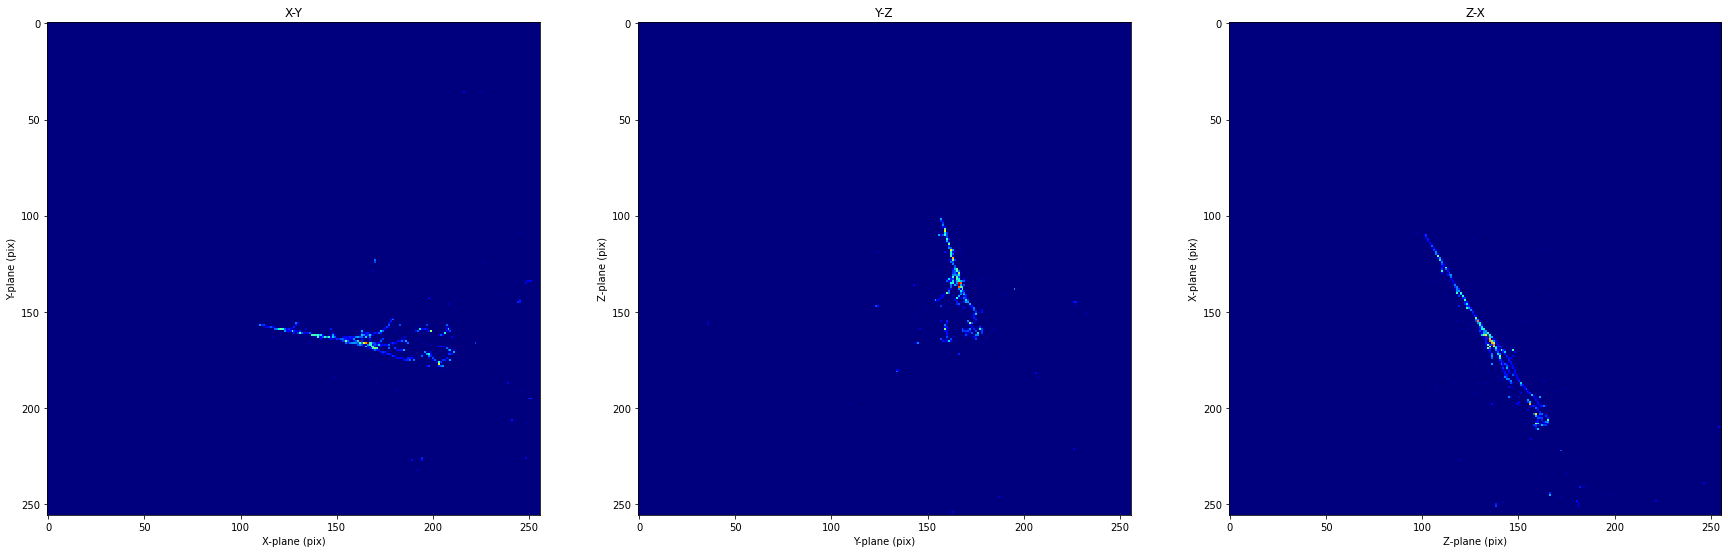

In [7]:
labels=["X-Y","Y-Z","Z-X"]
ilist= toimage(images[0])
fig = plt.figure(figsize=(30,10))

for index, image in enumerate(ilist):

    plt.subplot(1,3,index+1)
    #Show the image with imshow:
    plt.imshow(image, interpolation='none',cmap='jet')
    plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
    plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
    plt.title(labels[index])
fig.savefig("lar_planes.png")

---
### Truth information

Real data in a neutrino experiment does not come with labels, but since our dataset is simulated, we have the **truth level information** of the particles. We load the truth dataset here.

In [8]:
truth = np.load("LArTPC_truth_90k.npy")

We have eight truth arrays present in the dataset

- The particle ID (particle type ID as defined by the [particle data group](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf))
    - 11   : 'electron',
    - 22   : 'photon',
    - 13   : 'muon',
    - 211  : 'pion',
    - 2212 : 'proton'
- The total momentum (p) of the initial particle in MeV
- The x component (px) of momentum in MEV
- The y component (py) of momentum in MEV
- The x component (pz) of momentum in MEV
- The x position of the production of the particle in cm
- The y position of the production of the particle in cm
- The z position of the production of the particle in cm


In [9]:
p_id , p_ptot, p_px, p_py, p_pz, p_x, p_y, p_z= (truth[:,i] for i in range(truth.shape[1]))

In [10]:
truth.shape

(90000, 8)

In [11]:
    # electron print
print(truth[0][0])

11.0


# Project

For the project are required to perform an in depth investigation of the image dataset, and design **two** machine learning techniques from the dataset. The first tasks are **compulsary** where you are required explore the data and create an algorithm to identify/classify the particle in each event.  

## Task 0: Data exploration
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

## Task 1: Image classification
* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?

## Task 2: Choose from one (or several) of these
Pick an additional task from this set, or come up with your own study that is not listed here. You should follow a similar approach as to **Task 1** above, but without as much detail needed. Consider *Task0 and Task 1* to be with 70% and *Task 2* to be worth the remaining *30%*.

* Create a regression algorithm which predicts the particle momentum for electrons, either the total momentum, or the px, py and pz. Determine the quality of the regression trained on electrons on photons. Explain the performace.
* Create a regression algorithm which predicts the x, y and z position of protons
* Create an autoencoder (AE) to reduce noise in the detector images. Do injection tests of random noise with different intensities to check your results. Some code to generate noise can be found in the [Keras AE tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)
* Create a variable autoencoder (VAE) on the images for image generation of a paricular type. Try and make it conditional on momentum and position.
* _Etc._

To complete this project, you should:
* Perform **Task 0 and 1** and an additional task from **Task 2** (but not necessarily restricted to just these), label/number your studies, discuss the results, and compare their relative merits.
    * If you do any neat studies that don't result in a classification variable, _e.g._ image generation, that still very much counts!
* **Submit your Jupyter notebook** as a "report." See the comments below on documentation,
    
When doing each of your studies, you should try to follow the below steps (where it makes sense; rough weight in marking indicated in parentheses):

1. **Data exploration and preprocessing (10%):** Inspect the datasets; visualise the data in an appropriate way; study the composition of the dataset; perform any necessary preprocessing.
2. **Model selection (30%):** Choose a promising approach; construct the machine learning model; optimise the relevant hyperparameters; train your chosen model.
3. **Performance evaluation (20%):** Evaluate the model in a way that gauges its ability to generalise to unseen data; compare to other approaches; identify the best approach. 
4. **Discussion, style throughout (40%):** Discuss the reasoning or intuition behind your choices; the results you obtain through your studies; the relative merits of the methods you have developed, _etc._ Similarly, make sure that you write efficient code, document your work, clearly convey your results, and convince us that you have mastered the material.


That is, **you should submit, by Friday 3rd December 2020 at 4pm:**
* your report notebook via Turnitin.
    

For all task we're not looking for exceptional performace and high scores (although those are nice too), **we're mostly concerned with _best practices:_** If you are careful and deliberate in your work, and show us that you can use the tools introduced in the course so far, we're happy!

Training all of these models in sequence takes a very long time so **don't spend hours on training hundreds of epochs.** Be conservative on epoch numbers (30 is more than enough) and use appropiate techniques like EarlyStopping to speed things up.



### Documentation

Your reportnotebook should run without errors and give (mostly) reproducible results. It is important that **all** code is annotated and that you provide brief commentary **at each step** to explain your approach. Explain *why* you chose a given approach and *discuss* the results. You can also include any failed approaches if you provide reasonable explanation; we care more about you making an effort and showing that you understand the core concepts.

This is not in the form of a written report so do not provide pages of background material, but do try to clearly present your work so that the markers can easily follow your reasoning and can reproduce each of the steps through your analysis. Aim to convince us that you have understood the material covered in the course.

To add commentary above (or below) a code snippet create a new cell and add your text in "Markdown" format. Do not add any substantial commentary as a code comment in the same cell as the code. To change the new cell into markdown select from the drop down menu on the bar above the main window (the default is code)

---
# Lets get started

We need to define a few more things as we get started, but lets first split the data into 50K for training, and 40K reserved for testing

In [12]:
from sklearn.model_selection import train_test_split 

In [13]:
x_train, x_test, truth_train, truth_test = train_test_split(images,truth,train_size=50000,random_state=11)

## Special notes for traning on sparse matrices

Since we are using sparce matrices instead of dense ones, we need to tweak the way we **train**, **evaluate**, and **predict** from our model. This is because each of these steps requires the data to be **dense**, and we will run into the previous mentioned memory issues very quickly.


The solution for this is by using a **data generator** which will only load the dense data in batches. I give the function below.

The `nn_batch_generator` takes in the input data `X_data`, labels `y_data` and `batch_size` and creates a mini dense batch based on the `batch_size`. The `yield` keyword is a type of `return` function but which allows the method to keep running. Since we usually train on small batches (e.g. `32` events per batch) the data should be able to fit in memory.

In [14]:
def nn_batch_generator(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch),y_batch
        if (counter > number_of_batches):
            counter=0


Below is an example of passing the generator itself into the fit method. Because the generator would run forever, we need to use the `steps_per_epoch` parameter to tell the training when to stop (i.e, it reached the end of the data). We therefore set `steps_per_epoch` to the number of training entries divided by the batch size. In this case I set 5000 entries aside for the validation set.

**Note these are just examples taken from my own notebooks so don't expect to just work out the box for you**
```
validation_slice=5000
batch_size=32
history_cnn = cnn.fit(nn_batch_generator(x_train[:-validation_slice],y_labels[:-validation_slice],batch_size=batch_size),
                      epochs=20,
                      steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-valdation_slice:], y_labels[-validation_slice:]))

```


Similarly predict and evaluate methods take generators with the `steps` parameter to end the evalutation

```
cnn.predict(nn_batch_generator(x_train[-5000:], y_train_labels[-5000:],batch_size=50),steps=5000/50)
```

```
cnn.evaluate(nn_batch_generator(x_test, y_train_labels,batch_size=50),steps=len(cc)/50)
```



### Finally a note on training 
We are training on a huge amount of data in practice, so expect the training to be **very very slow!!!**. I was clocking a single CNN training with 30 epochs at around 90 minutes on my CPU. I would recommend trying to run hyperparemer tests at night while you are sleeping, or alternatively if you must run from the CP labs, run them on a smaller set of 5K samples, with 500 validation. However, note that although the smaller trainings may allow you to explore different parameters more quickly, it won't nessesarily translate to the big dataset as easily, so at some point you will want to launch some big trainings on networks you find promissing. Remember to document your process as much as possible!

It is absolutely **essential** that you use callbacks to reduce the training time
* Use ReduceLROnPlateau if the training has not improved after a number of epochs
* Use EarlyStopping to exit the training if it has not improved after a number of epochs (should be a larger number than what is used on ReduceLROnPlateau)
* Use ModelCheckpoint to save the *best* model to a unique file. You can then use keras `load_model` (already imported for you) to load the saved model and not have to retrain if you close the notebook. Alternatively you can save any model with `save_model`.

In [15]:
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau



**If the project description is unclear, or if you experience any technical issues, please do let me know as quickly as possible. I can send around clarifications if I think it would be to the benefit of the entire class.**

---

**Your code below**

---

# Task 0: Data Exploration
Pulling from above:
* Explore a few images from each particle type, trying to identify how the particles are different between categories. Explore how the images change with different initial momenta. Remember that each event has three 2D images which should be veiwed simultaneously to get the full picture.
* Explore the truth information to get an idea of the dataset composition.

Also, for ease of use:
The particle ID (particle type ID as defined by the particle data group)

    11 : 'electron',
    22 : 'photon',
    13 : 'muon',
    211 : 'pion',
    2212 : 'proton'
    
## - Drawing arrangement of Particles

In [16]:
# Collect first image of each particle

    #Particle IDs
particles = [11.0,22.0,13.0,211.0,2212.0]
particle_names = ['electron', 'photon', 'muon', 'pion', 'proton']
particle_index = []
rparticle_index = []
    # Collect first and last individual indexes of each particle type for study
    
    # take the IDs of each item, as that's all we care about here.
part_ids = [item[0] for item in truth]
for i in range(len(particles)):
        # appends index of first sample of each particle to a list
    particle_index.append(part_ids.index(particles[i]))
        # appends index of last sample of each particle to a list
    rparticle_index.append(len(part_ids) - part_ids[::-1].index(particles[i]) - 1)    

    # Just to demonstrate validity of this list, can be commented out
print(particle_index)
print(rparticle_index)
#for j in range(len(particles)):
#    print(truth[particle_index[j]][0])
#    print(truth[rparticle_index[j]][0])



[0, 10000, 20000, 30000, 40000]
[57999, 65999, 73999, 81999, 89999]


Seeing the last particle and first particle for each type is useful, as it shows that the particles aren't entirely separate in the truth array, but they start at set values and end at set values.


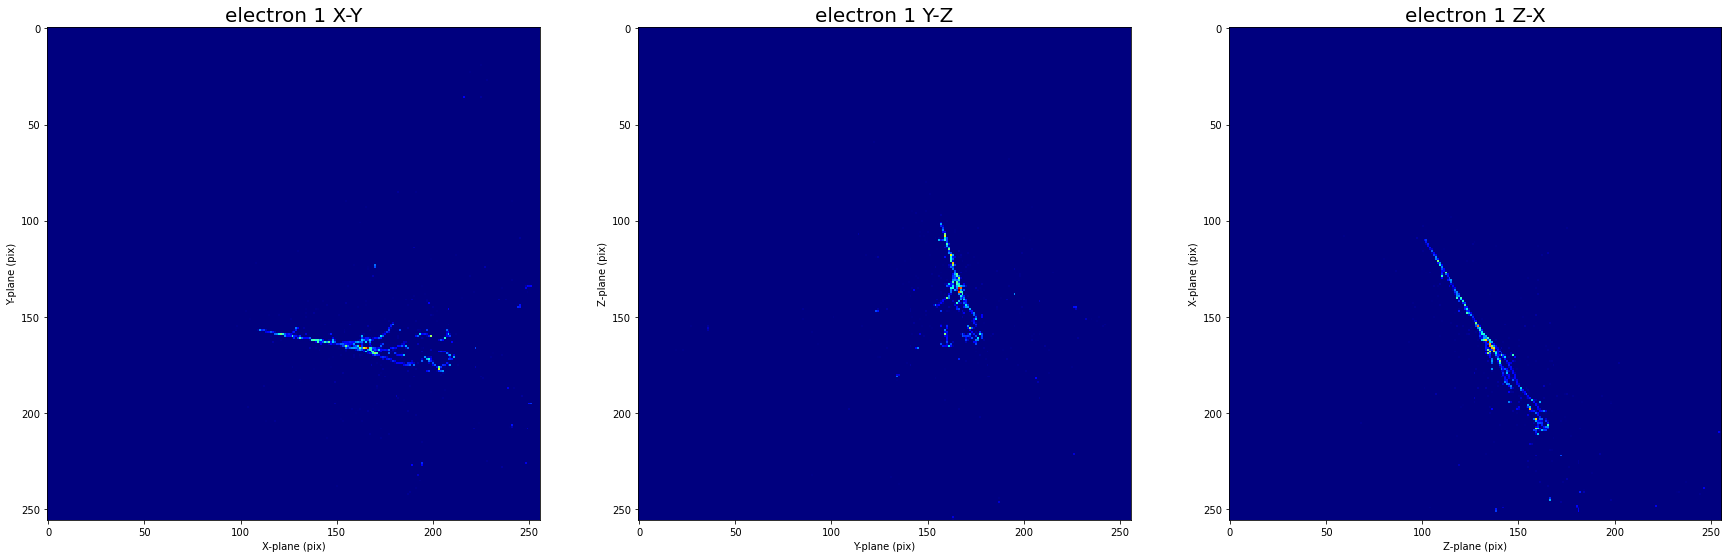

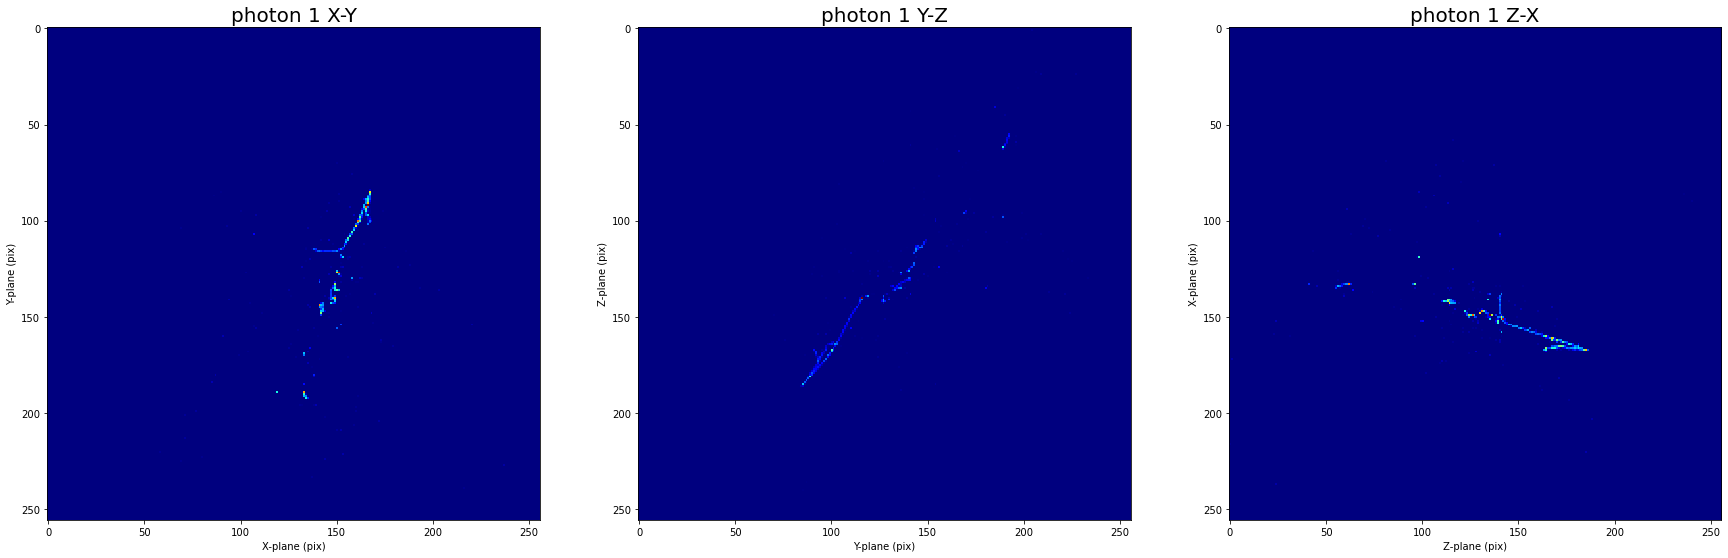

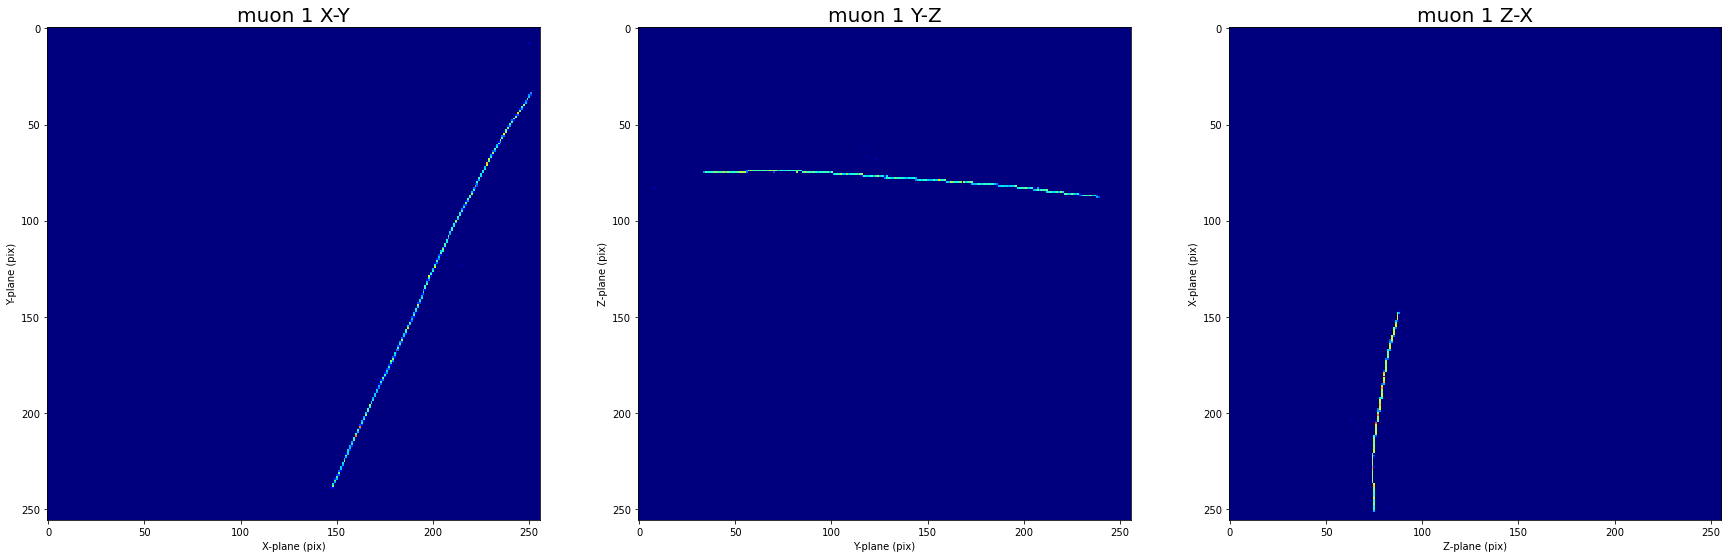

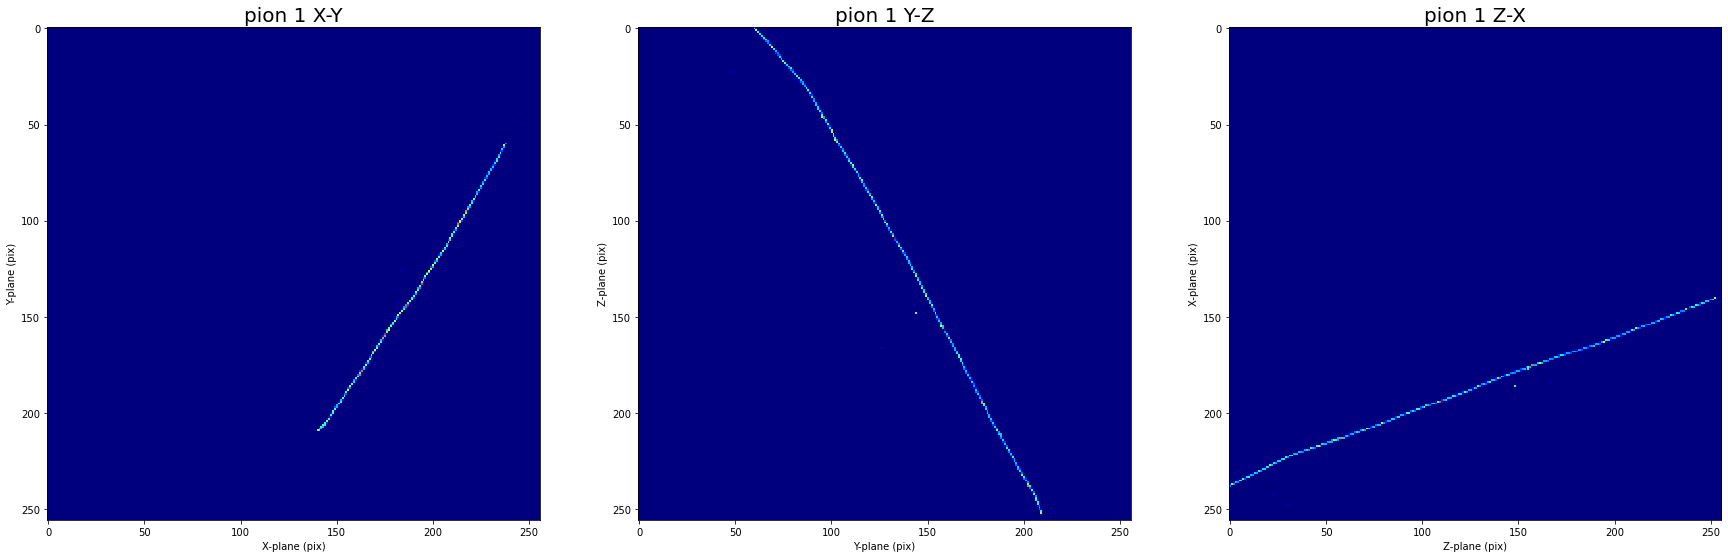

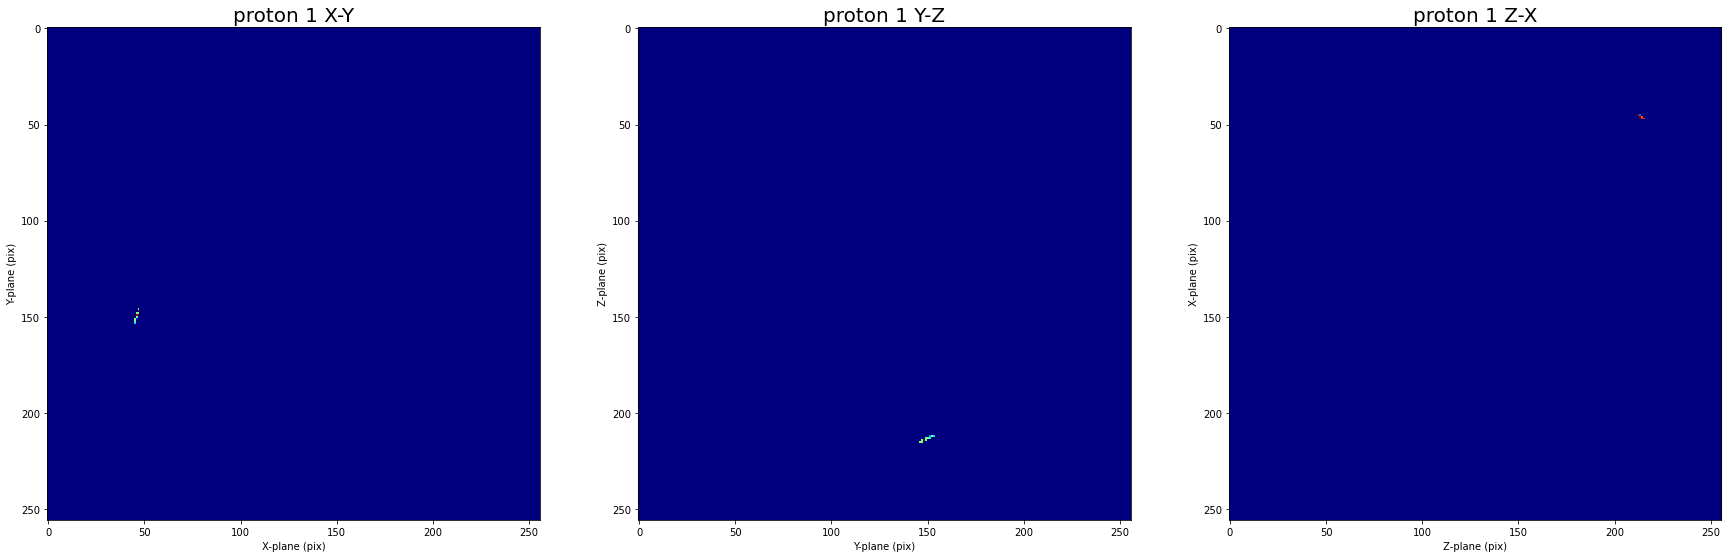

In [17]:
# Show images of first particles, using code from earlier with minor tweaks

for k in range(len(particles)):
    labels=["X-Y","Y-Z","Z-X"]
    ilist= toimage(images[particle_index[k]])
    jlist= toimage(images[rparticle_index[k]])
    fig = plt.figure(figsize=(30,10))

    for index, image in enumerate(ilist):

        plt.subplot(1,3,index+1)
        #Show the image with imshow:
        plt.imshow(image, interpolation='none',cmap='jet')
        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
        plt.title(particle_names[k] + " 1 " + str(labels[index]), fontsize = 20)

plt.show()


In [18]:

## Show images of second set of particles. This isn't the most efficiency way to display the particles
## but it allows us an easy method to quickly see different properties of each across different examples.
#
#for k in range(len(particles)):
#    labels=["X-Y","Y-Z","Z-X"]
#    jlist= toimage(images[rparticle_index[k]])
#    fig = plt.figure(figsize=(30,10))
#
#    for index, image in enumerate(jlist):
#
#        plt.subplot(1,3,index+1)
#        #Show the image with imshow:
#        plt.imshow(image, interpolation='none',cmap='jet')
#        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
#        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
#        plt.title(particle_names[k] + " 2 " + str(labels[index]), fontsize = 20)
#        
#plt.show()

The cell above is not necessary to be run anymore, as a better investigation is just below. But it was useful for initial examination so I'm leaving it in.

## - Initial Momenta/ Particle History Plotting

Here we will take each particle at specific total momenta and compare the images produced:
* The maximum momentum particle
* The median momentum particle
* The minimum momentum particle
We will then plot each of these cases and print their MeV values, then analyse them.

electron
Max (Index, P): (4155, 799.97 MeV) 
Min (Index, P): (8193, 35.55 MeV) 
Med (Index, P): (3812, 411.23 MeV)


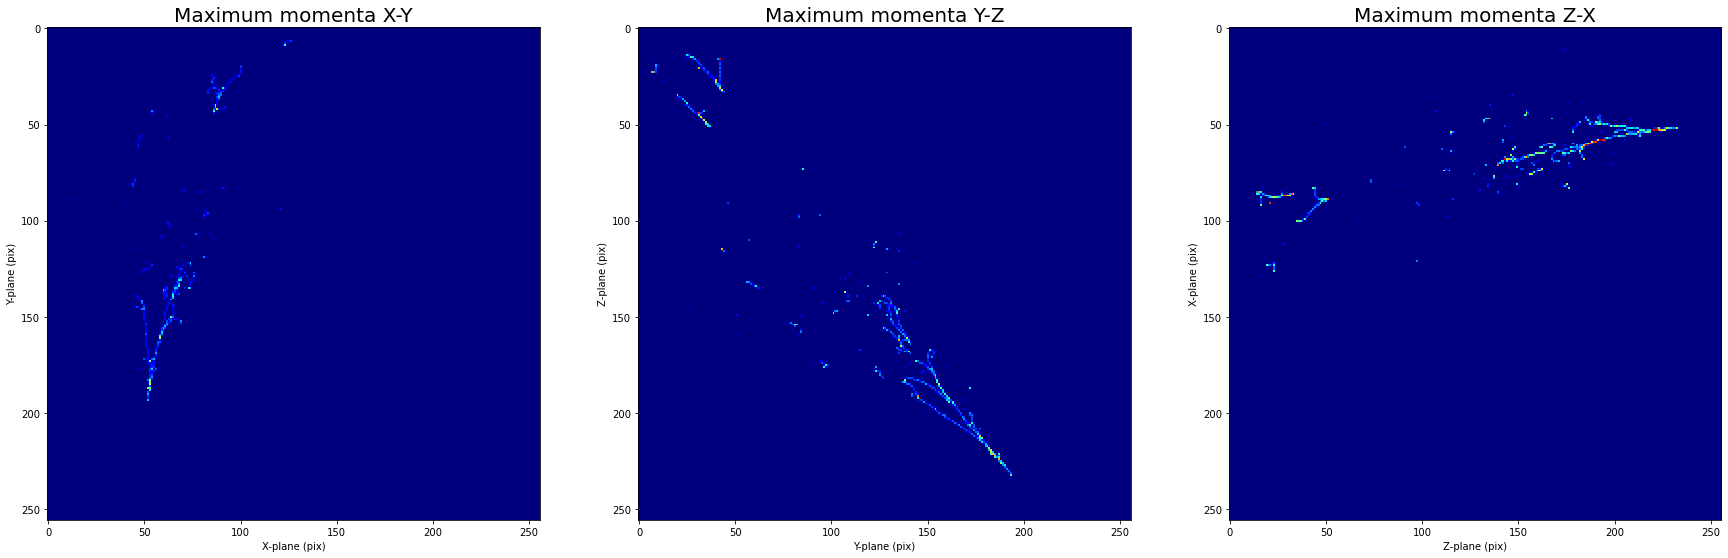

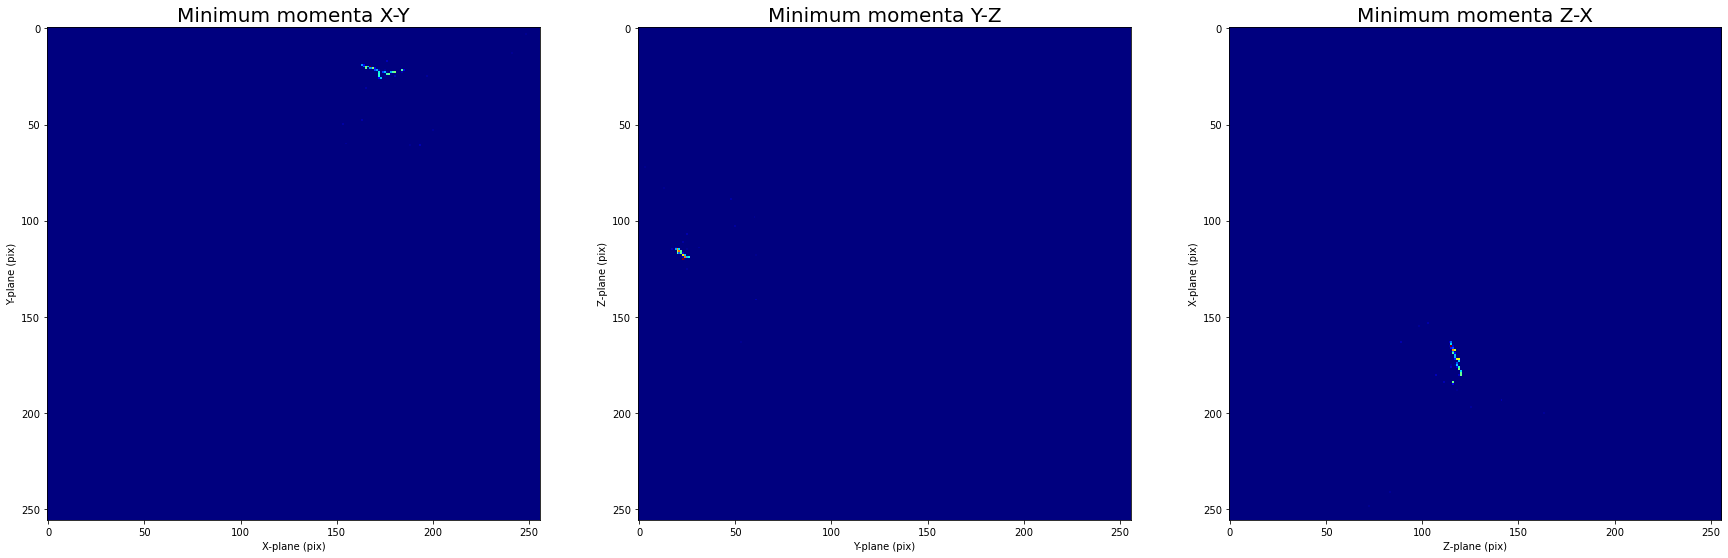

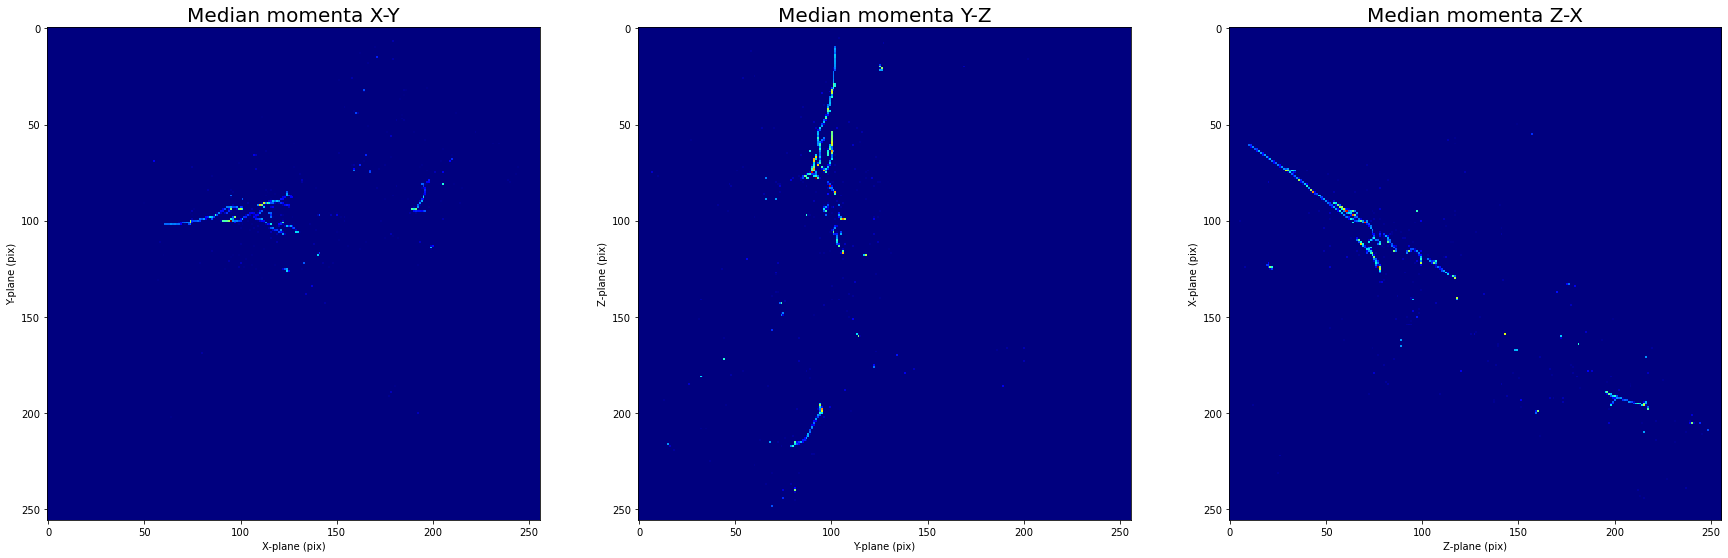

photon
Max (Index, P): (18528, 799.95 MeV) 
Min (Index, P): (13491, 35.05 MeV) 
Med (Index, P): (15975, 424.26 MeV)


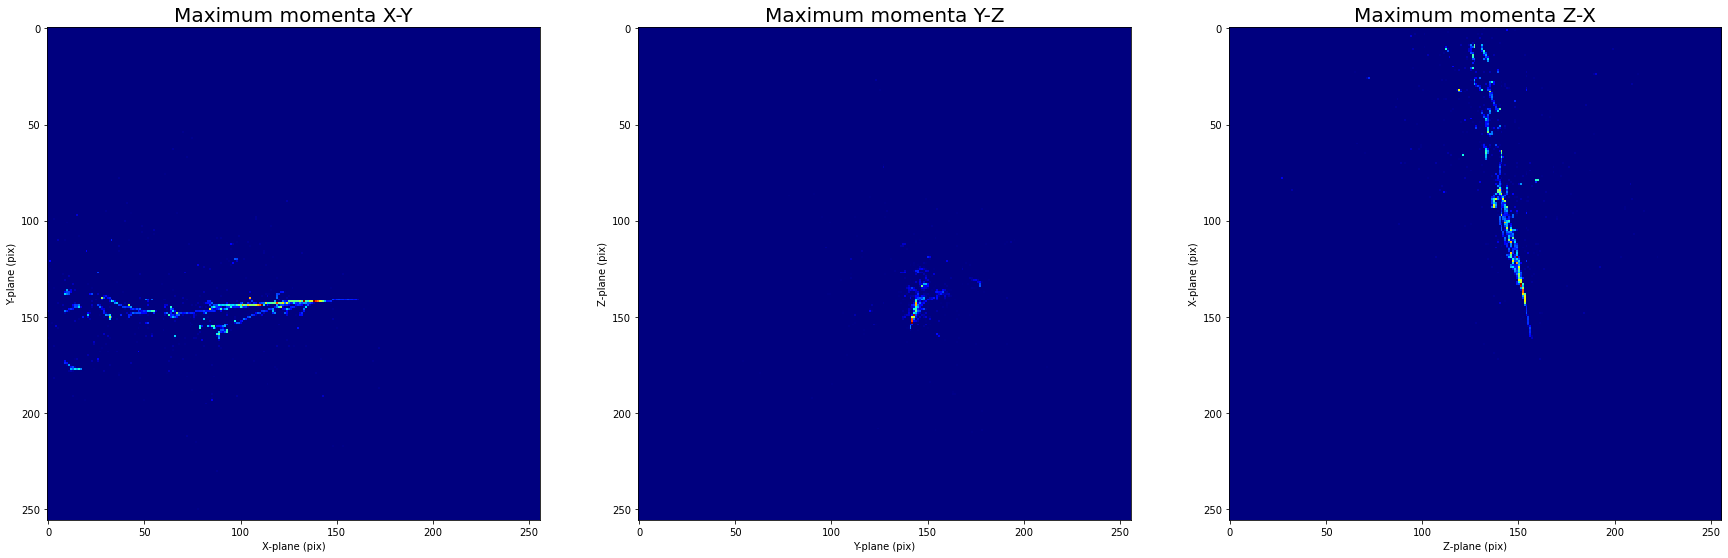

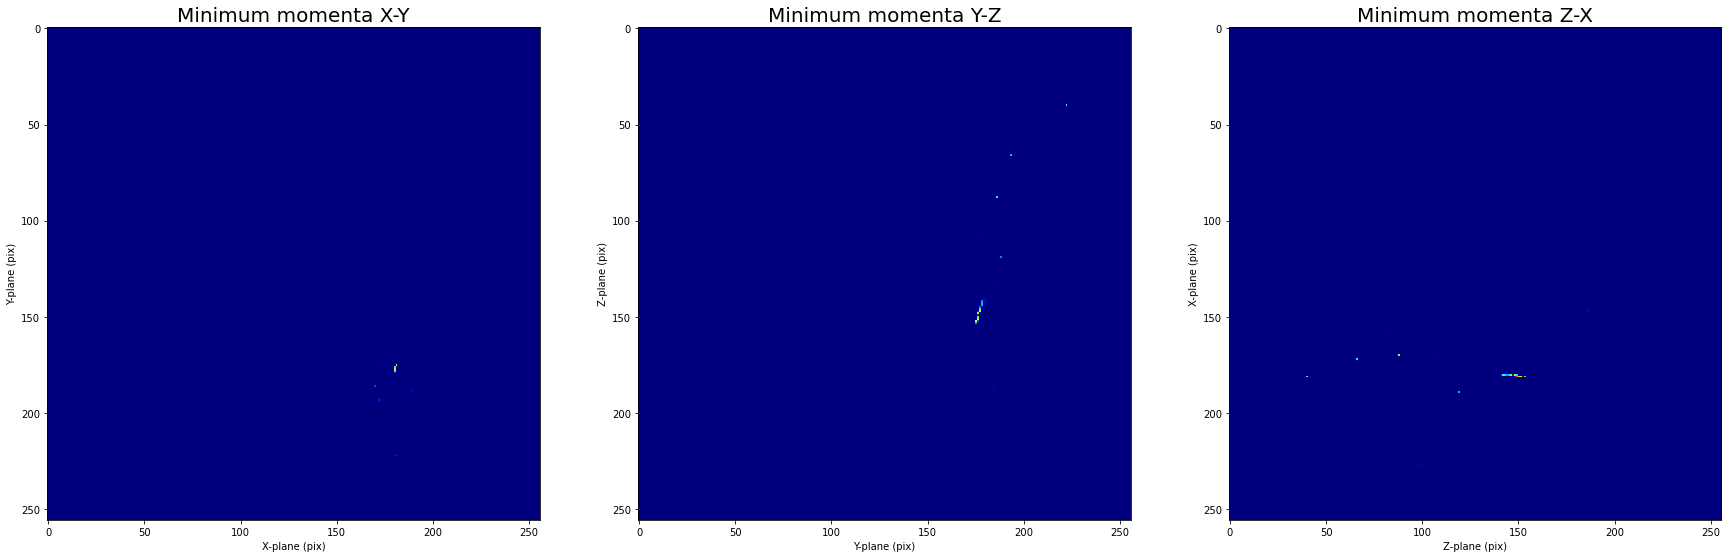

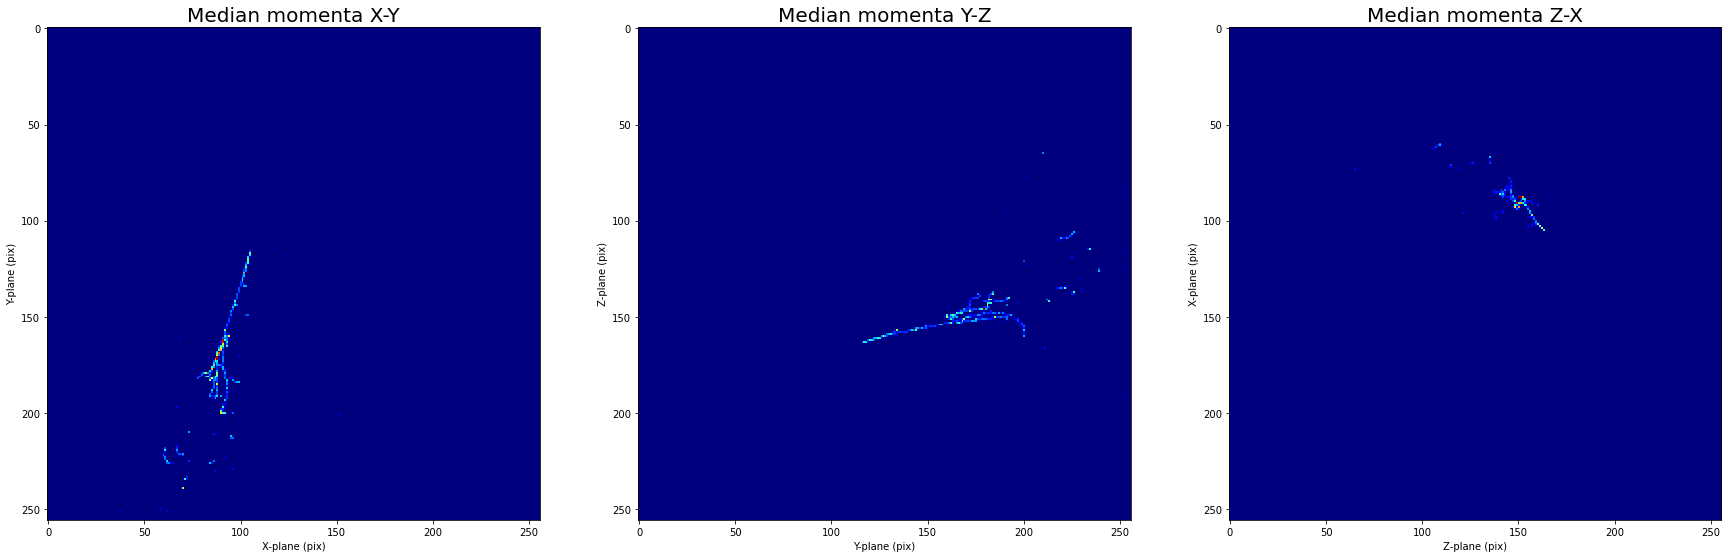

muon
Max (Index, P): (70095, 799.91 MeV) 
Min (Index, P): (73068, 90.02 MeV) 
Med (Index, P): (25337, 446.67 MeV)


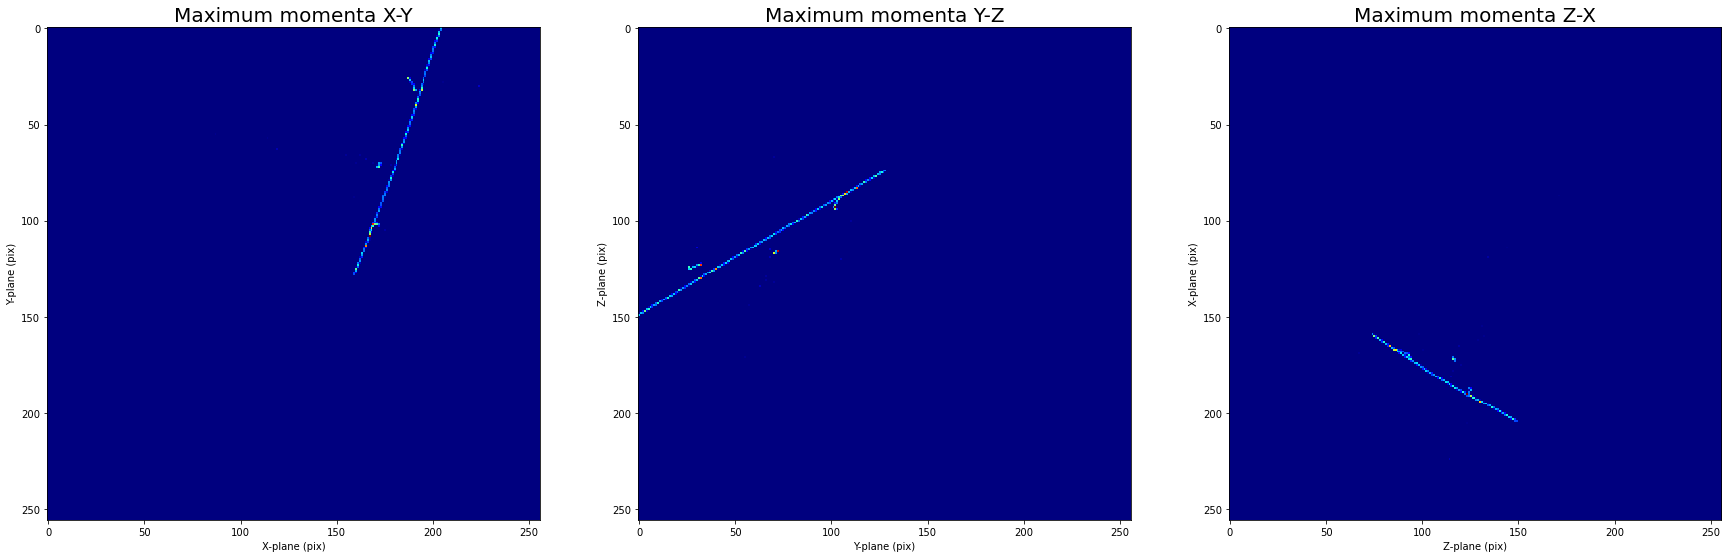

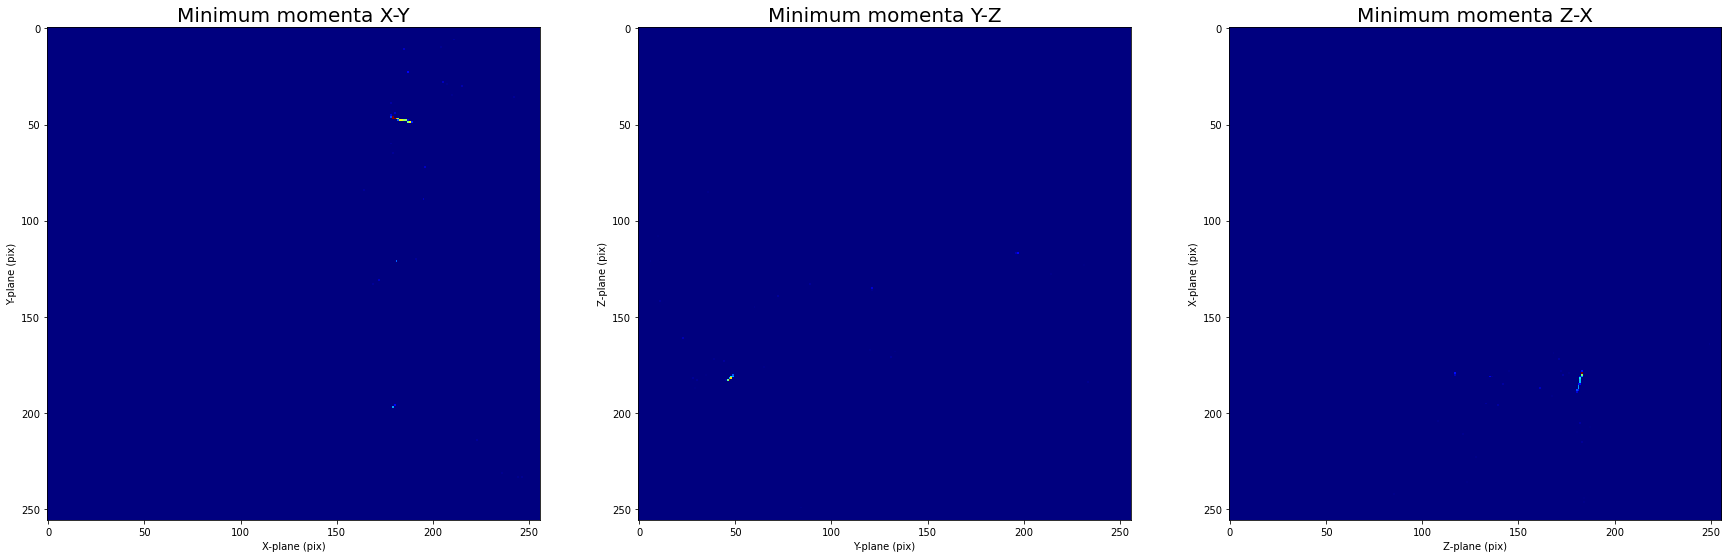

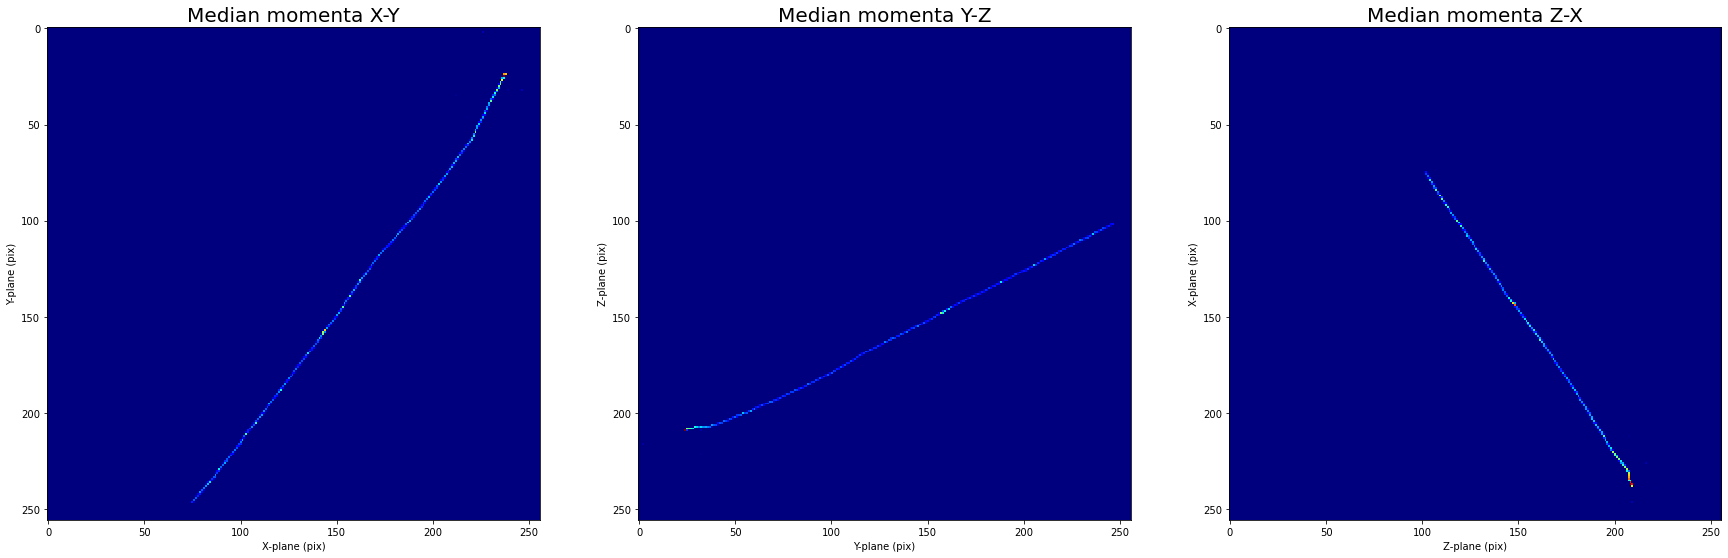

pion
Max (Index, P): (74627, 800.00 MeV) 
Min (Index, P): (31201, 105.05 MeV) 
Med (Index, P): (31756, 454.99 MeV)


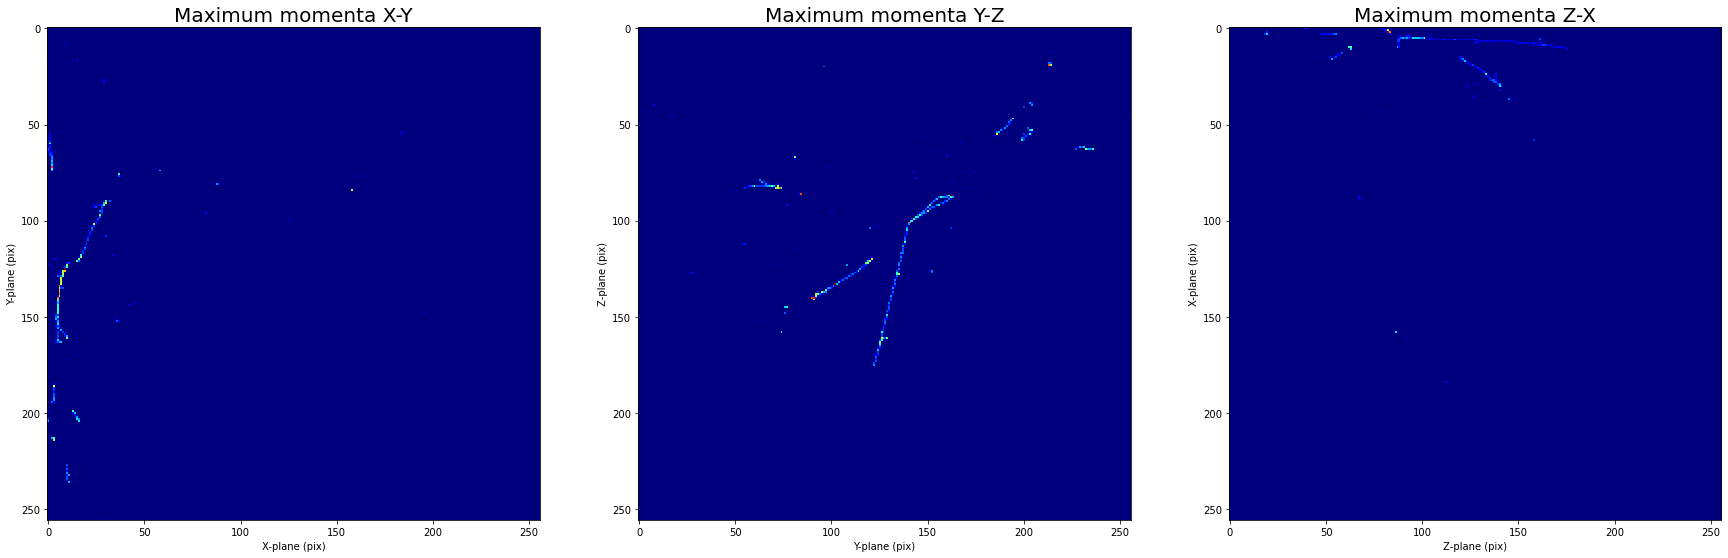

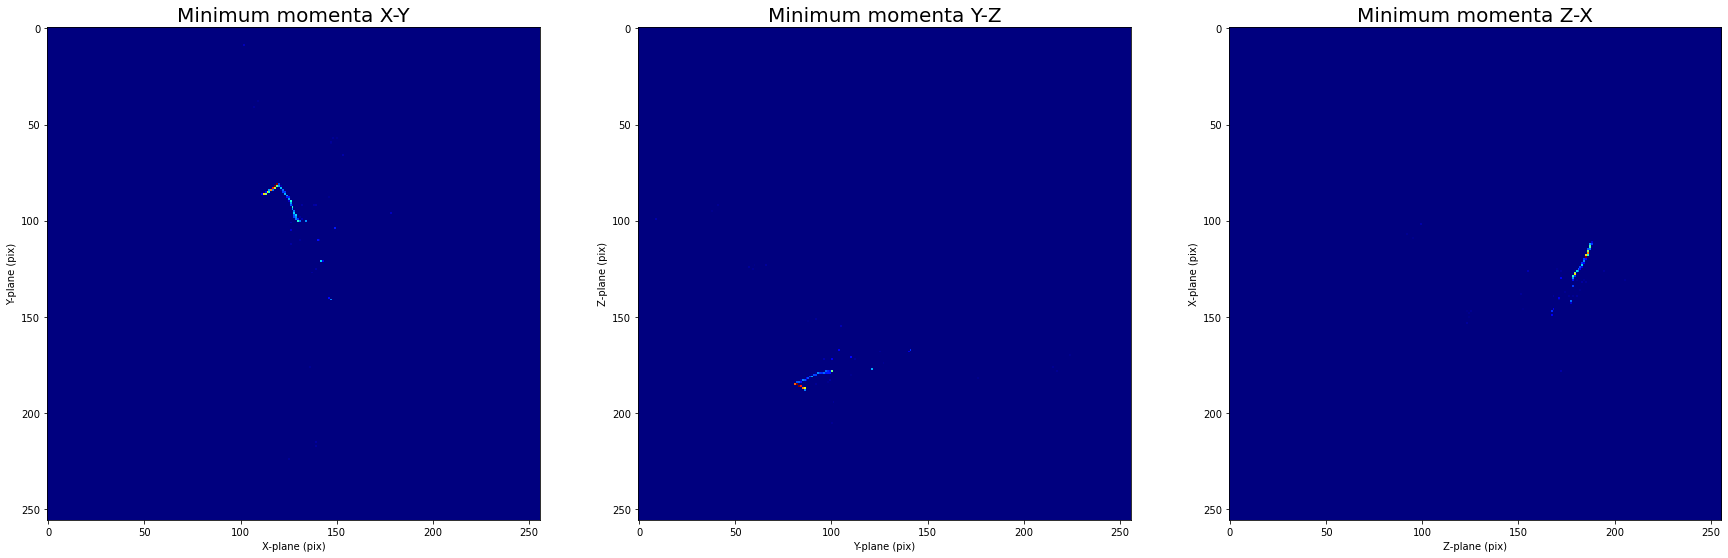

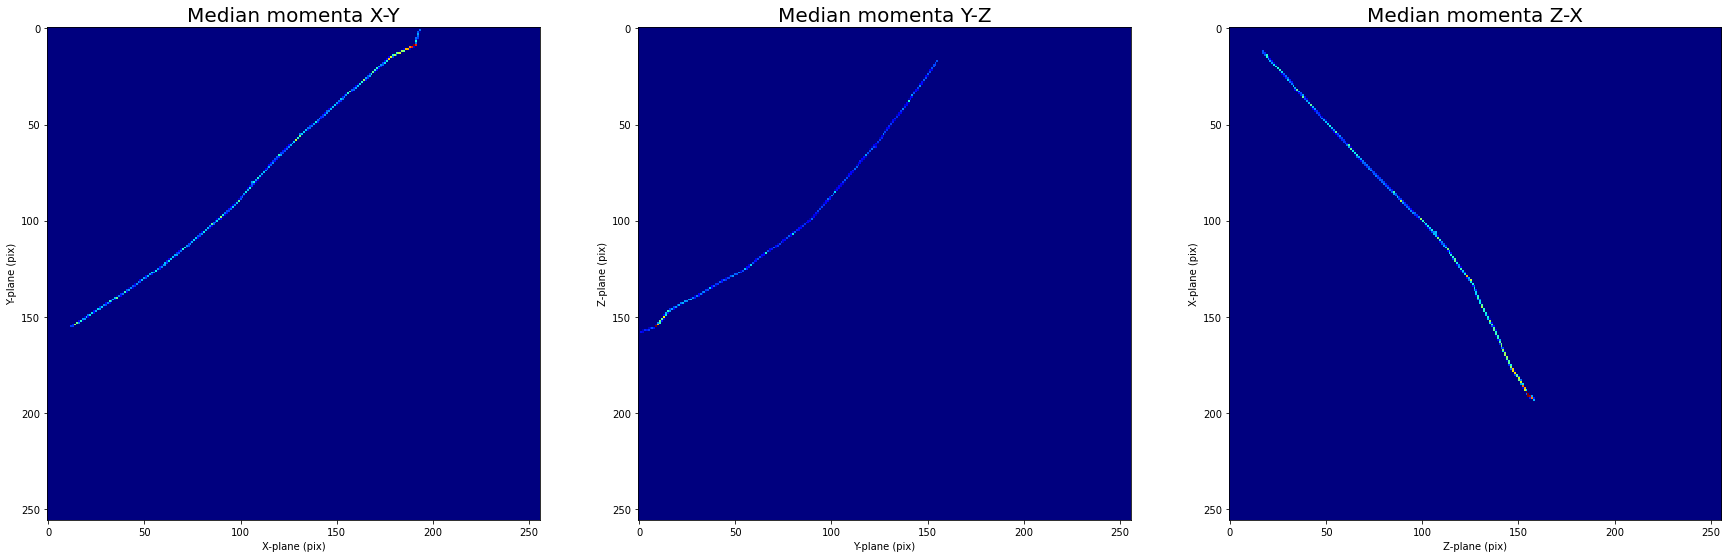

proton
Max (Index, P): (46320, 799.91 MeV) 
Min (Index, P): (42652, 275.57 MeV) 
Med (Index, P): (41888, 614.27 MeV)


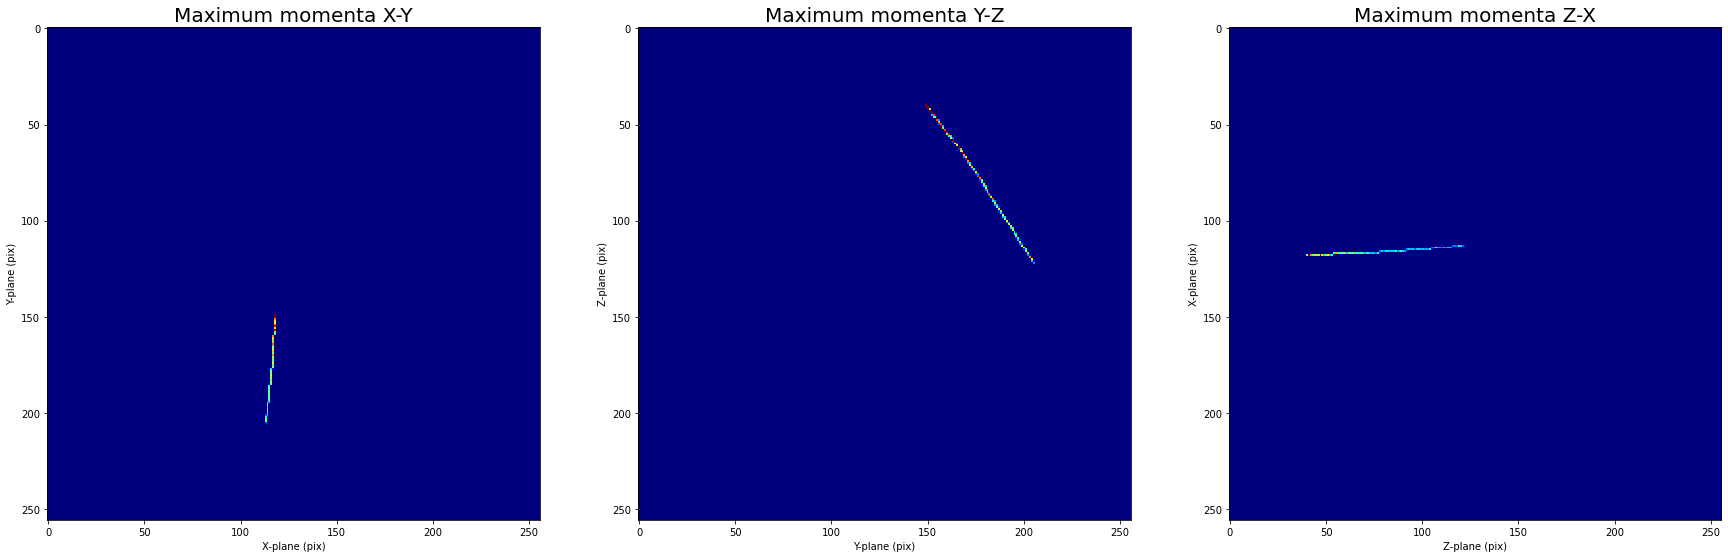

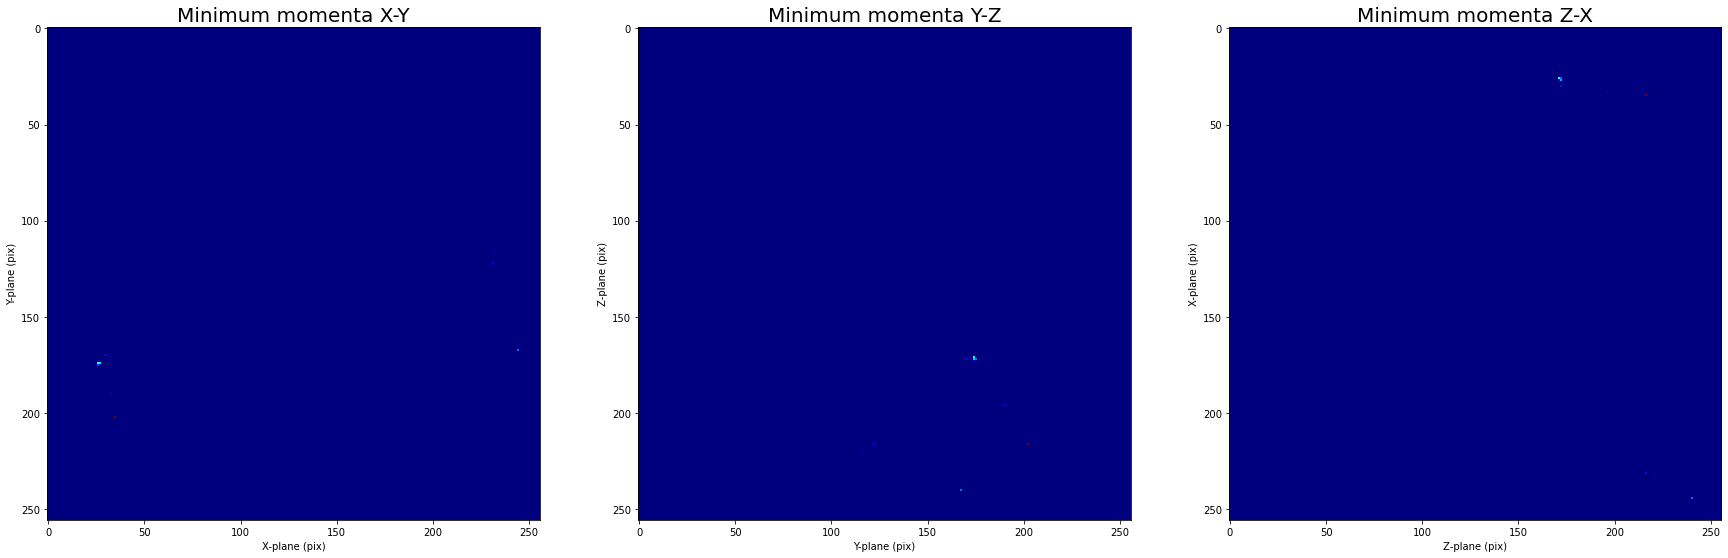

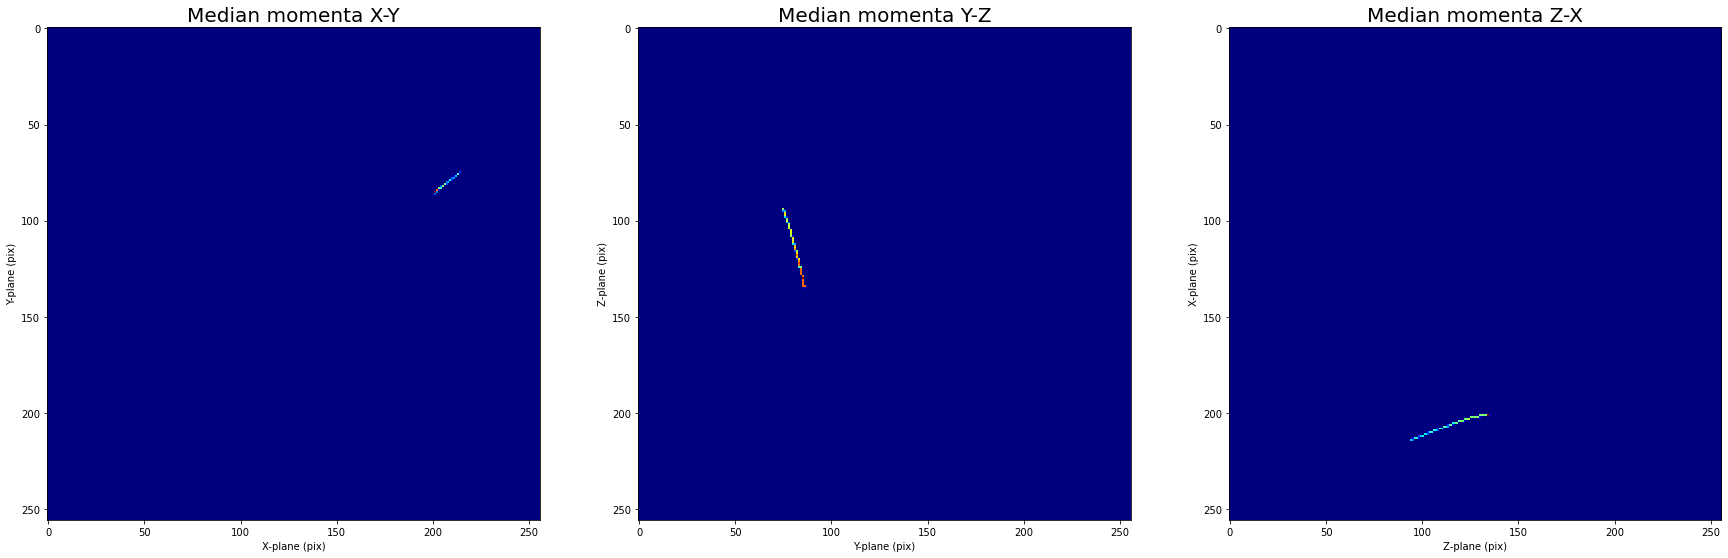

In [19]:
# Changes in initial momenta, and they're effect on the particles.
# Take 3 examples from each particle at differing momenta 
# (find highest momenta, lowest and then a centre value) and plot with each other.
# will be considering total initial momenta (truth[0][1])

for l in range(len(particles)):
        # for readability 
    print(particle_names[l])
        # take index list of one particle type (so list containing all electron indexes, then proton indexes, etc)
    e_ind_list = [i for i in range(len(part_ids)) if part_ids[i] == particles[l]]
        # collect their momenta in a list
    e_mom_list = [item[1] for item in truth[e_ind_list]]
        # find the maximum/minimum and approximate median momenta index
    e_max_val = np.argmax(e_mom_list)
    e_min_val = np.argmin(e_mom_list)
    e_med_val = np.argsort(e_mom_list)[len(e_mom_list)//2]

        # To return initial index, you must take the indices list of the max/min/med value.
    print("Max (Index, P): ({}, {:.2f} MeV) \nMin (Index, P): ({}, {:.2f} MeV) \nMed (Index, P): ({}, {:.2f} MeV)".format(e_ind_list[e_max_val], e_mom_list[e_max_val], e_ind_list[e_min_val], e_mom_list[e_min_val], e_ind_list[e_med_val], e_mom_list[e_med_val]))
    # Plot images for min, median and max. 
    indexes = [ e_ind_list[e_max_val],e_ind_list[e_min_val], e_ind_list[e_med_val]]
    titles = ['Maximum', 'Minimum', 'Median']
    for q in range(len(indexes)):    
        ilist= toimage(images[indexes[q]])
        fig = plt.figure(figsize=(30,10))

        for index, image in enumerate(ilist):

            plt.subplot(1,3,index+1)
            #Show the image with imshow:
            plt.imshow(image, interpolation='none',cmap='jet')
            plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
            plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
            plt.title(titles[q] + " momenta " + str(labels[index]), fontsize = 20)

    plt.show()

Here is a basic code breakdown of how the above code works for a particular particle (the median proton in this case).
This was for me to better understand the method when I needed to come back to it, as well as a useful tool to show exactly what the above code does, as it can be a bit confusing.

In [20]:
# Demonstration of how the above method works broken down for protons, as its easier to understand on a single particle

    # Particle type : proton -> 2212.0
print("Particle ID: {:.0f}".format(particles[4]))
    # Collect list that contains all truth indexes that contain proton data
pro_list = [i for i in range(len(part_ids)) if part_ids[i] == particles[4]]
    # Collect the momenta of all protons
pro_mom_list = [item[1] for item in truth[pro_list]]
    # Find median
pro_med_val = np.argsort(pro_mom_list)[len(pro_mom_list)//2]
    # Index for this value within truth array
print("Truth Index for Median: {}".format(pro_list[pro_med_val]))
print("Median momentum for proton: {:.2f} MeV".format(pro_mom_list[pro_med_val]))
print("Median value index within pro_list: {}".format(pro_med_val))
print("Median value index within full list: {}".format(pro_list[pro_med_val]))
    # To see it in the original array
print(truth[pro_list[pro_med_val]])

del pro_list
del pro_mom_list
del pro_med_val


Particle ID: 2212
Truth Index for Median: 41888
Median momentum for proton: 614.27 MeV
Median value index within pro_list: 1888
Median value index within full list: 41888
[2212.          614.26954396 -194.92359712  165.585873    558.49195957
  107.297929     37.770041     46.943595  ]


Next, we will look at histograms for each particle based on their specific values for momentum (total, x, y, z) and position (x, y, z). Here is the code that will do this for us.

In [21]:
# Plotting histograms of all the data for each particle type
# Create a histogram of the missed particle's momentum, x position, etc against the hits
def hist(data, Type, particles):
    
    # Create lists for each particle
    hist_list = []
    for j in range(len(particles)):
        hist_list.append([])
    particle_names = ['electron', 'photon', 'muon', 'pion', 'proton']
    data_type = ["ID","Total Momentum","X component of Momentum","Y component of Momentum","Z component of Momentum","X position of particle production","Y position of particle production","Z position of particle production"]
    xlabel = ["ID", "MeV", "MeV", "MeV", "MeV", "cm", "cm", "cm"]

    # Taking the particle ids
    part_id = [item[0] for item in data]
    
    # Looping across all the data
    for i in range(len(data)):
        
        # Append the important data value to the relevant particle list
        for j in range(len(particles)):
            # if data ID same as particle id, append and break
            if data[i][0] == particles[j]:
                hist_list[j].append(data[i][Type])
                break;
            else:
                continue;            
    # Plot histograms
    plt.figure(figsize=(10,10))
    for j in range(len(particles)):
        plt.hist(hist_list[j], label = str(particle_names[j]), histtype=u'step', linewidth = 4)
        
    plt.title("Histogram of " + str(data_type[Type]) + " for all particle types")
    plt.xlabel(str(xlabel[Type]))
    plt.legend()
    plt.savefig(str(data_type[Type]) + '_Full_Histogram.pdf')
    plt.show()

## Histogram plotting

Using the aforementioned function to plot our values:

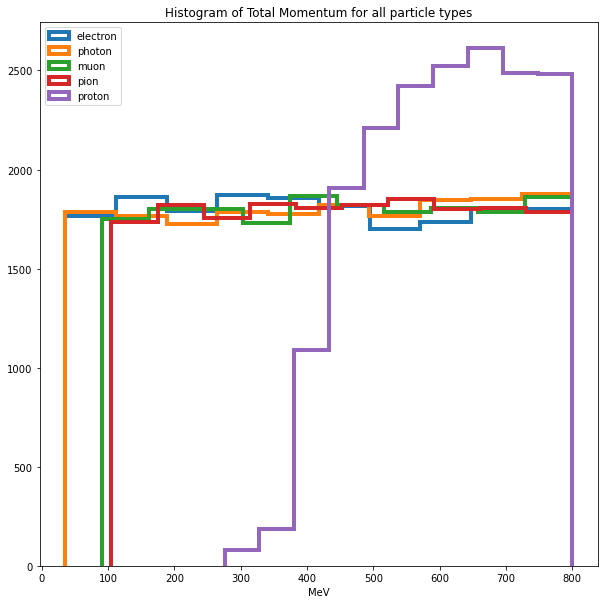

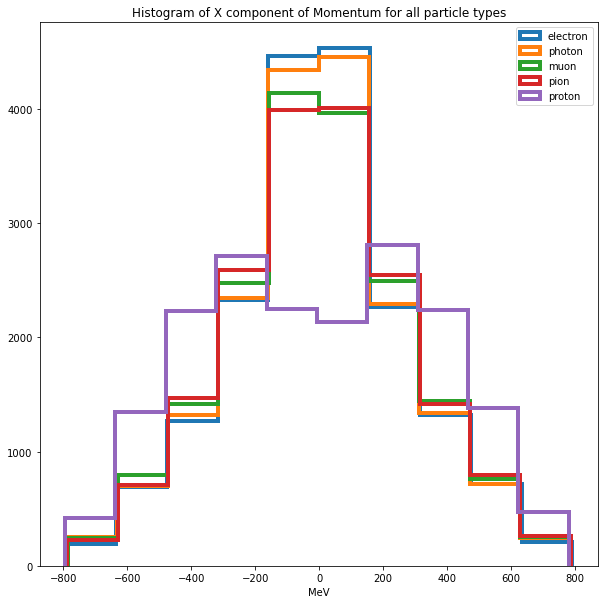

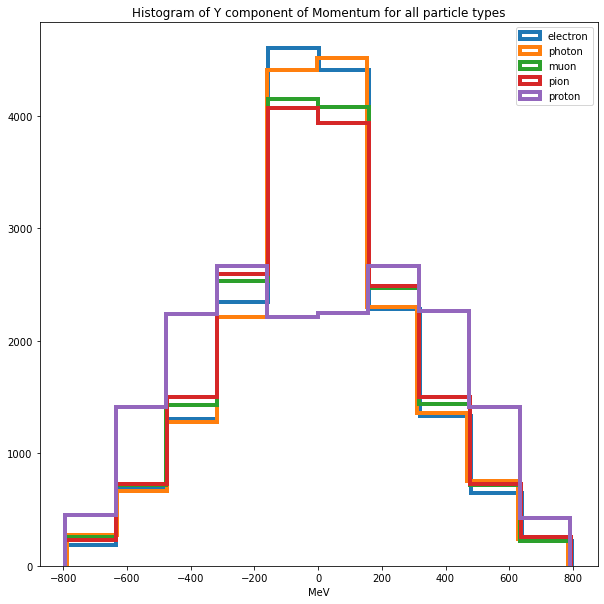

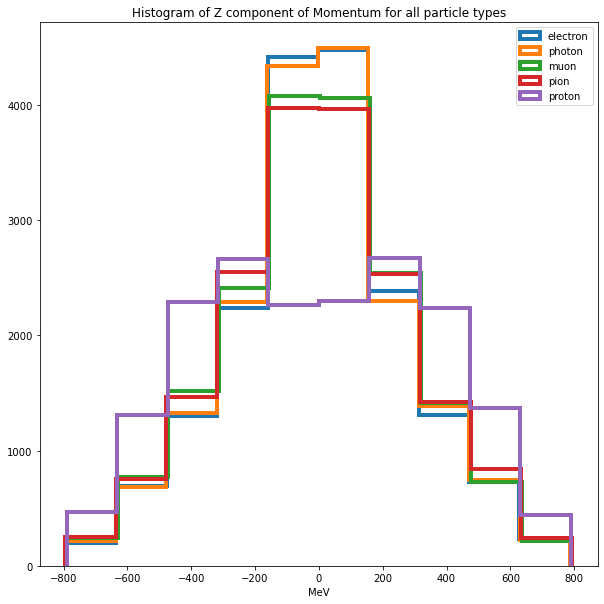

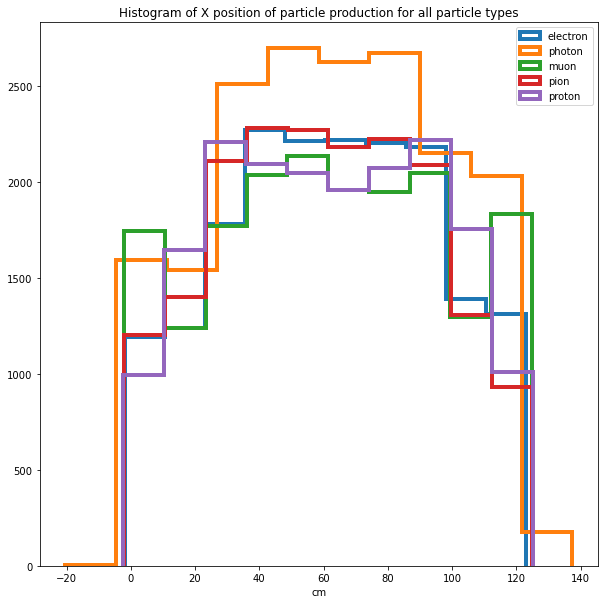

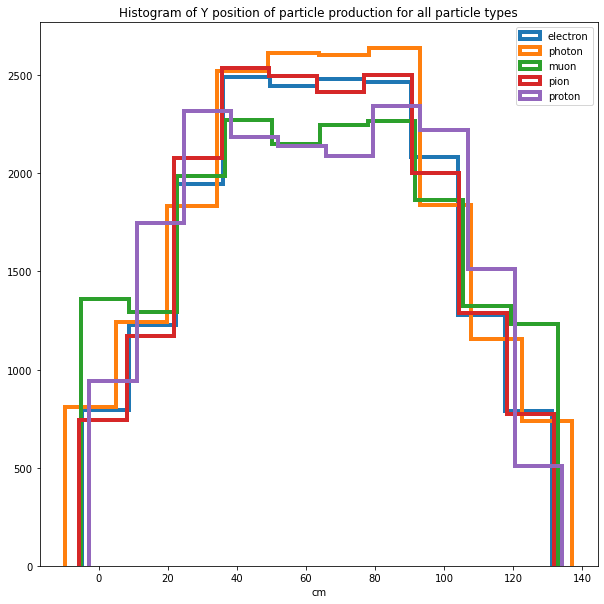

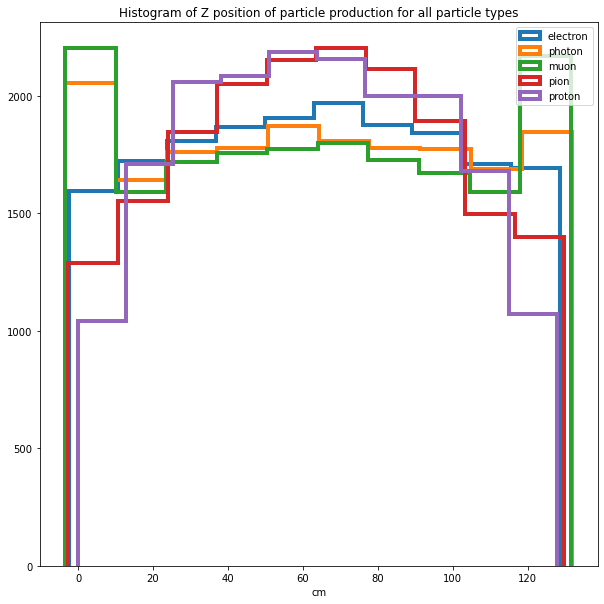

In [22]:
# Now lets run this for all values
for i in range(len(truth[0])-1):
    hist(truth, i+1, particles)

## Discussion of the above results.

### The particle image plotting

* Electron

The electron in all cases but the minima produces a jet-like stream of paths that resembles an 'electron shower'. With increasing momenta the paths become longer and spread out more over their duration throughout the detector.

**Total Momenta breakdown**
*Max: 799.97 MeV
Med: 411.23 MeV
Min: 35.55 MeV*

* Photon

Similar to the electron, the photon in all cases (but the minimum) produces a 'jet-like' stream from its initial position that closely resembles an electron shower in its result. The increasing initial momenta appears to just increase the length of said shower. In comparison with the electron (at least for these results), the jet does not 'spread out' as much as the electron when the initial momentum is increased.

**Total Momenta breakdown**
*Max: 799.95 MeV
Med: 424.26 MeV
Min: 35.05 MeV*

* Muon

For low energy, similar to the proton, the muon travels along a very short path before decaying away, for a median momenta the path is a long, relatively straight line through the medium as can be seen once again in both the momenta analysis and the initial analysis. For high energy, the path is shortened compared to the median but still retains a straight, long path through the detector. There are small 'forks' coming off the path which could be the muon energy being used to produce particles that aren't shown in the results.

**Total Momenta breakdown**
*Max: 799.91 MeV
Med: 446.67 MeV
Min: 90.02 MeV*

* Pion

For low momenta, appears to exist on very short lifetimes and change direction rather sporadically, then decay away. For median momenta a long path is formed, as seen in the momentum image and in the initial image. This shows that on average the particle will travel a long distance before decaying (moreso then the proton). For high momenta, the result looks scattered and messy, would make sense that the particle in this case is breaking up into different particles, or the pion detection is itself a result of a higher energy decay.

**Total Momenta breakdown**
*Max: 800.00 MeV
Med: 454.99 MeV
Min: 105.05 MeV*

* Proton

Straight and short paths in all three cases, increasing in length with more initial momenta. The shortest paths compared to all the other particles regardless of momenta (excluding the minimum case).

**Total Momenta breakdown**
*Max: 799.91 MeV
Med: 614.27 MeV
Min: 275.57 MeV*

### The histogram plotting

* Total Momenta

All of our particles (bar the proton) trend towards a flat density curve and stay there across the entire histogram. This demonstrates that our particles evenly range across the values of total momenta, and there isn't a particular particle dependence for lower or higher momenta beyond their initial low momenta values.

This isn't true for the proton, which breaks this trend by having a minimum momenta at around 300MeV and in general having a significantly larger distribution of its particles in the higher momenta space when compared to the rest. This is understandable considering its high momentum floor (due to its larger mass), and this trend of generally having high momenta is seen throughout not just the total, but the X, Y, and Z momenta plots. It appears that if momenta higher than 800MeV were available in the data, the protons would most definitely been distributed further throughout higher momenta.

* X, Y, Z Momenta

All of our particles (excluding the protons) tended to have an almost 'gaussian-like' peak at 0MeV for each component in the momenta. This is understandable considering that the total momenta is the addition of 3 components, all of which at any given time are not required to be large individually to give a larger total momentum (X momentum may be zero, but if Y and Z momentum are large, total momentum is large). The proton bucks this trend, in the same manner as was described in the Total Momenta.

* X, Y, Z Position

While the X and Y position histograms show what would be expected from the results (particles are most likely to be produced nearer the centre, having been within the medium for a longer period), the Z position histograms have a peculiar quality for certain particles. It appears that certain particles tend to be produced at the Z extremeties moreso than at the X and Y extremities, which is not what would be expected naturally within this detector as far as I understand it. 

This may be something to do with the X, Y, and Z limits as described in the next section (Exploring the truth information...), as the X and Y positional maxima and minima are slightly wider than the Z positional maxima and minima. Even with this in consideration, it is difficult to explain this preference for our particles to be produced near the edges. If I was to hazard a guess, I would assume that in the initial data production, the z scale was larger but was 'squashed' to fit in a smaller range of cm values at some point, with the particles produced at the extremeties 'squeezed' into the new range, giving the oddly dense outer regions for our Z positions.

### General Thoughts

The minimum momenta of the particles make sense considering how much mass they have, as I'm making the assumption that in the low momenta limit, the mass of each particle is *generally* what dictates its momenta. Electrons and photons having almost no momenta in the minimum state isn't surprising, as the photons have no mass and the electrons have very little (approximately 0.511 MeV/c^2). The muon has a larger mass than the electron by a factor of 200, but this isn't directly correlated to its minimum mass. Regardless, it's still larger which is to be expected.

Looking at the pion and proton, we also get results that are expected based on our knowledge. The minimum pion momentum is expected to be slightly larger than the minimum muon momemtum, and the proton momentum is significantly larger than both.

For our histograms, other than the odd Z position issue clarified earlier, all other unique features of our data can be explained by physical processes related to the particles in question (protons are the heaviest particle and have a higher rest mass, therefore will have more particle samples in the high momentum region than the others).

This is a useful way to verify our results and show that our method of taking the particles apart is correct.

## Exploring the truth information to get an idea of the dataset composition.

Copying and pasting the above format for the particles:

- The particle ID (particle type ID as defined by the [particle data group](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf))
    - 11   : 'electron',
    - 22   : 'photon',
    - 13   : 'muon',
    - 211  : 'pion',
    - 2212 : 'proton'
- The total momentum (p) of the initial particle in MeV
- The x component (px) of momentum in MEV
- The y component (py) of momentum in MEV
- The x component (pz) of momentum in MEV
- The x position of the production of the particle in cm
- The y position of the production of the particle in cm
- The z position of the production of the particle in cm

To better understand the makeup of these particles, lets print some random samples.

In [23]:
# Printing some particles to look at the truth values
for i in range(10):
    print(truth[np.random.randint(0,len(truth))])
    print("")

[ 211.          312.29983898   94.68316926 -205.32644676  215.42373916
   16.026508     64.757899     49.564145  ]

[ 2.21200000e+03  7.62129678e+02  6.82405548e+02 -8.27060698e+01
  3.29126278e+02  1.79250700e+00  1.63081740e+01  1.07499846e+02]

[ 211.          693.84586975 -671.26780687  132.8075182   114.82088566
   76.614729     37.868457     67.983674  ]

[  11.          720.23205712  130.90752972 -439.08922745 -555.69603661
   66.940611     63.59641     103.865355  ]

[ 11.         519.78216371 257.75875104 187.38133469 410.636286
  17.59505     35.067741    13.156165  ]

[  13.          701.65573337  654.35719323 -252.7343585   -16.21290061
    1.001208     54.183917     59.615657  ]

[211.         128.59640166 -48.73149199  47.45644661 109.13391832
  93.825697    99.54886     11.844455  ]

[  22.          554.37719762  368.07741503 -172.11417589 -377.13366893
   21.134924     87.63138     124.16293   ]

[  13.          695.61698066  -90.20625967  416.54182957 -549.76249508
   

* Particle ID in the beginning, simple to understand as long as you have the key.
* Total Momentum always positive, seems to be within range 0-1000 MeV.
* Momentum in X,Y,Z  not necessarily positive, as can be moving against the axis within which it is measured. Seems to be within same range as total momentum, but with negatives included which is to be expected.
* Position for X,Y,Z in cm. Interesting as  the graphs have labels in (pix) or pixels? What is the maximum value for X,Y,Z in cm?

Lets look at the maxima and minima for X, Y, and Z positions as they seem to be varying compared to one another:

In [24]:
# Taking max and min of x, y and z
for i in range(3):
    # positions in a list
    pos = [item[5+i] for item in truth]
    posmax = np.argmax(pos)
    posmin = np.argmin(pos)
    print(pos[posmax], pos[posmin])
    
del pos
del posmax
del posmin

137.416121 -20.453668999999998
137.15331799999998 -9.720022
131.90699 -3.50235


The maximum appears to be about 130-140cm in x, y, and z and the minimum appears to max out at -20. Interesting but nothing of too much note here.

# Task 1: Image classification

Copying and pasting the text from this section:

* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?

In [25]:
# Finding the shape
print(x_train.shape[1:])
#x_train.reshape()

(196608,)


So 50000 samples, each sample containing 196608 values from the 256x256x3 arrays

## Initial investigation into models

This is the initial testing grounds for all the models. I've changed and rearranged the shape of this model repeatedly here, as can be found in the Project_Models folder.

In [26]:
# Algorithm to identify each event as being from one of the three particles

# Create the model, taking inspiration from https://inspirehep.net/literature/1823841
flatinpt = Input(shape=x_train.shape[1:])
inpt = Reshape((256, 256, 3))(flatinpt)
conv1 = Conv2D(8, kernel_size = 3, strides = 2, activation = 'relu')(inpt)
conv2 = Conv2D(8, kernel_size = 3, activation = 'relu')(conv1)
# Average pooling or max pooling? Seems like from research online max pooling is better
pool1 = MaxPooling2D(pool_size = (2,2))(conv2)
conv3 = Conv2D(16, kernel_size = 3, activation = 'relu')(pool1)
conv4 = Conv2D(16, kernel_size = 3, activation = 'relu')(conv3)
pool2 = MaxPooling2D(pool_size = (2,2))(conv4)
conv5 = Conv2D(32, kernel_size = 3, activation = 'relu')(pool2)
conv6 = Conv2D(32, kernel_size = 3, activation = 'relu')(conv5)
pool2 = MaxPooling2D(pool_size = (2,2))(conv6)
flat = Flatten()(pool2)
hidden1 = Dense(30, activation = 'relu')(flat)
hidden2 = Dense(15, activation = 'relu')(hidden1)
output = Dense(5, activation = 'softmax')(hidden2)

kf = Model(inputs=flatinpt, outputs = output)


Here I'm currently playing with the number of nodes, need to find a balance between speed and accuracy when it comes to the results. The model above has been changed regularly to find the best possible speed and accuracy available.

Taking inspiration from https://inspirehep.net/literature/1823841
Going to apply hyperparameter investigation using work from CP1 to find the best model in a later section.

From here on out, we're just compiling the above model, and showing the method for fitting said model with our data. This basic outline will be improved upon and then used in our hyperparameter search.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 58, 58, 16)        2320  

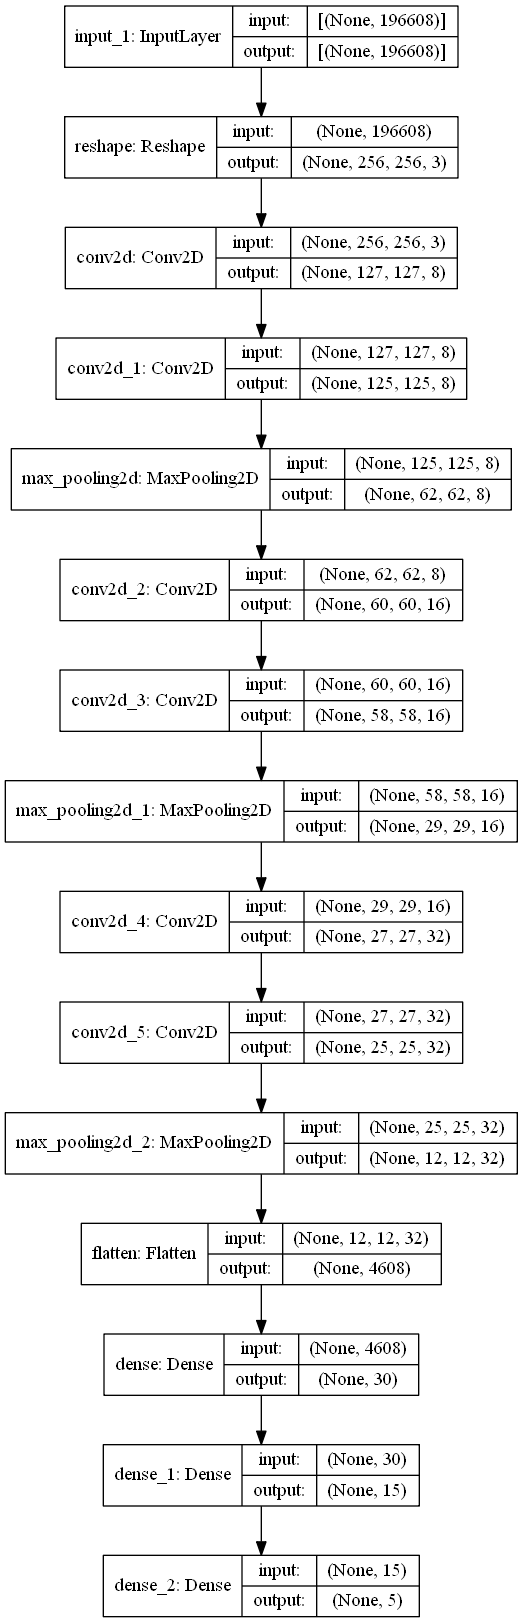

In [27]:
# Summary and model
kf.summary()
plot_model(kf,show_shapes = True)

In [28]:
# Compile
kf.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ["accuracy"])


We introduce callbacks here to ensure that our code doesn't overtrain too much by damping the learning rate (ReducedLR) and that if there is little/no improvement in results over 4 epochs, the run will end (early_stopping).

In [29]:
# Creating callbacks for better runtimes, these choices of patience have been found to be the best
callbacks = []
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 4, min_delta = 0.001, verbose = 1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1, min_lr = 0)
callbacks.append(reduce_lr)
callbacks.append(early_stopping)

Below is a very useful piece of code that I use throughout the entire program extensively. I should have functionalised it to allow me to call it whenever needed, but its short enough that this need not be the case.

It changes the particle names from '22.0, 2122.0, etc' to [0,1, etc], as the model wasn't working without this step.
It also allows for easy manipulation and understanding of this data, as our 'predicted particles' will also come out in this format and so we can use this y_train to create good confusion matrices.

In [30]:
# Take only particle names from truth_train, and relabel them as 0, 1, 2, 3, 4
part_id_con = [0, 1, 2, 3, 4]
truth_train_id = [item[0] for item in truth_train]
#truth_train_id = [int(i) for i in truth_train_id]
for j in range(len(part_id_con)):
    truth_train_id = [part_id_con[j] if x==[particles[j]] else x for x in truth_train_id]
y_train = np.array(truth_train_id)

Setting up the batch_size (required for guillermo's batch_generator code to work) as well as the sample and validation slice. To increase the speed of the code, decrease the sample and validation slices.

In [31]:
# Fitting, using the method from Guillermo's notebook. Testing with small sample size
# Full sample size is 50000, with 5000 validation slice
batch_size = 32
sample_size = 50000
validation_slice = 5000
# Take the smaller data sample for testing
x_train_short = x_train[:sample_size]
y_train_short = y_train[:sample_size]


# NOTE OF IMPORTANCE. RUN UP TO THIS POINT WHEN RESTARTING THE KERNEL TO GET ALL THE IMPORTANT DATA AND VALUES FOR LATER ANAYLSIS. This isn't 100% fullproof but you can find the cells required to make it run after this point quite easily, while avoiding the ML. I'd recommend if you're running through this not to run the ML code, as the fits can take upwards of 30 minutes and the hyperparameter searches take even longer.

## After I plot my hyperparameter search results by epoch, you're able to run through the cells again for analysis purposes if needbe. Preferably start at the point where I load the 3 best models from said search.

Feel free to run all this code, it *should* work perfectly, as its completely unaltered but you're going to have to deal with incredibly long model fitting wait-times. I'd recommend skipping down to after the hyperparameter fitting, as described above.

In [101]:
#print(x_train_short[0:10])    
print(y_train_short[0:10])
print(x_train_short.shape)
print(y_train_short.shape)

#fit the data
kff = kf.fit(nn_batch_generator(x_train_short[:-validation_slice], y_train_short[:-validation_slice], 
                                batch_size = batch_size), epochs = 20, 
                                steps_per_epoch = int((sample_size - validation_slice)/batch_size),
                                validation_data=(x_train_short[-validation_slice:], y_train_short[-validation_slice:]), callbacks = callbacks)
                             

[3 3 4 4 1 1 1 2 4 2]
(50000, 196608)
(50000,)
Epoch 1/20
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 0.9594 - accuracy: 0.5480

C:\Users\John\anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2458: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1406/1406 [==============================] - 196s 139ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.9594 - accuracy: 0.5480 - val_loss: 0.7287 - val_accuracy: 0.6442 - lr: 0.0010
Epoch 2/20
1406/1406 [==============================] - 192s 137ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.7081 - accuracy: 0.6518 - val_loss: 0.6898 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 3/20
1406/1406 [==============================] - 192s 136ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.6392 - accuracy: 0.6786 - val_loss: 0.6247 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 4/20
1406/1406 [==============================] - 195s 138ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.5990 - accuracy: 0.7007 - val_loss: 0.6372 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 5/20
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.5685 - accuracy: 0.7214
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1406/1406 [=======

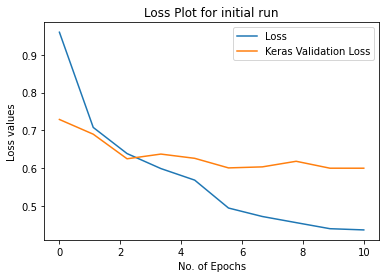

In [103]:
# Plotting the loss curve

# Need to change this dependent on number of epochs, or else code wont run
epochs = np.linspace(0,10,10)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Plot for initial run")
plt.plot(epochs,kff.history['loss'], label = 'Loss')
plt.plot(epochs,kff.history['val_loss'], label = 'Keras Validation Loss')
plt.legend()
plt.show()

These next two cells are for saving and loading the model. This is only required if you wish to modify or do anything with this model in particular. I'm keeping it here as a template for future models.

In [104]:
# save model
kf.save('project_model4_20.h5')

In [88]:
# load model to avoid having to do the epoch nonsense above, commented out for ease of use
#kfl = load_model('project_model2_20.h5')
# Summary and model, for it you've just loaded in a new model
#kfl.summary()
#plot_model(kf,show_shapes = True)

Next, lets use the predict function for our model to find how good our model is at predicting certain particles:

In [105]:
# Predict model
test_pred = kf.predict(x_test[:validation_slice])
# Pull out the highest predictions
y_pred = np.argmax(test_pred, axis = 1)



C:\Users\John\anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2458: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


This code is the same as before, but for truth_test, not truth_train. This is why I was saying I should have functionalised it.

In [43]:
# organise our truth_test id for fitting into confusion matrix, by labelling it the same as as done with our
# previous data

truth_test_id = [item[0] for item in truth_test]
for j in range(len(part_id_con)):
    truth_test_id = [part_id_con[j] if x==[particles[j]] else x for x in truth_test_id]
truth_test_id = np.array(truth_test_id)


In [32]:
# Purely testing
#print(y_pred)
#print(truth_train_id)
#print(truth_test)

Create the confusion matrix.

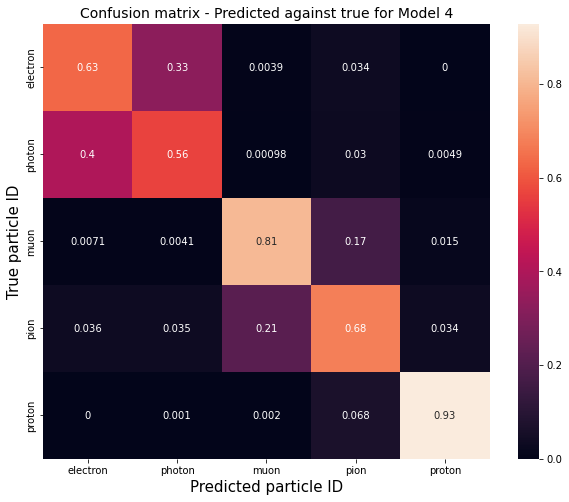

In [111]:

matrix = confusion_matrix(truth_test_id[:validation_slice], y_pred, normalize='true')
df_cm = pd.DataFrame(matrix, index = particle_names, columns = particle_names)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix - Predicted against true for Model 4', fontsize = 14)
plt.xlabel('Predicted particle ID', fontsize = 15)
plt.ylabel('True particle ID', fontsize = 15)
plt.savefig('confusionmatrix.pdf')
plt.savefig('confusionmatrix.png')
plt.show()

# This is model 4

### Discussing model2 (and in some respects, model4)
__Model2's results can be found in the Project_Models folder, it includes the architecture as well as all resulting graphs. Most of the points here also apply to model4__

This model gives a pretty good result on the confusion matrix. Understandably there are issues with photons and electrons, as was described in Task 0, they both appear like jets of particles which are difficult to distinguish from one another.

Muons and pions similarly have some overlap, and this appears to be caused by the fact that at median energies they appear very similar. At high energies, however they are quite different and can be separated quite easily.

Furthermore, the overtraining was limited by the earlystopping callback, which saved us a lot of time and improved the results significantly (as it was clear that overtraining was soon to occur). This is evident in the resulting graph (labelled val_loss against loss)

I have a feeling that if we remove the low momenta particles from the dataset (have to determine what 'low momenta' is ourselves) we may be able to achieve good particle purity. This is something to try after hyperparameter optimisation

From here, I think it would be good to redefine our model making method to allow for use of hyperparameter analysis.

## Redefining the model, and hyperparameter analysis.

### GOALS
* Apply hyperparameter estimation, then select best results and justify
* From here, fit this model, explaining in good detail its overall shape and reason
* Then explain its results, etc
 

In [32]:
# Will be using keras_tuner, as I tried other methods (commented out below) but couldnt get them to work nicely.
# https://www.tensorflow.org/tutorials/keras/keras_tuner
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.python.keras.models import Model, Sequential, load_model, save_model
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

First we rewrite the model code from earlier to allow for better adjustability

In [33]:
 
def model_builder(init_data_shape):
    # init_data_shape is the shape that we wish to pass through to the model.
    # in our case its x_train.shape[1:]
    flatinpt = Input(shape=init_data_shape)
    inpt = Reshape((256, 256, 3))(flatinpt) 
    conv1 = Conv2D(8, kernel_size = 3, strides = 2, activation = 'relu')(inpt)
    conv2 = Conv2D(8, kernel_size = 3, activation = 'relu')(conv1)
    # Average pooling or max pooling? Seems like from research online max pooling is better
    pool1 = MaxPooling2D(pool_size = (2,2))(conv2)
    conv3 = Conv2D(16, kernel_size = 3, activation = 'relu')(pool1)
    conv4 = Conv2D(16, kernel_size = 3, activation = 'relu')(conv3)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv4)
    conv5 = Conv2D(32, kernel_size = 3, activation = 'relu')(pool2)
    conv6 = Conv2D(32, kernel_size = 3, activation = 'relu')(conv5)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv6)
    flat = Flatten()(pool2)
    hidden1 = Dense(30, activation = 'relu')(flat)
    hidden2 = Dense(5, activation = 'relu')(hidden1)
    output = Dense(5, activation = 'softmax')(hidden2)

    # Create model
    kf = Model(inputs=flatinpt, outputs = output)
    # Compile
    kf.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
    return kf

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 127, 127, 8)       224       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 125, 125, 8)       584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 16)        1168      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 58, 58, 16)        2320

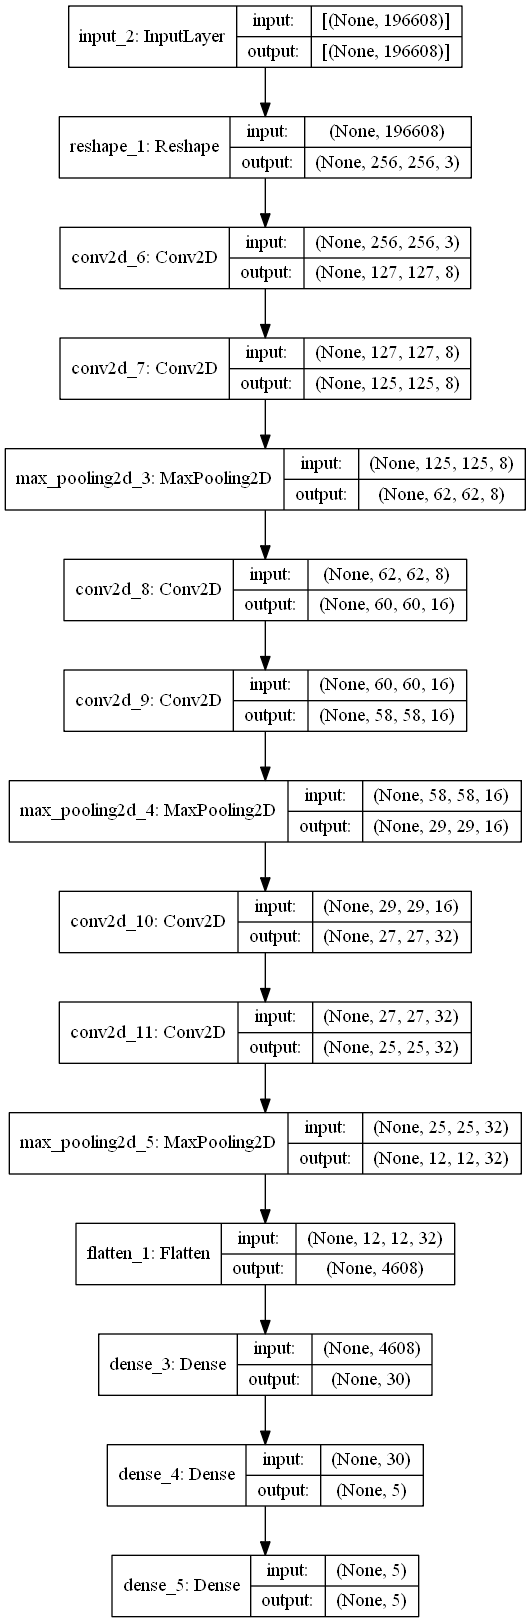

In [34]:
# And testing the previous model:
cf = model_builder(x_train.shape[1:])
cf.summary()
plot_model(cf,show_shapes = True)

And then rewrite it again to allow for hyperparameterisation


In [56]:
def new_mod_builder(data_shape, conv_layers, dense_layers):
    # Allows for hyperparameter searching by using new syntax to create easier model building and modification
    # data_shape -> initial data shape, will be rezised to (256, 256, 3)
    # conv_layers -> number of convolutional layers and their number of nodes/filters per layer, this includes max pooling
    # dense_layers -> number of dense layers and their number of nodes per layer.
    
    model = Sequential()
    # Adding dropout layer, then removing it again
    #model.add(Dropout(dropout, input_shape=(data_shape)))
    model.add(Reshape((256, 256, 3), input_shape=(data_shape)))
    
    # Initial layer
    model.add(Conv2D(conv_layers[0], kernel_size = 3, strides = 2, activation = 'relu'))
    model.add(Conv2D(conv_layers[0], kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
              
    # Creating a loop for number of convolutional layers, going up in 8->16->32->64
    # First layer already applied, due to extra stride. Hence the -1 and +1
    for i in range(len(conv_layers)-1):
        model.add(Conv2D(conv_layers[i+1], kernel_size = 3, padding='same', activation = 'relu'))
        model.add(Conv2D(conv_layers[i+1], kernel_size = 3, padding='same', activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))
    
    # Then flatten
    model.add(Flatten())
    
    # Then hidden layers
    for j in range(len(dense_layers)):
        model.add(Dense(dense_layers[j], activation = 'relu'))
    # Resulting output using softmax
    model.add(Dense(5, activation = 'softmax'))
    
    
   
    # compile and output
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
    
    return model

#### Discussing model architecture

The model has a few inbuilt requirements to ensure that it runs smoothly. For example, it is already reshaped into (256, 256, 3) to allow for the convolutional layers to better process it. There is also max pooling in every convolutional layer, as it appears to benefit the model to do so (based on previous checkpoints/lectures). 

The convolutional layers also have an initial layer that includes an increase in stride to 2, beyond this point the stride is kept as 1 which is the default. This mirrors the earlier cited paper, and is done to improve the runtime as it basically 'downsamples' the image when compared to strides = 1. This allows for quicker runtimes without losing too much information.

The dense layer includes a resulting layer that uses activation 'softmax' with 5 nodes. This corresponds to the 5 particles we are looking for throughout our dataset.

We use sparse_categorical_crossentropy here because we're looking for the probability of each sample being a particular particle, this allows us to produce and monitor loss based on our models ability to predict the correct particles.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 127, 127, 8)       224       
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 125, 125, 8)       584       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 62, 62, 16)        1168      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 62, 62, 16)        2320      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 31, 31, 16)       

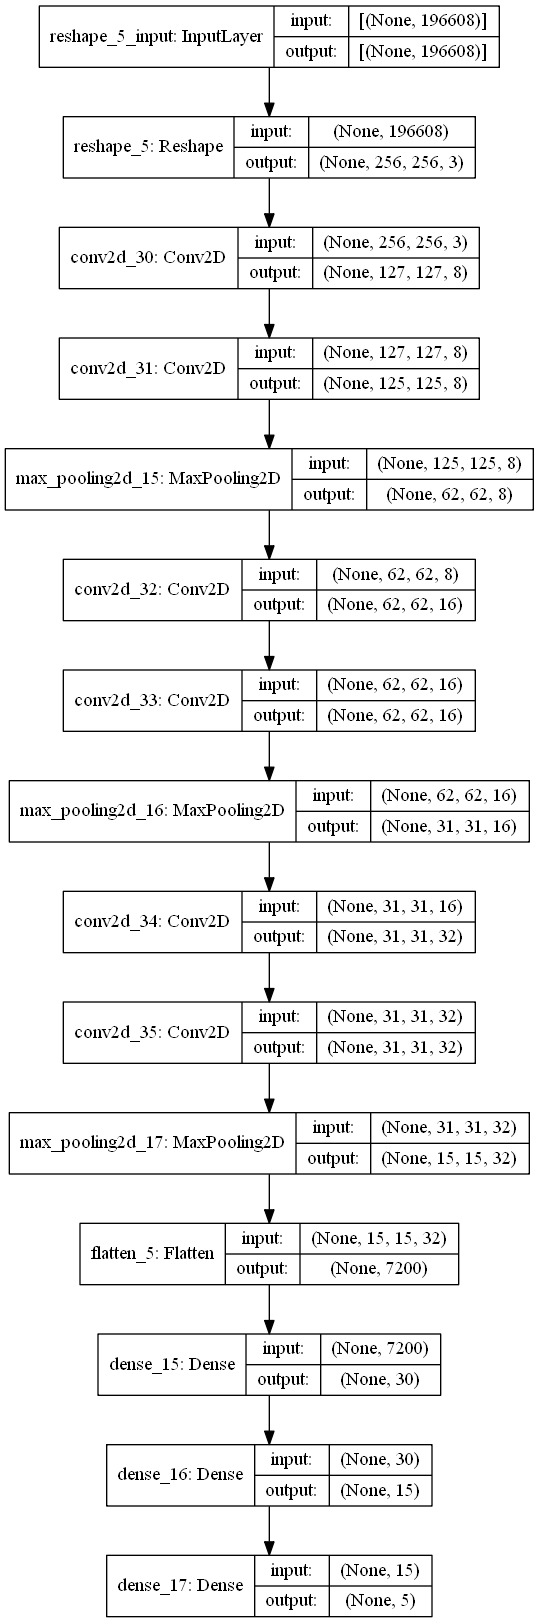

In [57]:
# Just to test that the above method works
jurt = new_mod_builder(x_train.shape[1:], [8, 16, 32], [30, 15])
jurt.summary()
plot_model(jurt,show_shapes = True)


Now that we've modified our original model to be malleable, and allow for swapping of many different parameters (specifically the number of convolutional layers and their nodes, and the number of density layers and their nodes). The slight differences are due to the inclusion of padding into our convolutional layers.

Now to write the hyperparameter testing kit to allow for further determination of good values for our system.

I added the dropout layer into the hidden layer, but due to errors in the code that I couldn't resolve I decided to remove it. It appeared to make the overtraining less, but I don't have the time to dedicate to an error that seemed to have no apparent solution online.

*I figured out the issue was due to me not making a conditional for when there was a dropout value of 0. If you set dropout to zero, keras doesn't just ignore the node, it'll spit out the strangest looking error on the planet that would in no way allow you to determine that its because the node itself not dropping anything out was the problem. If I had more time i'd rerun this with dropout included, but I found that (in independent quick tests) including it increased training times, but didnt result in better accuracies.*

In [38]:
# Defining param_grid to allow for grid_search

param_grid = {'conv_layers': [[8, 16, 32], [16, 32], [4, 8, 16]], 'dense_layers': [[30, 15], [30, 15, 10], [50, 25, 10]]}

hyper_search = ParameterGrid(param_grid)


# Just to demonstrate functionality
print(len(hyper_search))
print(hyper_search[0])
#print(hyper_search[1].get('dropout'))
#jurt2 = new_mod_builder(x_train.shape[1:], hyper_search[1].get('conv_layers'), hyper_search[1].get('dense_layers'), hyper_search[1].get('dropout'))
#jurt2.summary()

9
{'dense_layers': [30, 15], 'conv_layers': [8, 16, 32]}


In [85]:
# Redefining these parameters here, in case I want to modify them in any capacity within the hyperparameter test
batch_size = 32
sample_size = 50000
validation_slice = 5000
x_train_short = x_train[:sample_size]
y_train_short = y_train[:sample_size]



Running the hyperparameter fit for each model, and saving the best models separately. These will be provided with the notebook.

In [43]:

# Applying these parameters to all the models
model_list = []
model_fit_list = []
#del mode
#del mode_fit
# Build a model in each list and apply to list
for i in range(len(hyper_search)):
    
    print("Hyperparameter Run: {}".format(i))
    # Adding ModelCheckpoint to callbacks
    # https://machinelearningmastery.com/check-point-deep-learning-models-keras/
    # Redefined everytime to give a new filepath
    filepath = "weights.best_" + str(i) +  ".hdf5"
    filepath2 = "model" + str(i) + ".h5"
    # Will save highest val_accuracy value
    modcheck = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    
    # Create model with hyper_parameters
    mode = new_mod_builder(x_train.shape[1:],hyper_search[i].get('conv_layers'), hyper_search[i].get('dense_layers'))
    #fit the data
    mode_fit = mode.fit(nn_batch_generator(x_train_short[:-validation_slice], y_train_short[:-validation_slice], 
                                batch_size = batch_size), epochs = 13, 
                                steps_per_epoch = int((sample_size - validation_slice)/batch_size),
                                validation_data=(x_train_short[-validation_slice:], y_train_short[-validation_slice:]), callbacks = [callbacks,modcheck])
    
    # Save the model to a separate file
    mode.save(filepath2)
    # Append the fit & model onto the list
    model_list.append(mode)
    model_fit_list.append(mode_fit)

Hyperparameter Run: 0
Epoch 1/13
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 0.9456 - accuracy: 0.5527
Epoch 00001: val_accuracy improved from -inf to 0.64980, saving model to weights.best_0.hdf5
1406/1406 [==============================] - 237s 168ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.9456 - accuracy: 0.5527 - val_loss: 0.7149 - val_accuracy: 0.6498 - lr: 0.0010
Epoch 2/13
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6542 - accuracy: 0.6830
Epoch 00002: val_accuracy improved from 0.64980 to 0.68400, saving model to weights.best_0.hdf5
1406/1406 [==============================] - 233s 166ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.6542 - accuracy: 0.6830 - val_loss: 0.6586 - val_accuracy: 0.6840 - lr: 0.0010
Epoch 3/13
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.5792 - accuracy: 0.7291
Epoch 00003: val_accuracy

Epoch 00010: early stopping
Hyperparameter Run: 2
Epoch 1/13
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 0.9268 - accuracy: 0.5588
Epoch 00001: val_accuracy improved from -inf to 0.62260, saving model to weights.best_2.hdf5
1406/1406 [==============================] - 242s 171ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.9268 - accuracy: 0.5588 - val_loss: 0.7585 - val_accuracy: 0.6226 - lr: 0.0010
Epoch 2/13
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7171 - accuracy: 0.6488
Epoch 00002: val_accuracy improved from 0.62260 to 0.65100, saving model to weights.best_2.hdf5
1406/1406 [==============================] - 234s 167ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.7171 - accuracy: 0.6488 - val_loss: 0.7189 - val_accuracy: 0.6510 - lr: 0.0010
Epoch 3/13
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6279 - accuracy: 0.69

1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 1.0307 - accuracy: 0.5200
Epoch 00001: val_accuracy improved from -inf to 0.60160, saving model to weights.best_7.hdf5
1406/1406 [==============================] - 201s 143ms/step - batch: 702.5000 - size: 32.0000 - loss: 1.0307 - accuracy: 0.5200 - val_loss: 0.8316 - val_accuracy: 0.6016 - lr: 0.0010
Epoch 2/13
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.7310 - accuracy: 0.6396
Epoch 00002: val_accuracy improved from 0.60160 to 0.64540, saving model to weights.best_7.hdf5
1406/1406 [==============================] - 195s 139ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.7310 - accuracy: 0.6396 - val_loss: 0.6896 - val_accuracy: 0.6454 - lr: 0.0010
Epoch 3/13
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 31.9829 - loss: 0.6554 - accuracy: 0.6706
Epoch 00003: val_accuracy improved from 0.64540 to 0.65280

Plotting the losses and val_losses of our different models:

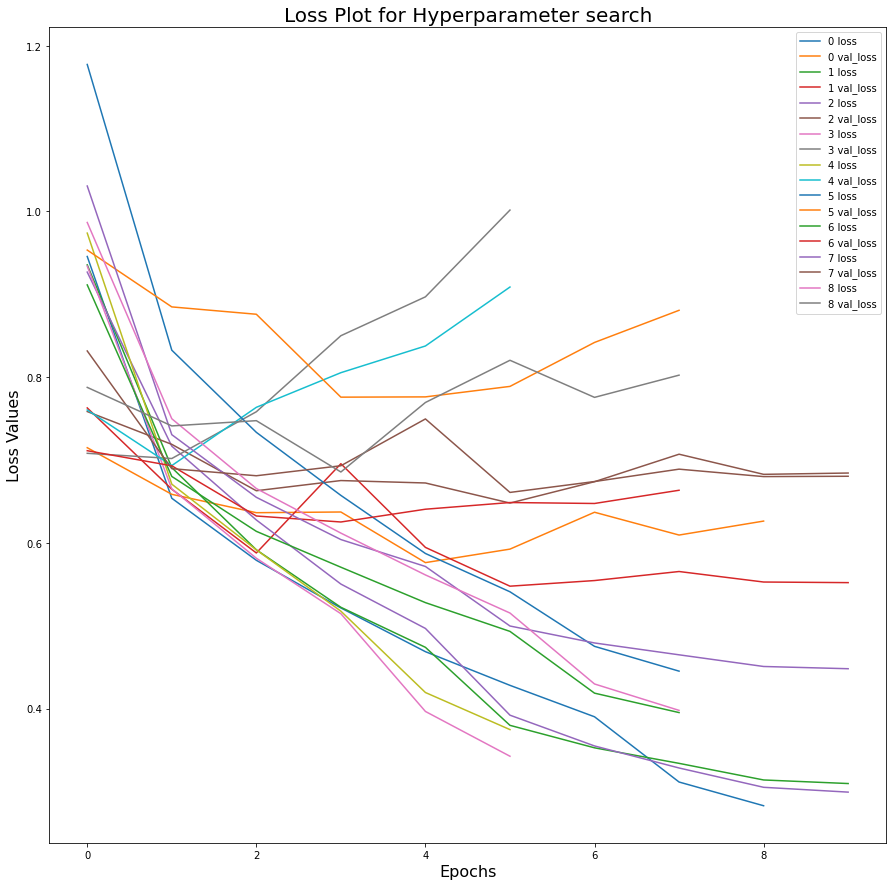

In [69]:
# Plot the loss and val loss for each model
from matplotlib import cm

epochs = np.linspace(0,13,13)
plt.figure(figsize=(15,15))
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss Values', fontsize = 16)
plt.title('Loss Plot for Hyperparameter search', fontsize = 20)
# setting this up so that every colour is different, as matplotlib will copy colours
color = iter(cm.rainbow(np.linspace(0, 1, len(model_list)*2)))
for j in range(len(model_list)):
        c = next(color)
        plt.plot(model_fit_list[j].history['loss'], label = str(j) + ' loss', )
        c = next(color)
        plt.plot(model_fit_list[j].history['val_loss'], label = str(j) + ' val_loss', )
        
plt.legend()
plt.savefig("fullhyper_parameter.png")
plt.show()

This is way too much information to take in, so lets only include the models that run longer than 9 epochs, as I built my model with the earlystopping callback based on val_loss, so shorter runs signify increases in val loss beyond what is acceptable. This plot is saved in case it is lost in the folder directory.

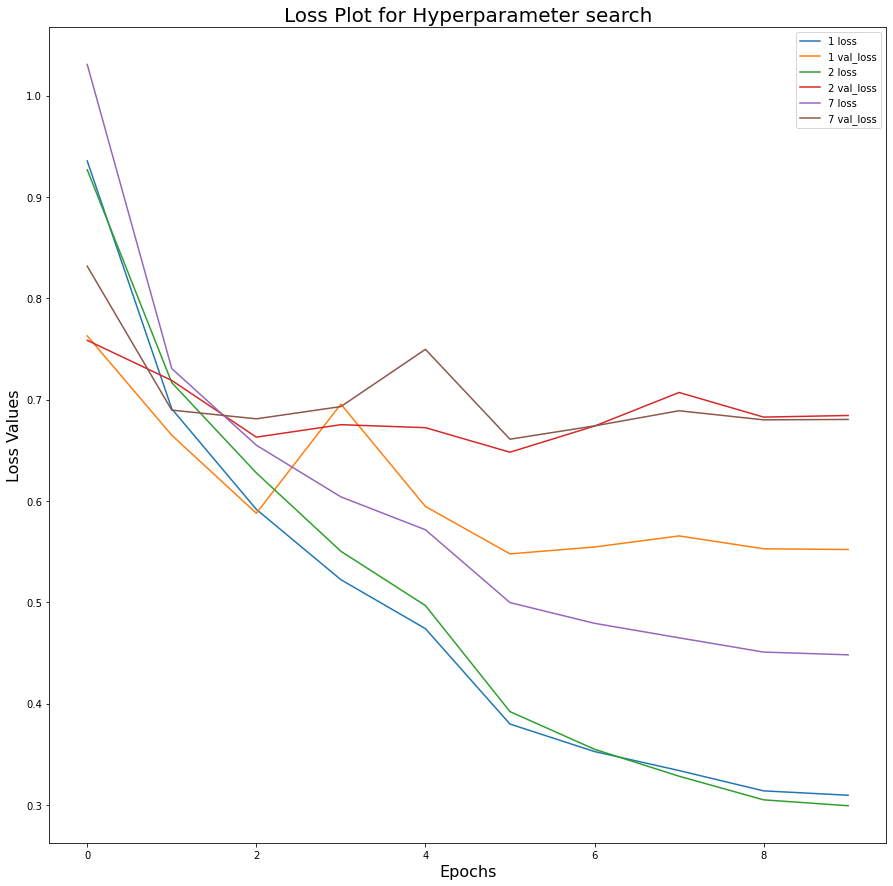

In [71]:
# Plot the loss and val loss for each model beyond 9 epochs

epochs = np.linspace(0,13,13)
plt.figure(figsize=(15,15))
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss Values', fontsize = 16)
plt.title('Loss Plot for Hyperparameter search', fontsize = 20)
# setting this up so that every colour is different, as matplotlib will copy colours
color = iter(cm.rainbow(np.linspace(0, 1, len(model_list)*2)))
for j in range(len(model_list)):

    # only plot ones that last longer than 9 epochs
    if (len(model_fit_list[j].history['loss']) > 9):
        plt.plot(model_fit_list[j].history['loss'], label = str(j) + ' loss', )
        plt.plot(model_fit_list[j].history['val_loss'], label = str(j) + ' val_loss', )
        
plt.legend()
plt.savefig("hyper_parameter.png")
plt.show()

Looking at the hyperparameter search. If the graph doesn't show here it is saved as hyper_parameter.png within the Project_Models/HyperParameter directory.

We're considering the runs 7, 2, and 1.

Runs 7 and 2 have very similar validation loss, but 7 has significantly lower loss by default. On the other hand, Run 1 has low loss and lower validation loss, that appears to level out. This is occuring even while the normal loss appears to be decreasing.

The long 'stagnant' tails of all of these models could be a feature of our system using the reduced learning rate callbacks, but regardless I will plot confusion matrices for all 3 models to futher determine which is worthy of keeping.


### If you want to avoid running all the machine learning code, I'd recommend starting here. I've copied and pasted the important variables into the below cell which should allow the code to run smoothly from this point.

In [32]:
# CELL THAT ALLOWS US TO START HERE AFTER AVOIDING ML CODE


# organise our truth_test id for fitting into confusion matrix, by labelling it the same as as done with our
# previous data
truth_test_id = [item[0] for item in truth_test]
for j in range(len(part_id_con)):
    truth_test_id = [part_id_con[j] if x==[particles[j]] else x for x in truth_test_id]
truth_test_id = np.array(truth_test_id)

# Defining param_grid to allow for grid_search

param_grid = {'conv_layers': [[8, 16, 32], [16, 32], [4, 8, 16]], 'dense_layers': [[30, 15], [30, 15, 10], [50, 25, 10]]}

hyper_search = ParameterGrid(param_grid)



Load the files if you need to here: they are saved within the Project_Models/HyperParameter/Models directory, with numbers corresponding to each run. To load them, either point to the directory or put them in your jupyter directory

In [33]:
# Load the files if you need to here: they are saved within the Project_Models/HyperParameter/Models directory, with numbers corresponding to each run.
# To load them, either point to the directory or put them in your jupyter directory
run1 = load_model('model1.h5')
run2 = load_model('model2.h5')
run7 = load_model('model7.h5')

A summary for each model that is of interest:

In [34]:
# Summary and model, for it you've just loaded in a new model
run_list = [run1, run2, run7]
run_liststr = ['run1', 'run2', 'run7']
for j in range(len(run_list)):
    print(run_liststr[j])
    run_list[j].summary()

#plot_model(run7, show_shapes = True)

run1
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 127, 127, 8)       224       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 125, 125, 8)       584       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 62, 62, 16)        1168      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 62, 62, 16)        2320      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 16)  

In [35]:
# A simpler way to look at them, the dictionary from param_grid
print("Run 1: {}".format(hyper_search[1]))
print("Run 2: {}".format(hyper_search[2]))
print("Run 7: {}".format(hyper_search[7]))


Run 1: {'dense_layers': [30, 15, 10], 'conv_layers': [8, 16, 32]}
Run 2: {'dense_layers': [50, 25, 10], 'conv_layers': [8, 16, 32]}
Run 7: {'dense_layers': [30, 15, 10], 'conv_layers': [4, 8, 16]}


Now that we know the contents, lets find the accuracies and loss for each model.

**Warning! Again this next step takes a while to run and is only used to show accuracy, please skip this cell if you want to avoid long runtimes!**

In [46]:
#cnn.evaluate(nn_batch_generator(x_test, y_train_labels,batch_size=50),steps=len(cc)/50)

# Also show the accuracy for each run here
# WARNING THIS TAKES A WHILE TO RUN AND REQUIRES A LOT OF MEMORY, YOU HAVE BEEN WARNED!
r1_ev = run1.evaluate(nn_batch_generator(x_train_short, y_train_short, batch_size = batch_size), steps = 40000/batch_size)
r2_ev = run2.evaluate(nn_batch_generator(x_train_short, y_train_short, batch_size = batch_size), steps = 40000/batch_size)
r7_ev = run7.evaluate(nn_batch_generator(x_train_short, y_train_short, batch_size = batch_size), steps = 40000/batch_size)

In [67]:
print("Run 1 accuracy: {:.4f}\nRun 1 Loss: {:.4f}".format(r1_ev[1],r1_ev[0]))
print("Run 2 accuracy: {:.4f}\nRun 2 Loss: {:.4f}".format(r2_ev[1],r2_ev[0]))
print("Run 7 accuracy: {:.4f}\nRun 7 Loss: {:.4f}".format(r7_ev[1],r7_ev[0]))

Run 1 accuracy: 0.8713
Run 1 Loss: 0.3146
Run 2 accuracy: 0.8747
Run 2 Loss: 0.3046
Run 7 accuracy: 0.7707
Run 7 Loss: 0.4524


So these are the resulting accuracies from our builds. It appears that Run 2 has the best accuracy (by a small margin) and that the lowest loss. We'll investigate this further with our confusion matrices:

In [91]:
# Create confusion matrices, data should be passed through implicitly by it being run earlier.
def conf_create(model, name):
    # Predict model using Guillermos batch gnerator again
    test_pred = model.predict(nn_batch_generator(x_test[:validation_slice], truth_test[:validation_slice], batch_size = 50),steps = len(truth_test[:validation_slice])/50)
    # Pull out the highest predictions
    y_pred = np.argmax(test_pred, axis = 1)
    matrix = confusion_matrix(truth_test_id[:validation_slice], y_pred, normalize='true')
    df_cm = pd.DataFrame(matrix, index = particle_names, columns = particle_names)
    plt.figure(figsize = (10,8))
    sns.heatmap(df_cm, annot=True)
    plt.title('Confusion matrix - Predicted against true for Model ' + name, fontsize = 14)
    plt.xlabel('Predicted particle ID', fontsize = 15)
    plt.ylabel('True particle ID', fontsize = 15)
    plt.savefig('confusionmatrix' + name + '.pdf')
    plt.savefig('confusionmatrix' + name + '.png')
    plt.show()




These are only run over the validation slices, rather than the whole image dataset. I did run this function over the entire dataset though (only requires removing the [:validation_slice] lines and changing the step size) and it made no difference to the resulting confusion matrices (beyond changes of 0.01 or less in unimportant blocks.)

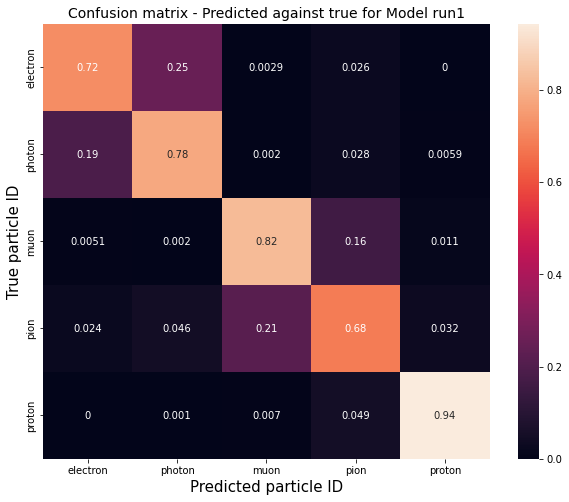

In [93]:
# Running both just to verify that the saved file is the same as the file currently stored in memory
# To re-run this from memory, remove the model_list[1] run.
#conf_create(model_list[1], 'run1')
conf_create(run1, 'run1')

They are the same, so that allow us to use this function to plot the other two:

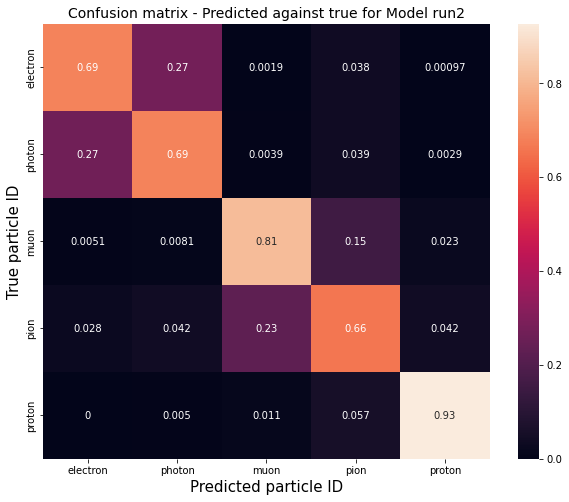

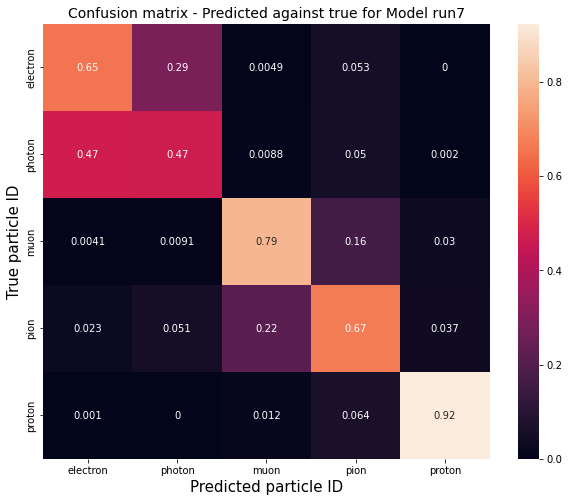

In [94]:
conf_create(run2, 'run2')
conf_create(run7, 'run7')

## Hyperparameter conclusion

Here there should be 3 confusion matrices plotted for the different runs. If not, they can be found in the HyperPameter Directory as mentioned above.

It's clear that the best run for predicting our particles across these samples is run1, which had a the param_grid values of: '{'dense_layers': [30, 15, 10], 'conv_layers': [8, 16, 32]}'. This is interesting considering run2 had better accuracy and less loss, but the difference between the accuracy/loss of these two models was very small (less than 0.01 difference across both).

Curiously, the only difference between run1 and 2 is that run2 includes more dense layers. This shows that including more dense layers doesn't appear to aid the model. Perhaps with dropout layers included this wouldn't be the case, but alas I am limited by time and this hyperparameter search took approximately 5 hours to run on my home computer (i7-9770k at full load!). So we will have to assume that this model is the best from our choices.

Run7, while it appeared to have acceptable levels of loss and accuracy, is clearly not fit for the task as it mistakes protons and electrons far too easily. So in the end its determined that the model worth using is that of run1.


## Trimming of data

I believe, based on previous searching through the samples, that if lower total momentum particles were removed from the data (lets say, the bottom 10 percentile) the models would be able to distinguish between certain particles far easier. This is based on the visual evidence from above that at low momenta the particles in the detector often look identical to one another (although not exactly). The issue seems most prevelant between electrons and photons, so if we take every particle below 300 MeV out of the data samples, we may get better results.

Before looking any further, I want to verify that my belief that these low momenta particles are the biggest issue in my model:

Lets look at what particles our model prediction got wrong. This will give us a better idea of what values need to be cut to get a better prediction.
We'll be considering our best model 'run1' with hyper parameters: '{'dense_layers': [30, 15, 10], 'conv_layers': [8, 16, 32]}'. 

In [95]:
# Predict using best model 
an_test_pred = run1.predict(x_test[:validation_slice])

In [96]:
# Pull out the highest predictions
an_y_pred = np.argmax(an_test_pred, axis = 1)

Because the full data is too massive to fit in my memory (56GB approximately, according to jupyter) I'll take the validation slice and look at the incorrectly predicted particles.

In [97]:
# Cant take the full x_test because its too massive, so only considering the validation slice
print(len(an_y_pred))
print(an_y_pred)

5000
[2 0 0 ... 4 3 4]


In [98]:
# The true data
an_truth_test = truth_test_id[:validation_slice]
print(an_truth_test)
print(len(an_truth_test))

[2 0 0 ... 4 3 4]
5000


Now that we have the real resulted and the predicted results, we can collect the indexes of all the incorrect and correct guesses:

In [99]:
# Collect incorrect predictions to a list and vice versa
hit = []
miss = []
for i in range(len(an_truth_test)):
    # If correct, add index to correct tally
    if (an_y_pred[i] == an_truth_test[i]):
        hit.append(i)
    else:
        miss.append(i)
# Verifying that it works by checking total length, then first 10 of each sample
print("Hits: {:.2f} Misses: {:.2f}".format(len(hit),len(miss)))
print(str(len(hit) + len(miss)))
print(hit[:10])
print(miss[:10])

Hits: 3945.00 Misses: 1055.00
5000
[0, 1, 2, 3, 4, 5, 6, 8, 9, 12]
[7, 10, 11, 13, 14, 18, 22, 24, 33, 51]


In [100]:
print(truth_test[0])

[ 13.         469.89686318 115.62605221 444.1178458  100.9608805
  78.605953     1.617372    42.839259  ]


Above is just some sanity checks above to make sure we're not double counting, and that the data we're interested in is indeed what we're looking for.

Here we produce histograms for the correct and incorrect predictions for each element (total momentum, position, etc)

In [101]:
# Create a histogram of the missed particle's momentum, x position, etc against the hits
def hist_draw(hit, miss, value):
    # value dictates what component you're pulling out, type is for showing on graphs
    # collate the list for hit values
    data_type = ["ID","Total Momentum","X component of Momentum","Y component of Momentum","Z component of Momentum","X position of particle production","Y position of particle production","Z position of particle production"]
    xlabel = ["ID", "MeV", "MeV", "MeV", "MeV", "cm", "cm", "cm"]
    hit_data = []
    miss_data = []
    # Collate hit data
    for i in range(len(hit)):
        hit_data.append(truth_test[hit[i]][value])
    # Collate miss data
    for i in range(len(miss)):
        miss_data.append(truth_test[miss[i]][value])
        
    # Plot histograms
    plt.hist(hit_data, label = "Correct Predictions", histtype=u'step')
    plt.hist(miss_data, label = "Incorrect Predictions", histtype=u'step')
    plt.title("Histogram of " + str(data_type[value]) + " for Correct and Incorrect Predictions")
    plt.xlabel(str(xlabel[value]))
    plt.legend()
    plt.savefig(str(data_type[value]) + '_Prediction_Histogram.pdf')
    plt.show()

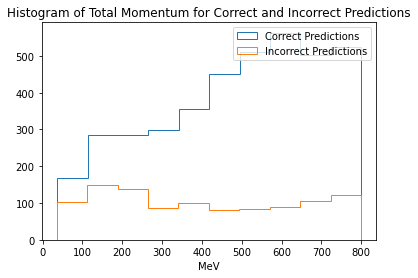

In [102]:
# Run code for total momentum
hist_draw(hit, miss, 1)

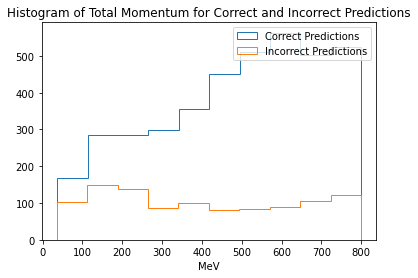

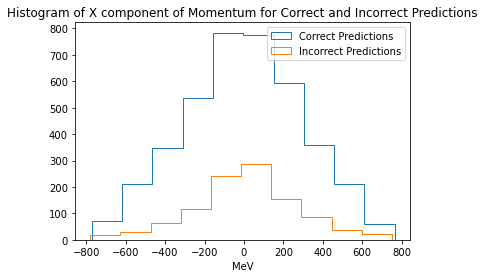

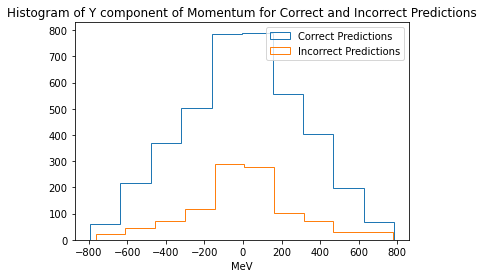

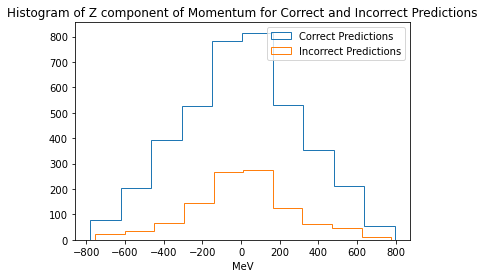

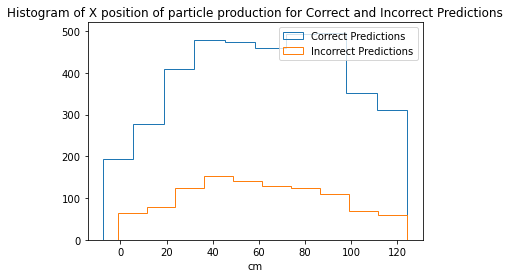

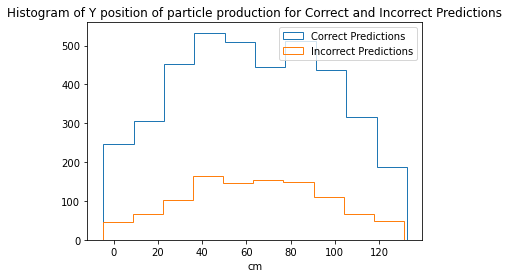

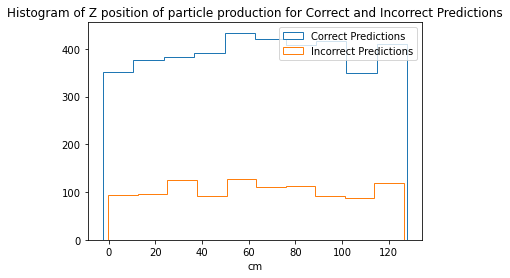

In [103]:
# Looks good, going to print out all of them here (and save them, they'll be in a directory labelled 'Prediction Histograms') and analyse them
for i in range(len(truth_test[0])-1):
    hist_draw(hit, miss, i+1)

Most of the graphs appear to be relatively evenly distributed, the largest discrepency between the correct and incorrect predictions being in the low total momentum space as was assumed when initially looking at the pure cut. 

While I would like to remove this low momentum section for the 'pure cut' of our data, I am unable to do so right now due to time limitations and difficulties with dealing with sparse matrices. If I have time, I will come back to this.

I had time! Further looking at removing low momentum particles:

In [104]:
# Just refreshing my memory on the data structure
print(x_test.shape)
print(len(truth_test))
# So index within truth_test describes the particles within x_test.

(40000, 196608)
40000


So we'll create a new list that trims away all the low momentum particles:

In [105]:
# Create a list of all samples with Total momentum less than 100 MeV

# Showing that this is the momentum value
print(truth_test[0][1])

low_mom_list = []
for k in range(len(truth_test)):
    if (truth_test[k][1] < 400):
        low_mom_list.append(k)

#print(low_mom_list)
# Print low momentum particle for verification
print(truth_test[low_mom_list[0]][1])
#print(low_mom_list)

469.896863177088
341.03719255328184


In [106]:
# How do we remove elements of a sparse list?
print(type(x_test))
print(x_test.shape)
print(x_test.shape[0])
print(len(low_mom_list))

<class 'scipy.sparse.csr.csr_matrix'>
(40000, 196608)
40000
14729


In [107]:
# Now that we know this works, collect only values with higher mom into new list
# low_mom_x_test = []

#for i in range(x_test.shape[0]):
#    # If i is in the list, skip, otherwise append
#    if i in low_mom_list:
#        continue;
#    else:
#        low_mom_x_test.append(x_test[i])

## IGNORE THIS CELL


So its clear we've removed the 1485 low momentum values from our list based on this result.
So now lets try to plot our confusion matrix with this data to see if our results improve.

I wasn't entirely sure how to deal with sparse matrices at this point, took me a couple hours to do the code below a couple days later.

In [108]:
# Think I can remove the low mom elements now
#low_mom_list
#print(x_test[4000])
x_testing_sparce = x_test[:4000]
print(x_testing_sparce, type(x_testing_sparce))
# This will only go up to (3999, .....)

  (0, 2775)	67.4774398803711
  (0, 3543)	96.23983764648438
  (0, 4311)	133.3686065673828
  (0, 5079)	22.43287467956543
  (0, 5082)	68.53582000732422
  (0, 5850)	90.79796600341797
  (0, 6618)	196.62222290039062
  (0, 7386)	106.76216888427734
  (0, 8157)	100.4316177368164
  (0, 8925)	82.42041778564453
  (0, 9693)	87.4014892578125
  (0, 10461)	73.00151062011719
  (0, 10464)	33.74769592285156
  (0, 11232)	94.42729187011719
  (0, 12000)	91.3051986694336
  (0, 12768)	98.10945129394531
  (0, 13536)	57.93164825439453
  (0, 13539)	53.21742248535156
  (0, 14307)	86.8581771850586
  (0, 15075)	83.59782409667969
  (0, 15843)	92.04129791259766
  (0, 16611)	27.270334243774414
  (0, 16614)	53.76811599731445
  (0, 17382)	85.37882995605469
  (0, 18150)	119.32290649414062
  :	:
  (3999, 184052)	106.88391876220703
  (3999, 184055)	26.522912979125977
  (3999, 184058)	511.10711669921875
  (3999, 184823)	152.89389038085938
  (3999, 184826)	326.22711181640625
  (3999, 184829)	410.4381103515625
  (3999, 184880

So we can eliminate indexes in these arrays the same way we can for lists. 
We have the list of low momentum particles, just need to take out the specific low momentum elements.

In [109]:
# Taking out low momentum elements
array = []
# hardcoded to 40000 as I couldnt find a better way to get particle data out. 
# 40000 is the number of samples in the csr_matrix
for i in range(40000):
    if i in low_mom_list:
        continue;
        # This used to print when you hit the low values, but I've removed it because its spammy
        #print("Low Value! Avoided!")
    else:
        array.append(x_test[i])



In [110]:
# Testing that this list sparse works as intended as the code sees it as a list of sparse matrices...not a full list
print(type(array))
print(type(array[0]))
x_test
array[0]

<class 'list'>
<class 'scipy.sparse.csr.csr_matrix'>


<1x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 793 stored elements in Compressed Sparse Row format>

So we have separate arrays like so, lets stack them up:

In [111]:
full_array = sparse.vstack(array)

In [112]:
full_array

<25271x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 21526204 stored elements in Compressed Sparse Row format>

This took much longer than it should have...I feel like the difficulty of understanding/manipulating these sparse matrices has been underestimated.
But now I can predict with this data instead! We know its correct based on the removal of samples, which we can check against the length of the low momentum list shown earler:


In [113]:
print(len(low_mom_list))

14729


Now will predict with this data using our best model:

In [114]:
# Predict using best model, now with low momentum removed.
test_pred_low_mom = run1.predict(full_array[:validation_slice])

In [115]:
# Pull out the highest predictions
test_pred_low_mom_max = np.argmax(test_pred_low_mom, axis = 1)

Need to collect the equivalent 'truth' values from the dataset

In [116]:
# Taking out low momentum elements
array_truth = []
# hardcoded to 40000 as I couldnt find a better way to get particle data out
for i in range(40000):
    if i in low_mom_list:
        #print("Low Value! Avoided!")
        continue;
    else:
        array_truth.append(truth_test[i])
print(len(array_truth))

25271


In [117]:
# Its not in the right format, need to apply truth_test_id method to it
print(array_truth[0])

[ 13.         469.89686318 115.62605221 444.1178458  100.9608805
  78.605953     1.617372    42.839259  ]


In [118]:
truth_test_id_low_mom = [item[0] for item in array_truth]
for j in range(len(part_id_con)):
    truth_test_id_low_mom = [part_id_con[j] if x==[particles[j]] else x for x in truth_test_id_low_mom]
truth_test_id_low_mom = np.array(truth_test_id_low_mom)

In [119]:
print(truth_test_id_low_mom)

[2 0 4 ... 1 1 4]


So we have the truth array now also in the correct format (although with a horrible variable name), we can create the confusion matrix to see if our predictions have improved:

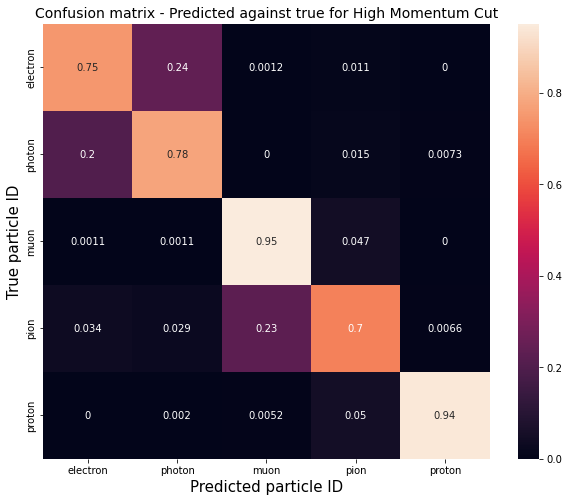

In [120]:
matrix = confusion_matrix(truth_test_id_low_mom[:validation_slice], test_pred_low_mom_max, normalize='true')
df_cm = pd.DataFrame(matrix, index = particle_names, columns = particle_names)
plt.figure(figsize = (10,8))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix - Predicted against true for High Momentum Cut', fontsize = 14)
plt.xlabel('Predicted particle ID', fontsize = 15)
plt.ylabel('True particle ID', fontsize = 15)
plt.savefig('confusionmatrix_high_mom' + '.pdf')
plt.savefig('confusionmatrix_high_mom' + '.png')
plt.show()


Okay the cutting worked! It seemed to have a large effect on the muons being incorrectly predicted as pions, but beyond that very little occurred. Writing this trimming code within a function, so that I can look at multiple functions at once.

In [121]:
#Make this a method
def low_cut_mom(momentum, slice_size):
    
    # This code assumes that you have truth_test and x_test already loaded preemptively. So make sure you do!
    
    # Create low momentum list
    low_mom_list = []
    for k in range(len(truth_test)):
        if (truth_test[k][1] < momentum):
            low_mom_list.append(k)
    print("{} particle data samples removed.".format(len(low_mom_list)))
    
    # Taking out low momentum elements from our x_test value
    array = []
    # hardcoded to 40000 as I couldnt find a better way to get particle data out
    # There are 40000 samples within our csr_matrix
    for i in range(40000):
        if i in low_mom_list:
            continue;
        else:
            array.append(x_test[i])
    # Stack the matrix-list
    full_array = sparse.vstack(array)
    # Just to check that its correct, show the array shape like so.
    full_array
    
    # Predict using best model, now with low momentum removed.
    test_pred_low_mom = run1.predict(full_array[:slice_size])
    # Pull out the highest predictions
    test_pred_low_mom_max = np.argmax(test_pred_low_mom, axis = 1)
    
    # Taking out low momentum elements
    array_truth = []
    # hardcoded to 40000 as I couldnt find a better way to get particle data out
    for i in range(40000):
        if i in low_mom_list:
            continue;
        else:
            array_truth.append(truth_test[i])
    
    # Convert the particles into [0, 1, 2, 3, 4] list (same as model)
    truth_test_id_low_mom = [item[0] for item in array_truth]
    for j in range(len(part_id_con)):
        truth_test_id_low_mom = [part_id_con[j] if x==[particles[j]] else x for x in truth_test_id_low_mom]
    truth_test_id_low_mom = np.array(truth_test_id_low_mom)
    
    # Plot confusion matrix and saving them
    matrix = confusion_matrix(truth_test_id_low_mom[:slice_size], test_pred_low_mom_max, normalize='true')
    df_cm = pd.DataFrame(matrix, index = particle_names, columns = particle_names)
    plt.figure(figsize = (10,8))
    sns.heatmap(df_cm, annot=True)
    plt.title('Confusion matrix - Predicted against true for' + str(momentum) + 'Momentum Cut', fontsize = 14)
    plt.xlabel('Predicted particle ID', fontsize = 15)
    plt.ylabel('True particle ID', fontsize = 15)
    plt.savefig('confusionmatrix_high_mom_' + str(momentum) + '.pdf')
    plt.savefig('confusionmatrix_high_mom_' + str(momentum) + '.png')
    plt.show()
    
    # deleting array to save memory
    # this shouldnt need to be done as its reset above, but done just in case
    del full_array

Now that its written into a function, can try it for different minimum cuts.
Will try 100MeV, 200MeV, 300MeV and 400MeV for total momenta. 


**PLEASE BE CAREFUL RUNNING THE CODE BELOW, REDUCE THE SAMPLE_SIZE FROM 10000 TO SOMETHING LOWER LIKE 5000**

The above function uses .predict with models to produce the confusion matrices below. So this may take a while to run.

0 particle data samples removed.


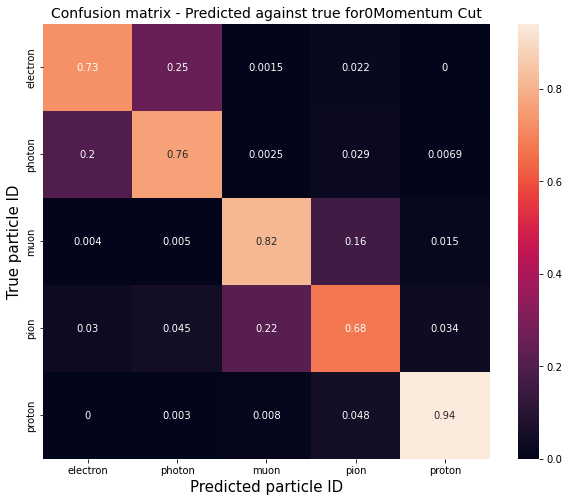

1485 particle data samples removed.


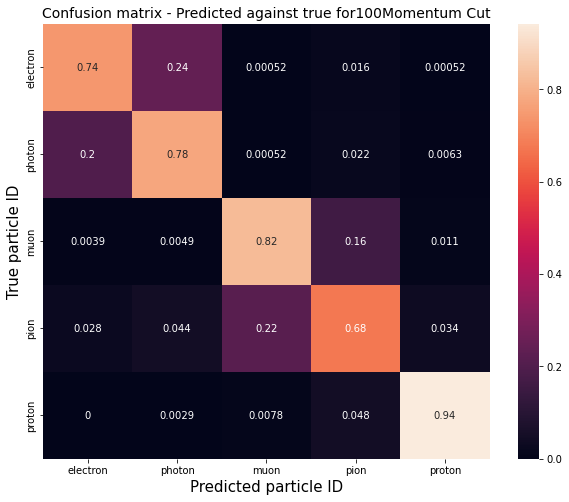

5791 particle data samples removed.


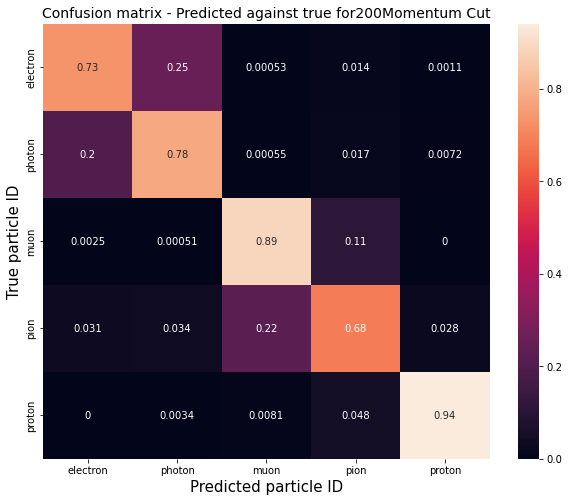

10131 particle data samples removed.


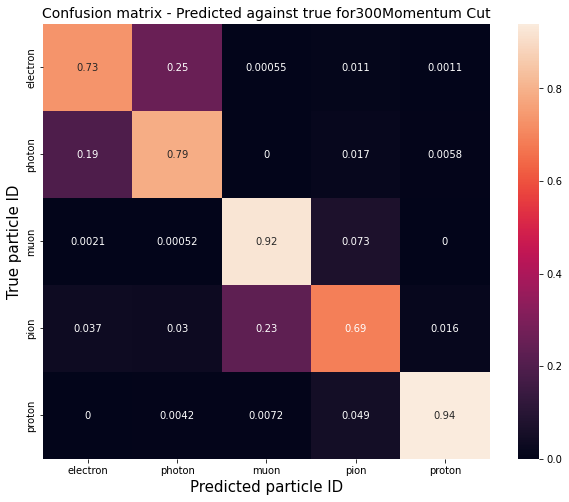

14729 particle data samples removed.


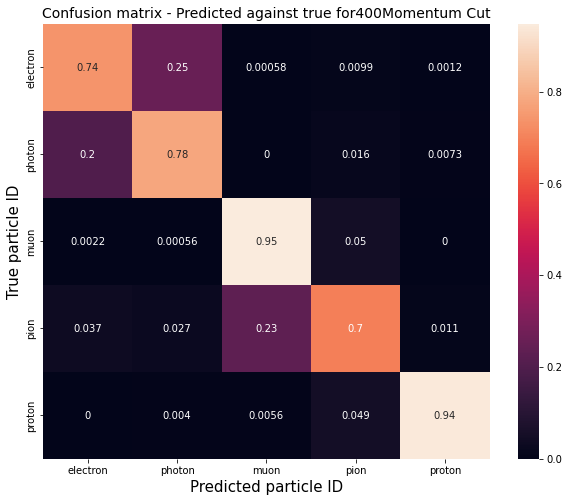

In [74]:
# Change number of samples based on how quick your computer is (here its set to 10000).
# If your cut is too large, you will not have 10000 samples though, so be careful!
# Also, lower the sample_size if you dont have enough memory! At home my PC has 16GB and struggles
# so good luck!

# 0 is our original confusion matrix, replotted here for convenience
#              VVVVV    REDUCE SAMPLE SIZE HERE 
low_cut_mom(0, 10000)
low_cut_mom(100, 10000)
low_cut_mom(200, 10000)
low_cut_mom(300, 10000)
low_cut_mom(400, 10000)

## Comments on cutting results

It's clear that as you remove lower energy samples, the accuracy for predicting muons correctly increases significantly. This is due to low energy pions most likely being confused with low energy muons. Curiously this effect doesn't work in reverse, as the the pions appear to be confused for muons quite consistently regardless of total momentum.

Other than that, the cutting had little effect, so maybe more complex cuts are required to get a better result. I have the tools to do so now but I dont have the time to execute this perfectly if I want to get any work done on task 2

## Conclusion for Task 1

From the beginning
* Create an algorithm to identify each event as being from one of five types of particles present in the datase
* You are strongly encouraged to use a convolutional neural network (CNN) classifier on the images, though this is not compulsary.
* Explore different architectures for the model, and explain in detail your choice of model, and the final parameters chosen. Consider doing a robust hyperparameter search.
* Explore the results and documents your findings. Ask as many questions about your model as you can, and document your findings.
    * Which particles are easy to identify, and which are not? 
    * What are the physics reasons for why some particles are similar?
    * Is there a dependence on particle position or momentum in your classifier for certain particle types?
    * Can you come up with a selection which gives good paricle purity?
    


We've produced an algorithm using a CNN to identify each event as being one of five types of particles present in the database. We built our initial CNN model based on the one given in the paper: https://inspirehep.net/literature/1823841


We tested multiple different models via hyperparameter optimisation to determine the best possible configuation of convolutional and dense layers and came to a model which gives generally reasonable results. 

As has been discussed previously, the inclusion of extra dense layers beyond a certain point appears to help very little in developing the model, and its clear from the hyperparameter search that the further inclusion of more convolutional layers with greater filters would be beneficial for the model. This is clear due to our best two models both having the largest number of convolutional layers and filters possible within the hyperparameter search. This is reflected in the paper linked earlier, in which many more convolutional layers with larger filters are applied to the dataset.

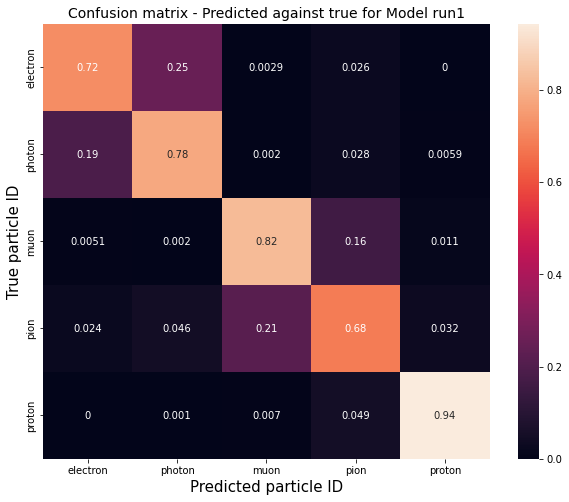

In [122]:
# Showing the confusion matrix again
conf_create(run1, 'run1')

In [123]:
run1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 127, 127, 8)       224       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 125, 125, 8)       584       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 62, 62, 16)        1168      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 62, 62, 16)        2320      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 31, 31, 16)       

As we can see from the above confusion matrix, the proton is easily discernible by our model, but there is a reasonable amount of confusion between pions and muons, and photons and electrons. 

Understandably there are issues with photons and electrons, as was described in Task 0, they both appear like jets of particles which are difficult to distinguish from one another. These 'jets' appear like electron showers and are most likely the particles decaying into other particles within the detector.

Muons and pions similarly have some overlap, and this appears to be caused by the fact that at median energies they appear very similar. At high momenta, however they are quite different and can be separated quite easily. This suggests that a high energy cut would be beneficial for these particles. While this is the case, the electrons and photons are very hard to tell apart at high momenta, so there may have to be a bit of fine tuning in this area.

All the particles in general had an issue at low momenta, where upon plotting them it became clear that below 200 or so MeV they are almost indistinguishable. This led me to believe that cutting particles with total momenta values below 100-400MeV would improve our results significantly. This seemed to only be the case for muons, which was shown in the above section on total momentum cutting. While it may have been possible to produce a 'pure data set' that the model would be able to fit perfectly, I was unable to achieve it in the time limit given.

# Task 2

The list of tasks are:

* Create a regression algorithm which predicts the particle momentum for electrons, either the total momentum, or the px, py and pz. Determine the quality of the regression trained on electrons on photons. Explain the performace.
* Create a regression algorithm which predicts the x, y and z position of protons
* Create an autoencoder (AE) to reduce noise in the detector images. Do injection tests of random noise with different intensities to check your results. Some code to generate noise can be found in the [Keras AE tutorial](https://blog.keras.io/building-autoencoders-in-keras.html)
* Create a variable autoencoder (VAE) on the images for image generation of a paricular type. Try and make it conditional on momentum and position.
* _Etc._



I think I will first try the regression algorithm which predicts the particle momentum for electrons. Then determine the quality of the regression trained on electrons for protons and explain the performance. If I have time I may try the other tasks.

## Regression Algorithm for Total Momentum of Electrons

I'm assuming that this model will work by training the images of the electrons with respect to the total momentum. So I need to collect the electron image data, and the electron truth data. We'll remove all data that isn't relevant, as we're wanting to tie the total momentum to the image of the electrons (exclusively). This is what is done here

In [124]:
# Knowing that the electron ID is 11. take a list of only electrons
# Also knowing that [1] is the momentum component, we can take a list of only these values
truth_electron = [truth_train[i][1] for i in range(len(truth_train)) if (truth_train[i][0]==11.)]

# Prints generally left in just to show working
print(np.array(truth_electron))
print(len(truth_electron))

[135.41795677 407.20589584 579.7618095  ... 361.30076128  47.51753739
 616.59859708]
9921


I'll write the rest up in a function, as it needs some explaining and I feel it could be useful again later.

Since coding the below cell, I have realised the P_tot is already defined for you, and that theres no reason for you to find it yourself. Nevertheless I'm going to use my method as I like it and it helps me better understand pythonic list comprehension.

In [125]:
def particle_train_data_vals(particle_ID, data_of_int):
    # Asks for what particle and the data of interest (be that Total momentum, X, Y, Z, etc)
    
    # Knowing that the electron ID is 11. take a list of only electrons
    # Then only take the [1] component from each, as this is the total momentum
    # This gives a list of all the total momenta for electrons in this case.
    truth_electron = [truth_train[i][1] for i in range(len(truth_train)) if (truth_train[i][0]==particle_ID)]
    
    # Now to take the image data for only electrons.
    # We're using truth train to check here as we know these arrays are equivalent.
    train_image_electron = [x_train[i] for i in range(len(truth_train)) if (truth_train[i][0]==particle_ID)]
    # Then use vstack to make it into a sparse array of size 9921x.....
    train_image_stack = sparse.vstack(train_image_electron)
    
    return truth_electron, train_image_stack

# Creating the equivalent in the test data for later use
def particle_test_data_vals(particle_ID, data_of_int):
    # Asks for what particle and the data of interest (be that Total momentum, X, Y, Z, etc)
    
    # Knowing that the electron ID is 11. take a list of only electrons
    # Then only take the [1] component from each, as this is the total momentum
    # This gives a list of all the total momenta for electrons in this case.
    truth_electron = [truth_test[i][1] for i in range(len(truth_test)) if (truth_test[i][0]==particle_ID)]
    
    # Now to take the image data for only electrons.
    # We're using truth train to check here as we know these arrays are equivalent.
    train_image_electron = [x_test[i] for i in range(len(truth_test)) if (truth_test[i][0]==particle_ID)]
    # Then use vstack to make it into a sparse array of size 9921x.....
    train_image_stack = sparse.vstack(train_image_electron)
    
    return truth_electron, train_image_stack

In [126]:
# Calling the above function, with usage of 11. for electron, and 1 for the [1] element in truth_train (momentum)
e_mom_truth, e_mom_train = particle_train_data_vals(11., 1)

# Printing values of importance
print(len(e_mom_truth), e_mom_truth[0])
print(e_mom_train[0])
e_mom_train

9921 135.41795676946643
  (0, 6795)	121.94322204589844
  (0, 6798)	91.5035171508789
  (0, 7563)	8.033498764038086
  (0, 7566)	34.60786819458008
  (0, 7569)	209.1345672607422
  (0, 7572)	115.91053009033203
  (0, 8832)	15.31079387664795
  (0, 11892)	7.812595367431641
  (0, 13994)	200.7325439453125
  (0, 14762)	13.429977416992188
  (0, 14765)	205.40707397460938
  (0, 15533)	156.4645233154297
  (0, 15536)	45.79633331298828
  (0, 16304)	125.6588134765625
  (0, 17072)	59.59357452392578
  (0, 17075)	97.57475280761719
  (0, 17529)	24.840316772460938
  (0, 17843)	145.9044647216797
  (0, 17846)	43.75889587402344
  (0, 18060)	5.758246421813965
  (0, 18614)	105.2861328125
  (0, 18617)	45.45888137817383
  (0, 19385)	158.10626220703125
  (0, 20153)	20.823192596435547
  (0, 20156)	420.58563232421875
  :	:
  (0, 165198)	15.735803604125977
  (0, 165957)	10.608145713806152
  (0, 165960)	150.74501037597656
  (0, 165963)	17.528579711914062
  (0, 166722)	41.823760986328125
  (0, 166725)	179.05520629882812


<9921x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 12070116 stored elements in Compressed Sparse Row format>

So as we can see, we have the momentum data in a list, as well as a sparse matrix of 9921 images. These correspond to our individual electron momenta. Now we will pass the sparse matrix into a machine learning model to train it so that it can predict electron momenta based on images.

The shape for this model currently is inspired directly from task 1. Instead of a softmax 5 node dense layer as the output, we use a 1 node dense layer with linear activation. This is because we're trying to get a prediction for the momentum using the image. This regression model currently uses mean_squared_logarithmic_error and so accuracy as a metric is no use, so instead we'll be relying on loss. We use MSQ_LOG_ERROR over mean squared error as our loss values are massive.

In [127]:
 def regression_model_builder(init_data_shape):
    # init_data_shape is the shape that we wish to pass through to the model.
    # in our case its x_train.shape[1:]
    flatinpt = Input(shape=init_data_shape)
    inpt = Reshape((256, 256, 3))(flatinpt) 
    conv1 = Conv2D(8, kernel_size = 3, strides = 2, activation = 'relu')(inpt)
    conv2 = Conv2D(8, kernel_size = 3, activation = 'relu')(conv1)
    # Average pooling or max pooling? Seems like from research online max pooling is better
    pool1 = MaxPooling2D(pool_size = (2,2))(conv2)
    conv3 = Conv2D(16, kernel_size = 3, activation = 'relu')(pool1)
    conv4 = Conv2D(16, kernel_size = 3, activation = 'relu')(conv3)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv4)
    conv5 = Conv2D(32, kernel_size = 3, activation = 'relu')(pool2)
    conv6 = Conv2D(32, kernel_size = 3, activation = 'relu')(conv5)
    pool2 = MaxPooling2D(pool_size = (2,2))(conv6)
    flat = Flatten()(pool2)
    hidden1 = Dense(30, activation = 'relu')(flat)
    # add dropout here if need be
    dropout = Dropout(0.2)(hidden1)
    hidden2 = Dense(5, activation = 'relu')(dropout)
    # 1 output layer, because we're looking at the image compared to momentum.
    output = Dense(1, activation = 'linear')(hidden2)

    # Create model
    kf = Model(inputs=flatinpt, outputs = output)
    # Compile, mean squared error doesnt like metrics, to remove them
    return kf

Now we create the model:

In [128]:
reg_mod = regression_model_builder(x_train.shape[1:])
reg_mod.compile(optimizer='Adam', loss='mean_squared_logarithmic_error')
reg_mod.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 127, 127, 8)       224       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 125, 125, 8)       584       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 60, 60, 16)        1168      
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 58, 58, 16)        2320

Next is to try fitting it, we use the method from before but with the new data. We have less data to work with (9921 samples) so our validation slice will have to be smaller. We're using the callbacks that were applied previously as well as modelcheckpoint.

**Here again we run a regression model that takes some time to run, so be careful! There is a 'load model' function below! **

In [120]:
# Redefining the callbacks because they're too aggressive in the previous model
callbacks_reg = []
early_stopping_reg = EarlyStopping(monitor = 'val_loss', patience = 4, min_delta = 0.0001, verbose = 1)
reduce_lr_reg = ReduceLROnPlateau(monitor = 'val_loss', patience = 2, verbose = 1, min_lr = 0)
callbacks_reg.append(reduce_lr_reg)
callbacks_reg.append(early_stopping_reg)


# Making the validation slice 900, which is almost 10% of the data
val_dat = 900
batch_size = 32
sample_size = len(e_mom_truth)

# For reasons unknown to me exactly, the y values need to be an array rather than a list, so I'm doing that here
y_mom_truth = np.array(e_mom_truth)

# fit
reg_fit = reg_mod.fit(nn_batch_generator(e_mom_train[:-val_dat], y_mom_truth[:-val_dat], 
                                batch_size = batch_size), epochs = 20, 
                                steps_per_epoch = int((sample_size - val_dat)/batch_size),
                                validation_data=(e_mom_train[-val_dat:], y_mom_truth[-val_dat:]), callbacks = [callbacks_reg])

Epoch 1/20
281/281 [==============================] - 46s 161ms/step - batch: 140.0000 - size: 32.0000 - loss: 0.4839 - val_loss: 0.1226 - lr: 0.0010
Epoch 2/20
281/281 [==============================] - 46s 165ms/step - batch: 140.0000 - size: 31.9893 - loss: 0.1207 - val_loss: 0.0798 - lr: 0.0010
Epoch 3/20
281/281 [==============================] - 46s 165ms/step - batch: 140.0000 - size: 31.9893 - loss: 0.0964 - val_loss: 0.0551 - lr: 0.0010
Epoch 4/20
281/281 [==============================] - 47s 166ms/step - batch: 140.0000 - size: 31.9893 - loss: 0.0810 - val_loss: 0.0572 - lr: 0.0010
Epoch 5/20
281/281 [==============================] - 46s 165ms/step - batch: 140.0000 - size: 31.9893 - loss: 0.0712 - val_loss: 0.0600 - lr: 0.0010
Epoch 6/20
281/281 [==============================] - 48s 172ms/step - batch: 140.0000 - size: 31.9893 - loss: 0.0654 - val_loss: 0.0698 - lr: 0.0010
Epoch 7/20
281/281 [==============================] - ETA: 0s - batch: 140.0000 - size: 31.9893 - lo

In [122]:
# save model
reg_mod.save("regression_mom_model.h5")


**WARNING: Avoid running this unless you have run the above ML fitting code, as there will be no reg_fit history if you don't run the fit itself.**
This history can be saved, but I didn't see it as essential to load in every time, as it stays displayed as long as the cell isn't run.

Lets plot the loss and validation loss across epochs:


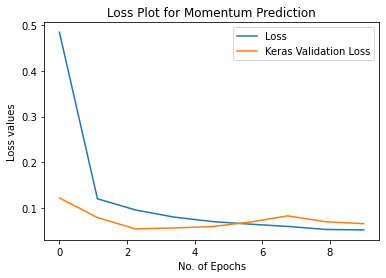

In [123]:
# Need to change this dependent on number of epochs, or else code wont run
epochs = np.linspace(0,9,9)
plt.xlabel("No. of Epochs")
plt.ylabel("Loss values")
plt.title("Loss Plot for Momentum Prediction")
plt.plot(epochs,reg_fit.history['loss'], label = 'Loss')
plt.plot(epochs,reg_fit.history['val_loss'], label = 'Keras Validation Loss')
plt.legend()
plt.show()

Curiously the loss flatlined, this is most likely due to the use of our log loss, which will not give it particularly good representations of our loss changing at lower values, but considering that initially our loss values were really high when using mean squared error (in the millions/hundreds of thousands), this is a preferable alternative.

Now to test if this model is any good at predicting electron momenta, we'll collect the electron data from the testing dataset and apply this model to it:

In [132]:
# Load model, to avoid runtime when marking. This file (if not in the main directory) is in the TASK1 directory
reg_mod = load_model('regression_mom_model.h5')

In [133]:
# Calling the above function, with usage of 11. for electron, and 1 for the [1] element in truth_train (momentum)
e_mom_truth_test, e_mom_image_test = particle_test_data_vals(11., 1)
# Converting the list of momenta to an array
y_mom_truth_test = np.array(e_mom_truth_test)

In [134]:
# More prints just for curiosity
print(y_mom_truth_test.shape)
print(e_mom_image_test.shape)

# Making a prediction of the values for these momenta. Will compare with the true values
reg_mod_pred = reg_mod.predict(e_mom_image_test)

(8079,)
(8079, 196608)


C:\Users\John\anaconda3\envs\daml\lib\site-packages\tensorflow\python\keras\engine\training.py:2458: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


These values are hard to directly compare to our true values, as they're float. We'll take these values away from the true values and compile a list with the differences between the true and the predicted values. We'll then create a histogram of these differences to see how far off we were.

[ True]
8079
8079 8079


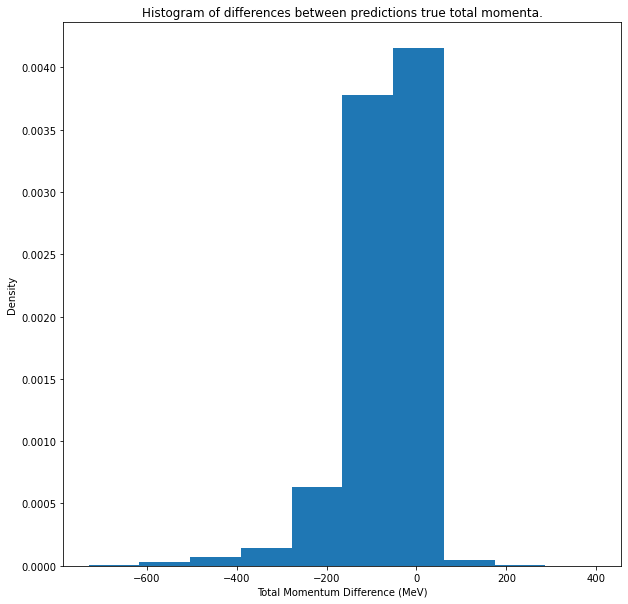

In [204]:
# Take away each element from one another in the list
reg_differences = np.array([(reg_mod_pred[i]-e_mom_truth_test[i]) for i in range(len(reg_mod_pred))])


# Sanity check, look at certain element in reg_differences, compare to the values from the two arrays
print(reg_differences[20] == (reg_mod_pred[20]-e_mom_truth_test[20]))
# Works as expected, prints True

# Also look at length to double check that it matches the expected length
print(len(reg_differences))
print(len(reg_mod_pred), len(e_mom_truth_test))



# Plot histogram
plt.figure(figsize=(10,10))
plt.hist(reg_differences, density = True)
plt.xlabel("Total Momentum Difference (MeV)")
plt.ylabel("Density")
plt.title("Histogram of differences between predictions true total momenta.")
plt.show()

Based on this graph (and the order of which we determine the difference). The predictions are relatively accurate, with more than have the predictions coming within 200MeV of the True value (and falling off significantly beyond that). The negative preference in our values demonstrate (due to the difference being 'predicted - true') that our predicted values are generally lower than the true values for our electrons. If we use more bins we may get a better result:

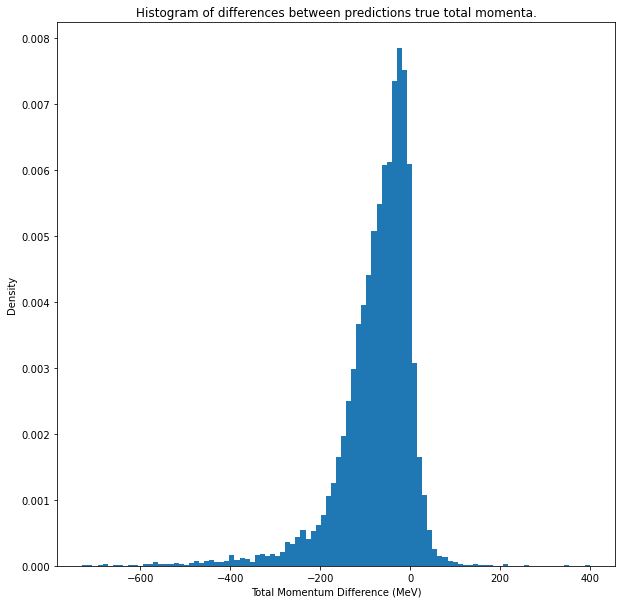

In [136]:
# Plot histogram
plt.figure(figsize=(10,10))
plt.hist(reg_differences, density = True, bins = 100)
plt.xlabel("Total Momentum Difference (MeV)")
plt.ylabel("Density")
plt.title("Histogram of differences between predictions true total momenta.")
plt.savefig("Histogram_differences_total_momenta_predict.pdf")
plt.savefig("Histogram_differences_total_momenta_predict.png")
plt.show()

Here the issue is even more apparent, its clear that we're underestimating a significant amount of our particles total momenta. I would assume this is because at low momenta, the electrons all look relatively similar (little to no electron showers/jets, as shown in the minimum plots in task 0), but with the median plot showing a significant electron shower at approximately 400MeV, its safe to assume that at this point it can predict the total momenta relatively well.

It's clear at the very least that it isn't overestimating the momenta in many if any cases, which is why I believe this low momenta issue occurs. It could be the case that the particle is predicting a 700MeV electron to be a 500MeV electron, but I consider this highly unlikely, but worth investigation.

I would assume once again that to further improve this fit, it would be wise to remove electrons with total momenta below 100MeV or so. While this may be true, I feel like this would beat the purpose of trying to guess the total momenta of the electrons, if we only select electrons of a very specific range. The model can just get particularly good within that range, but would therefore require the data it's predicting for to be within that specific range, which beats the purpose of the model in my opinion.

Quickly, lets look at the cases for which we get a momentum difference of -200MeV and above:

In [208]:
# A function that collects the true and predicted mean momenta of our dataset/model where the difference was larger than 200MeV

def predict_mean(reg_differences, prediction_momenta, true_momenta):
    # Collect indices of particles with a predicted difference of 200MeV or more
    prediction_indices = [i for i in range(len(reg_differences)) if (np.abs(reg_differences[i]) > 200)]

    # Collect the true and predicted total momenta for these indices
    true_mom_vals = [(prediction_momenta[prediction_indices[i]], true_momenta[prediction_indices[i]]) for i in range(len(prediction_indices)) ]

    # Plot some elements
    #print(np.array(true_mom_vals[:5], dtype=float))

    #Plot the average for each tuple (predicted on the left, true on the right)
    # This is crude, but this is crude analysis. So I think its okay.
    total_pred = 0
    total_true = 0
    for i in range(len(true_mom_vals)):
        # Add up all the elements
        total_pred += true_mom_vals[i][0]
        total_true += true_mom_vals[i][1]

        # Find mean by taking sum.
        total_pred_mean = float(total_pred) / len(true_mom_vals)
        total_true_mean = total_true / len(true_mom_vals)

    print("Predicted Mean of particles with larger than 200MeV difference: {:.2f} MeV\nTrue Mean for said particles: {:.2f} MeV".format(total_pred_mean, total_true_mean))

    
predict_mean(reg_differences, reg_mod_pred, e_mom_truth_test)

Predicted Mean of particles with larger than 200MeV difference: 349.52 MeV
True Mean for said particles: 647.88 MeV


This shows us here that our values are actually much larger than we expected. It seems that the errors in our predictions are mostly made when the electrons have median or higher energy, and we predict them to have significantly less energy.

It's possible that the reasoning for this is that our particles at these energies are quite energetic and appear 'relatively ' random and chaotic, due to the jets and showers at these energies being significant in the data. These results may be hard for our model to parse through and understand. This goes to show how important it is to investigate further, as my initial assumption that the lower mass particles were the issue was wrong! 

Just to further summarise how 'accurate' this model is, I'll create a simple function that determines how many of the particles were guessed to be within a certain momentum of the true value.

In [178]:
def momentum_accuracy(reg_differences, difference):
    
    # Collect the total length
    total_length = len(reg_differences)
    
    # Normalise the difference so that you can apply inequality fairly around 0
    reg_differences = np.abs(reg_differences)
    
    # Pass through the list checking how many values were within the above defined 'difference' space
    threshold = len([i for i in range(total_length) if (reg_differences[i] < difference)])
    
    # Printing the important values
    print("{}/{} values predicted within {} MeV of true value".format(threshold, total_length, difference))
    percentage = (threshold/total_length)*100
    print("{:.2f}% of particles predicted within {} MeV of true value".format(percentage, difference))

In [183]:
# This gives us a good gauge for how accurate our predictions are and to what degree.
momentum_accuracy(reg_differences, 200)
print("")
momentum_accuracy(reg_differences, 100)
print("")
momentum_accuracy(reg_differences, 50)
print("")
momentum_accuracy(reg_differences, 10)

7564/8079 values predicted within 200 MeV of true value
93.63% of particles predicted within 200 MeV of true value

5853/8079 values predicted within 100 MeV of true value
72.45% of particles predicted within 100 MeV of true value

3660/8079 values predicted within 50 MeV of true value
45.30% of particles predicted within 50 MeV of true value

901/8079 values predicted within 10 MeV of true value
11.15% of particles predicted within 10 MeV of true value


So as we can see from above. 93.63% of our particles are prediced to be within 200 MeV of their true value. This isn't a particularly greate value, and it drops significantly the smaller the range you give it (only 11.15% are within 10 MeV of their true value). This isn't a terrible model though, as we can see the distribution around 0 MeV for the differences quite cleary. I believe that (just like the Task 1 model) it would be further improved by the addition of more convolutional layers and nodes/filters within said CLs.

Next, we'll look at the last part which asks us to apply this model on photons. Just by looking at the graphs in task 0, I'd assume that the predictions will be decent here, due to the similarities between the photons and electrons across multiple energies. We wont know if this is true until we try it!

In [199]:
# Calling the above function, with usage of 22. for photon, and 1 for the [1] element in truth_train (momentum)
ph_mom_truth_test, ph_mom_image_test = particle_test_data_vals(22., 1)
# Converting the list of momenta to an array
phy_mom_truth_test = np.array(ph_mom_truth_test)

In [200]:
# Making a prediction of the values for these momenta. Will compare with the true values
ph_reg_mod_pred = reg_mod.predict(ph_mom_image_test)

In [201]:
# Take away each element from one another in the list to produce the difference
ph_reg_differences = np.array([(ph_reg_mod_pred[i]-phy_mom_truth_test[i]) for i in range(len(ph_reg_mod_pred))])

Okay, now lets plot the histogram:

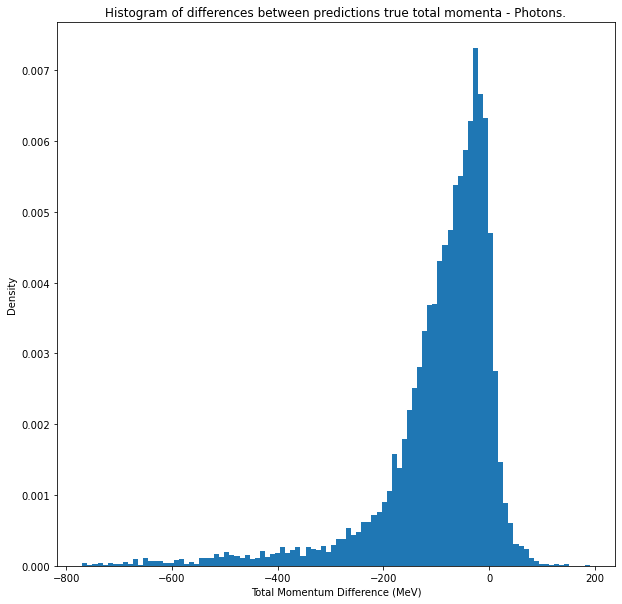

In [202]:
# Plot histogram
plt.figure(figsize=(10,10))
plt.hist(ph_reg_differences, density = True, bins = 100)
plt.xlabel("Total Momentum Difference (MeV)")
plt.ylabel("Density")
plt.title("Histogram of differences between predictions true total momenta - Photons.")
plt.savefig("ph_Histogram_differences_total_momenta_predict.pdf")
plt.savefig("ph_Histogram_differences_total_momenta_predict.png")
plt.show()

The differences look very similar to the electron histogram. Although the negative tail is further exacerbated here which demonstrates that for our photons our model is once again predicting that the particles are lower energy than they actually are.

Lets do some further anaylsis, looking at the mean particle momenta for cases were the difference was larger than 200, as is shown above:

In [209]:
predict_mean(ph_reg_differences, ph_reg_mod_pred, phy_mom_truth_test)

Predicted Mean of particles with larger than 200MeV difference: 272.26 MeV
True Mean for said particles: 619.61 MeV


Comparing this to the earlier result for electrons:

In [210]:
predict_mean(reg_differences, reg_mod_pred, e_mom_truth_test)

Predicted Mean of particles with larger than 200MeV difference: 349.52 MeV
True Mean for said particles: 647.88 MeV


We can see that the particles on average are predicted to have even lower total momenta values when compared to their true values. This is clear from the histogram, were the tail extends all to way to near -800, implying that some particles are assumed to have almost no momenta when they have almost the maximum possible momenta (The range for photon momenta was 35 MeV -> 799.95 MeV).

In these cases, I would assume (as I did in my previous analysis of the electron results) that the model isn't particularly good at predicting larger momenta results due to the EM shower produces by these particles, which can appear quite random and hard to 'categorise'.

We'll apply the same analysis as we did for the electron data here to see many particles are predicted accurately within certain MeV ranges:

In [211]:
# This gives us a good gauge for how accurate our predictions are and to what degree.
momentum_accuracy(ph_reg_differences, 200)
print("")
momentum_accuracy(ph_reg_differences, 100)
print("")
momentum_accuracy(ph_reg_differences, 50)
print("")
momentum_accuracy(ph_reg_differences, 10)

7167/8023 values predicted within 200 MeV of true value
89.33% of particles predicted within 200 MeV of true value

5335/8023 values predicted within 100 MeV of true value
66.50% of particles predicted within 100 MeV of true value

3320/8023 values predicted within 50 MeV of true value
41.38% of particles predicted within 50 MeV of true value

829/8023 values predicted within 10 MeV of true value
10.33% of particles predicted within 10 MeV of true value


Comparing it to our electron results, it is able to predict:
* 4.3% less particles accurately to within 200 MeV of the true value,
* 5.95% less particles within 100 MeV of the true value,
* 3.92% less particles within 50 MeV of the true value,
* 0.82% less particles within 10 MeV of the true value.

This is interesting, as within the 10 MeV range is predicts a similar number of particles accurately. This may be showing us that for the certain particle 'shapes' that it *can* predict well, they are similar across both data types (photons and electrons). Let us take a look at the best 3 or so particles predicted by each model, as well as the 3 worst:

In [296]:
# Take the best/worst 3 particles predicted for photon and electron dataset, and then print the particles

def print_best_worst(reg_differences):
    # Currently formatted oddly, one array element with the full array within, fixed by concatenation
    cc_reg_dif = np.concatenate(reg_differences)

    # Collect the absolute difference
    abs_reg_differences = np.abs(cc_reg_dif)

    # Collect the indices for smallest...
    low = np.argsort(abs_reg_differences)
    # ...and largest
    hi = np.argsort(-abs_reg_differences)
    
    # Printing the smallest and largest differences just for proof of functionality
    print("Lowest momentum difference: {:.4f}\nHighest momentum difference: {:.4f}".format(float(reg_differences[low[0]]),float(reg_differences[hi[0]])))
    
    # return best 3
    return low[:3], hi[:3]

# Collect lowest and highest for electron data and photon data
print("Electrons:")
e_low, e_hi = print_best_worst(reg_differences)
print("")
print("Photons:")
ph_low, ph_hi = print_best_worst(ph_reg_differences)


Electrons:
Lowest momentum difference: 0.0018
Highest momentum difference: -729.3597

Photons:
Lowest momentum difference: 0.0087
Highest momentum difference: -769.5720


Now lets print these particles and see if we can ascertain any similarities/characteristics that would help explain the ability for our model to identify some and not other particles based on momenta.

In [297]:
def plot_hi_low(e_low, e_hi, label, images):
    # Plotting low using Guillermo's code
    print("=============================================")
    print("============= LOW DIFFERENCE ================")
    print("=============================================")

    for k in range(len(e_low)):
        labels=["X-Y","Y-Z","Z-X"]
        ilist= toimage(images[e_low[k]])
        fig = plt.figure(figsize=(30,10))

        for index, image in enumerate(ilist):

            plt.subplot(1,3,index+1)
            #Show the image with imshow:
            plt.imshow(image, interpolation='none',cmap='jet')
            plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
            plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
            plt.title("Small difference " + label + " " + str(k) + " " + str(labels[index]), fontsize = 20)

    plt.show()


    # Plotting high using Guillermo's code
    print("=============================================")
    print("============= HIGH DIFFERENCE ===============")
    print("=============================================")

    for k in range(len(e_hi)):
        labels=["X-Y","Y-Z","Z-X"]
        ilist= toimage(images[e_hi[k]])
        fig = plt.figure(figsize=(30,10))

        for index, image in enumerate(ilist):

            plt.subplot(1,3,index+1)
            #Show the image with imshow:
            plt.imshow(image, interpolation='none',cmap='jet')
            plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
            plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
            plt.title("Large difference " + label + " " + str(k) + " " + str(labels[index]), fontsize = 20)

    plt.show()
    


============= LOW DIFFERENCE ================


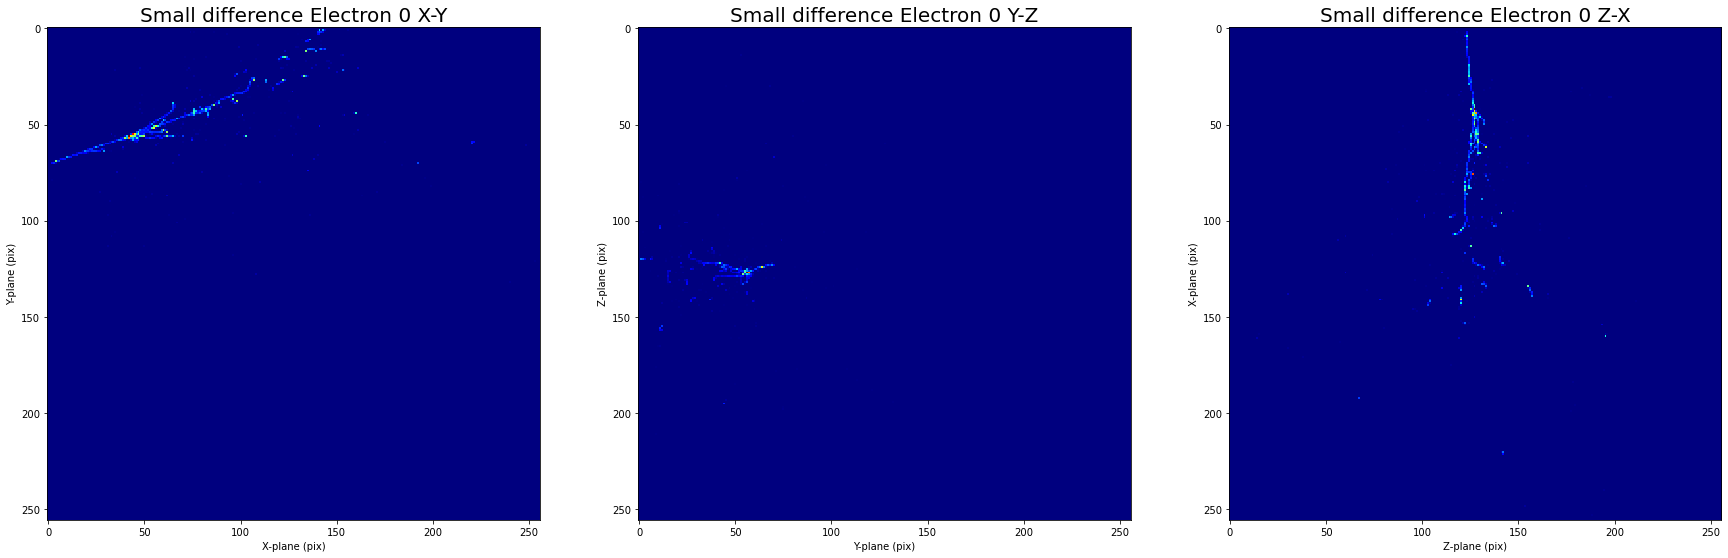

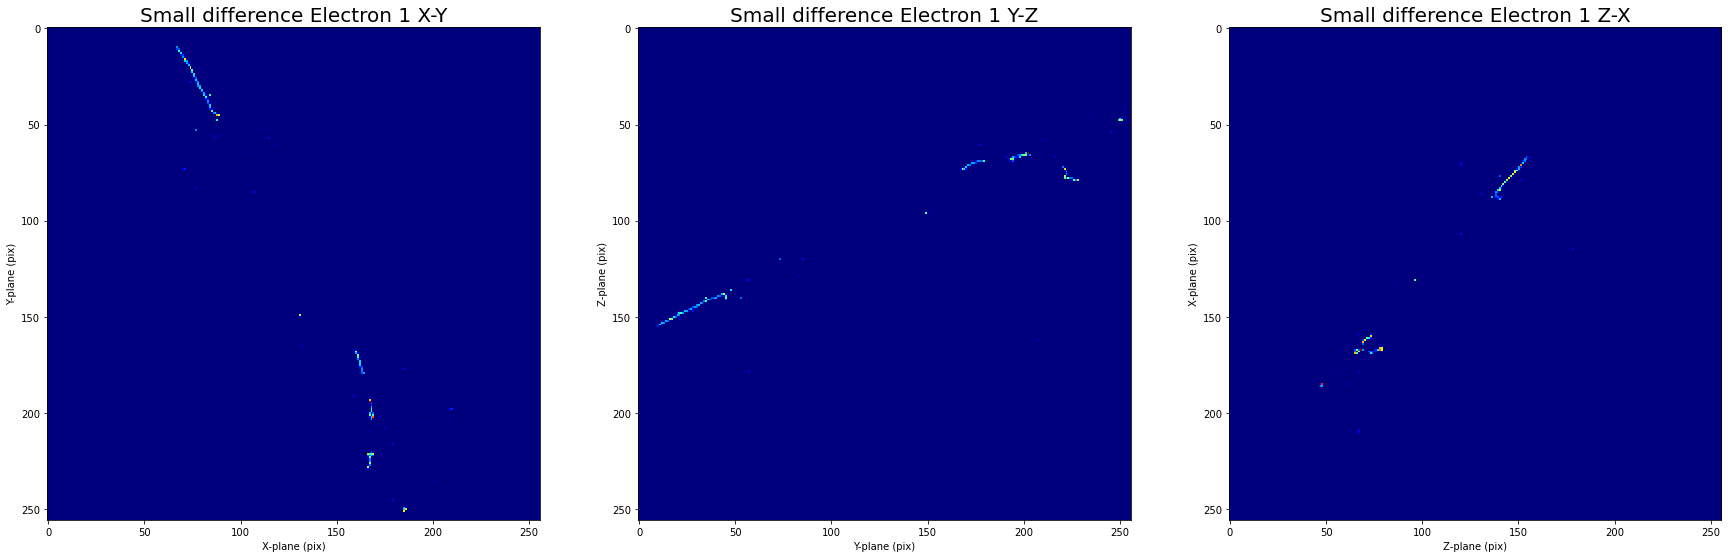

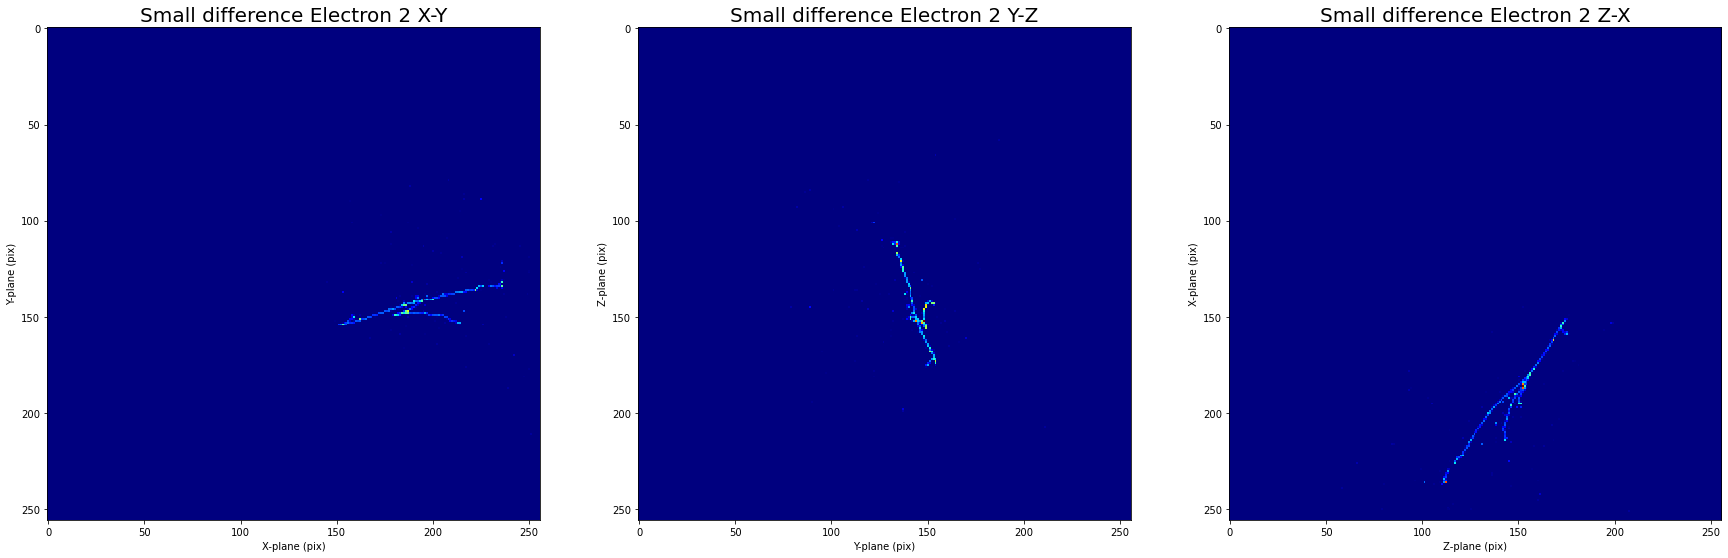

============= HIGH DIFFERENCE ===============


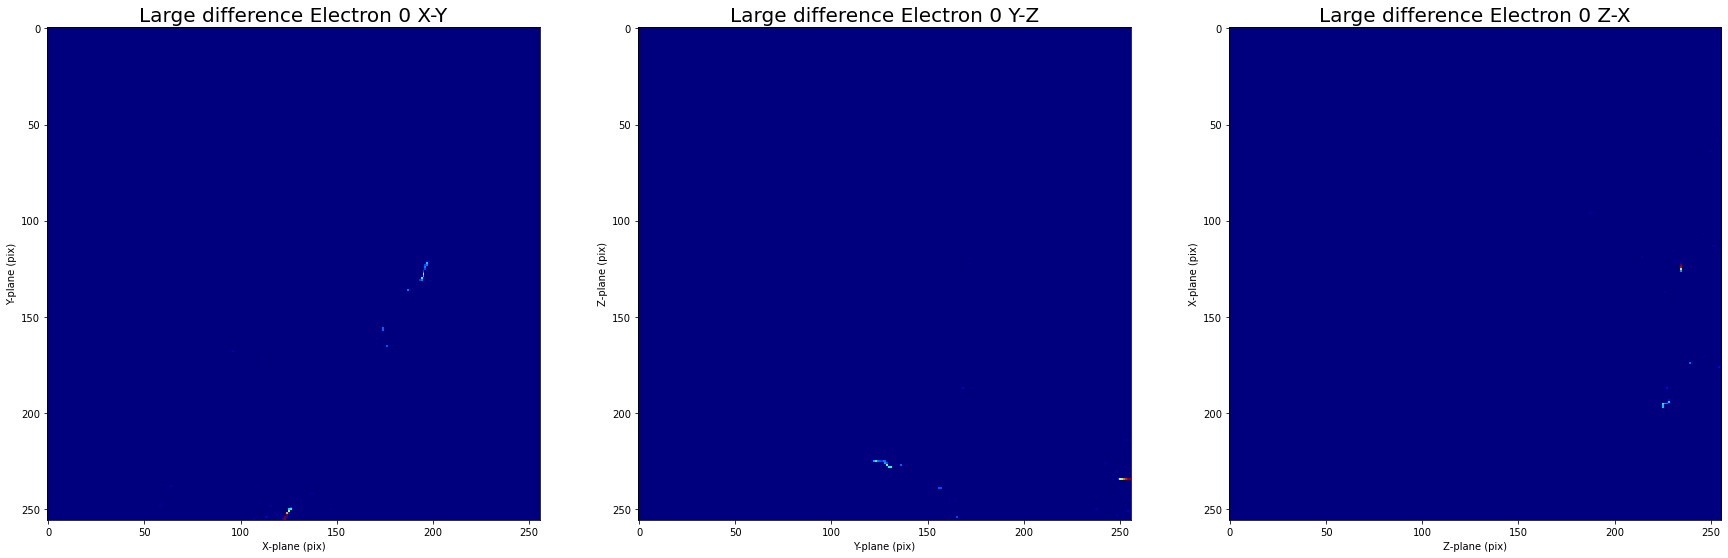

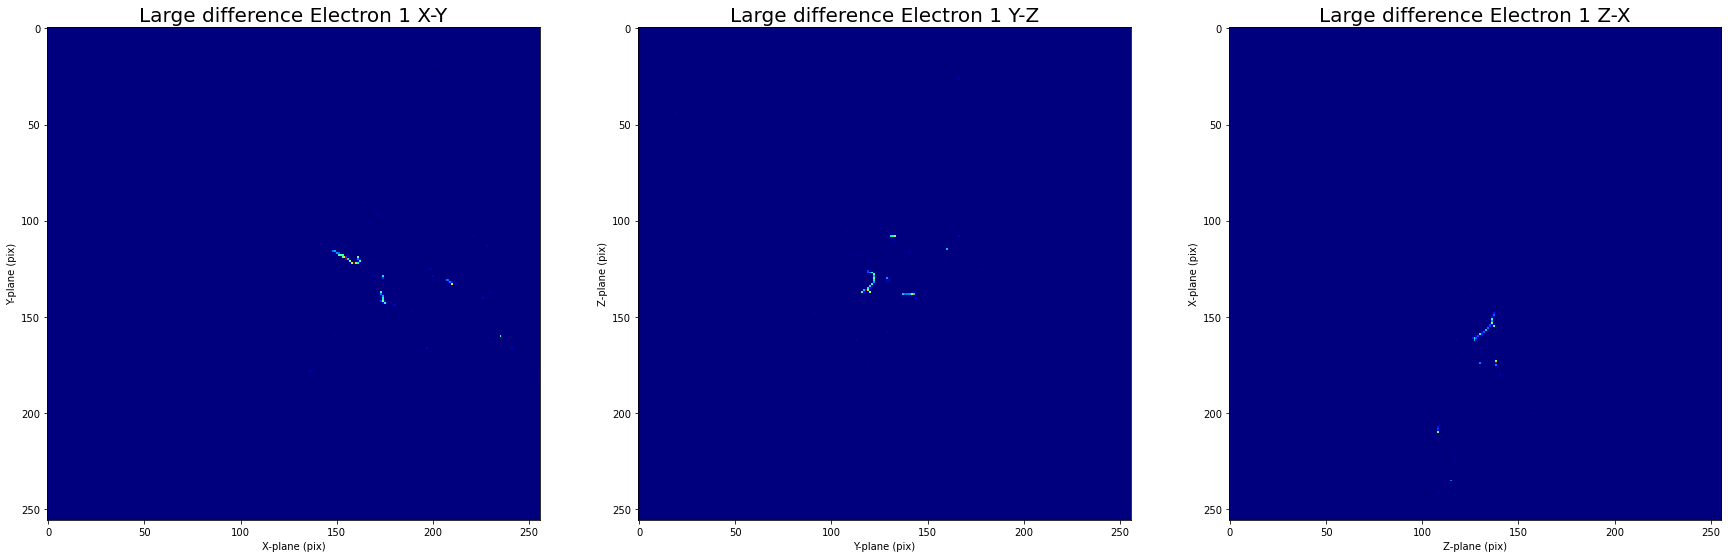

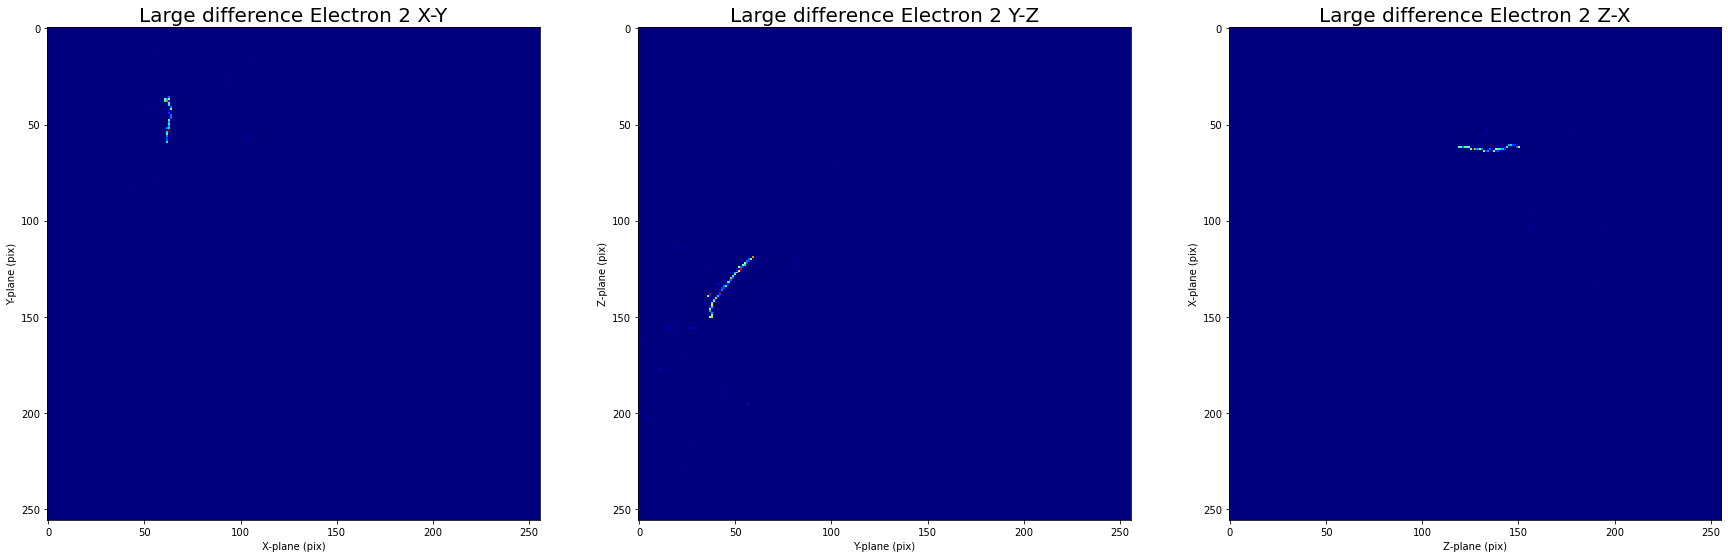

============= LOW DIFFERENCE ================


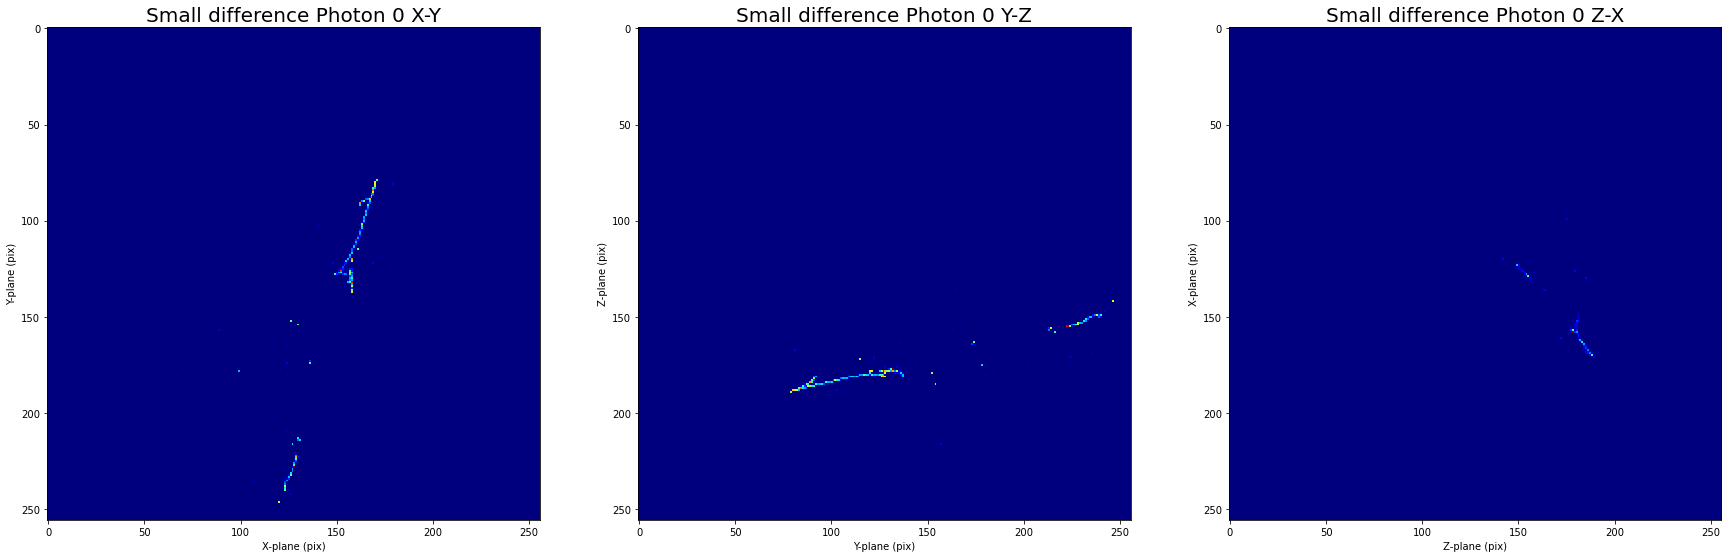

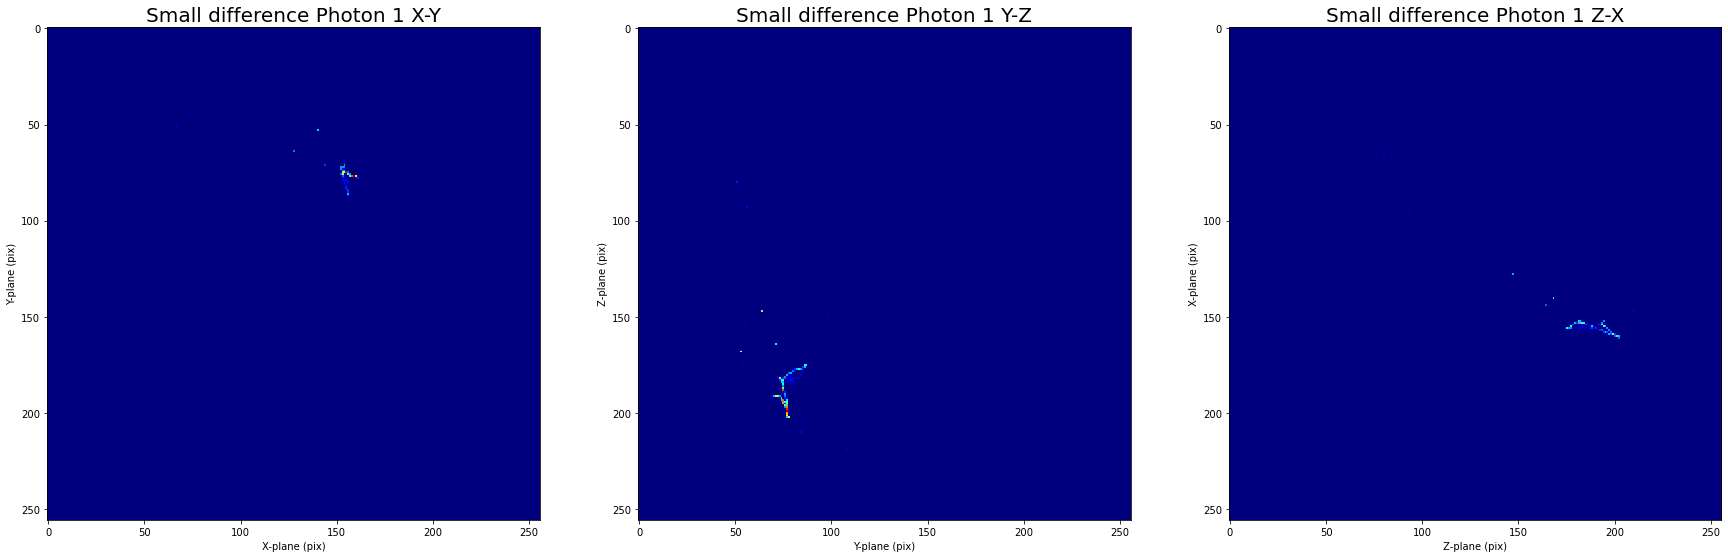

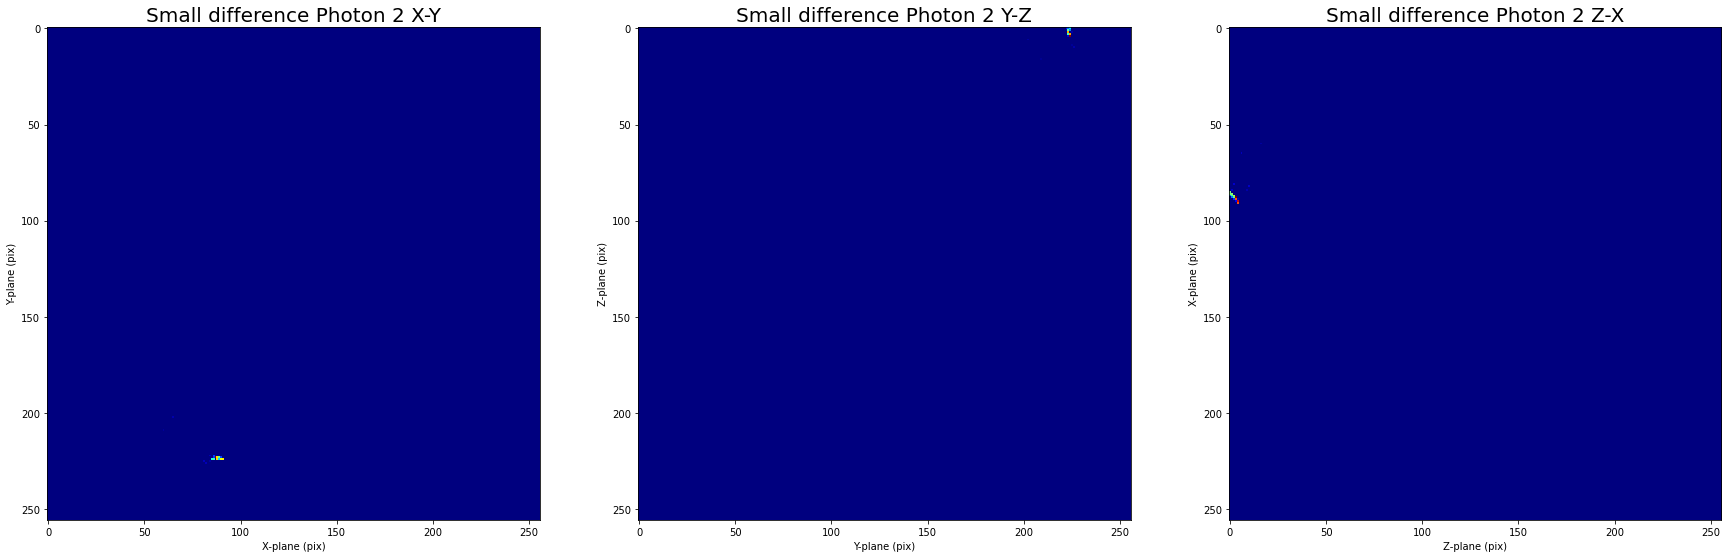

============= HIGH DIFFERENCE ===============


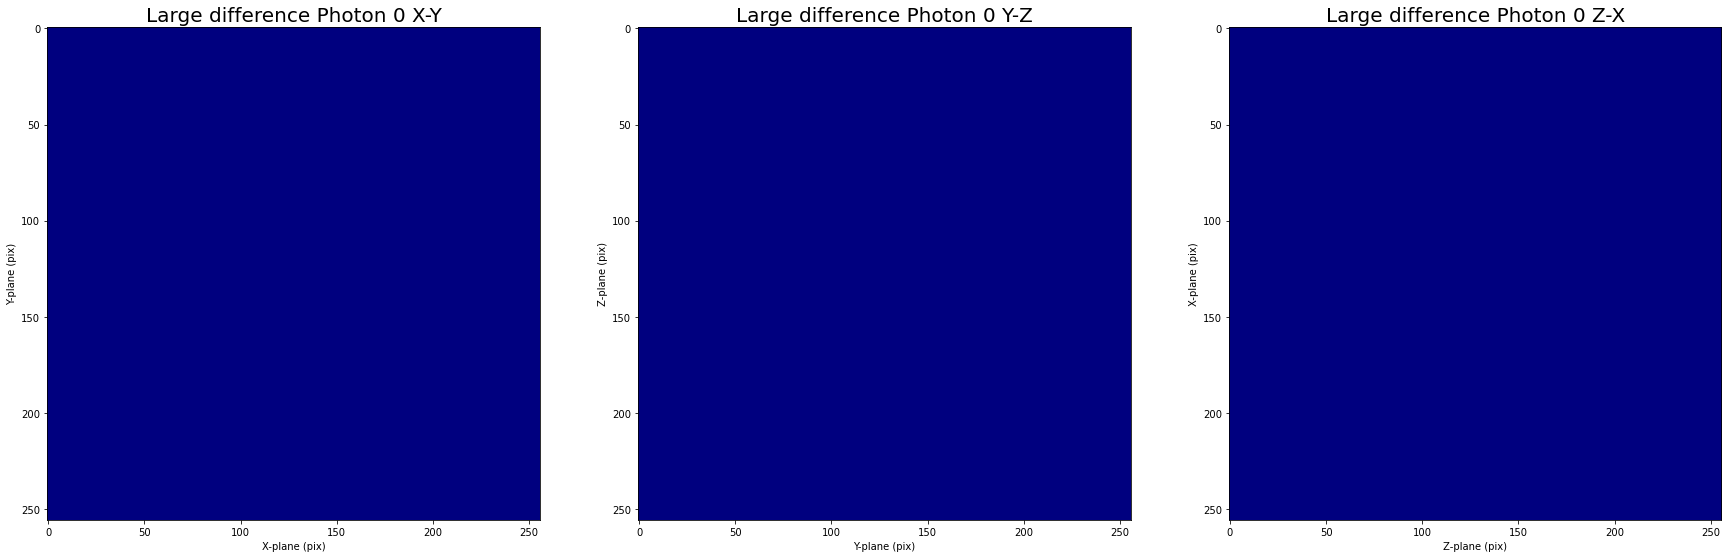

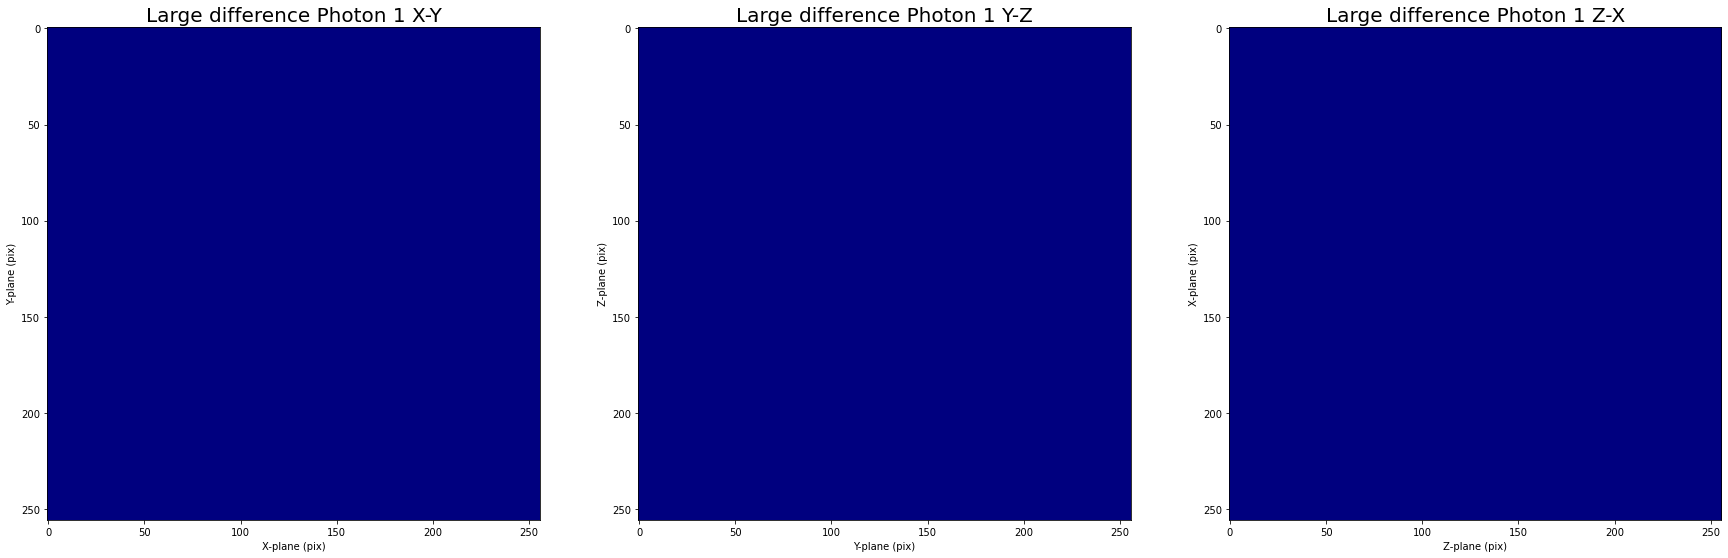

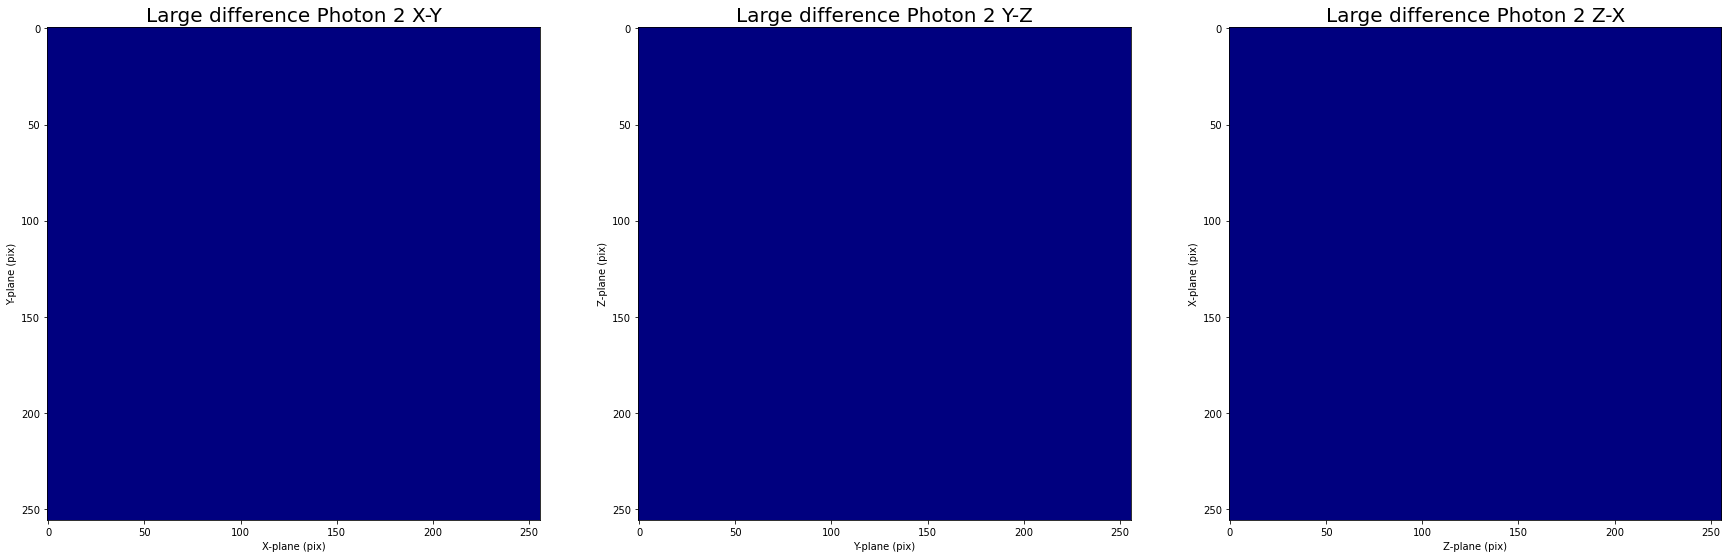

In [299]:
plot_hi_low(e_low, e_hi, "Electron", e_mom_image_test)
plot_hi_low(ph_low, ph_hi, "Photon", ph_mom_image_test)

*If these graphs arent plotted or the model had to be re-run and gave different results, the original images discussed are in the folder /TASK 2/ and labelled 'PARTICLE Difference images*

For the electrons, its clear that the largest differences come from values within our dataset that have very random patterns on the screen, rather than the expected 'jet-like' distribution that is most commonly predicted by our model.

For the photons however, its a rather different story, the small difference images vary quite largely, from almost no signal being shown to very large jets being shown as well. Whats curious here is that our photon images with the largest differences appear to have no data in them whatsoever. 

This would explain why the momentum difference is so large, It's expecting a very small difference in momentum due to the lack of image, but the momentum value saved is actually very large! Is this due to photons being 'detected' but not producing any particles that hold electric charge? 

This is a very strange result indeed, but explains why our photons results are significantly worse. Electrons always carry charge, so its understandable that the image always contains data, but if the photons are counted as being 'detected' even though they give off no charged particles, how can their momenta be determined? I understand that photons can carry no charge and so wouldn't be shown through charge being propogated through the argon chamber, but how does that allow the system to determine its momenta? 

This may be an error either in my own code, or in the data sample given, or it may just be that the photon momenta is determined another way beforehand, but I don't have the time to investigate it any further.

Total Momenta of the Photon: 
[-769.57196]


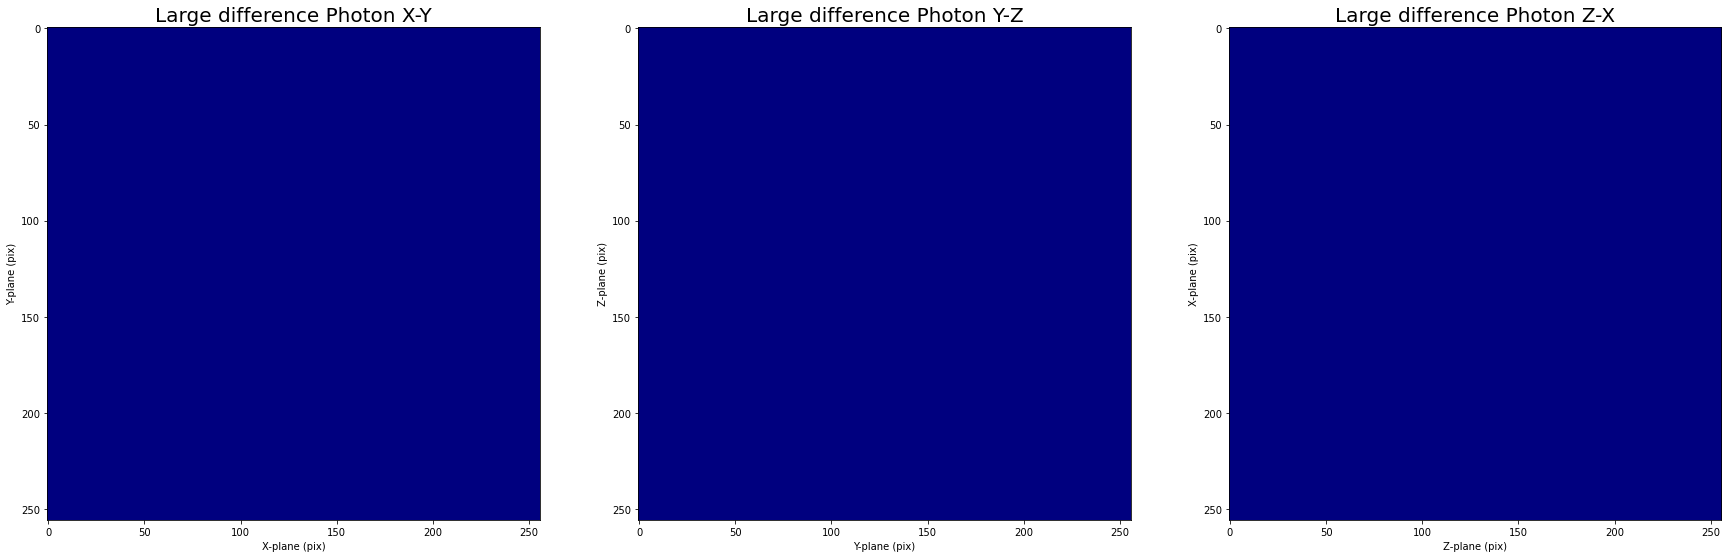

In [303]:
# The first plotted image, just to double check that I'm not plotting it incorrectly.
print("Total Momenta of the Photon: ")
print(ph_reg_differences[ph_hi[0]])



labels=["X-Y","Y-Z","Z-X"]
ilist= toimage(ph_mom_image_test[ph_hi[0]])
fig = plt.figure(figsize=(30,10))

for index, image in enumerate(ilist):

    plt.subplot(1,3,index+1)
    #Show the image with imshow:
    plt.imshow(image, interpolation='none',cmap='jet')
    plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
    plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
    plt.title("Large difference Photon " + str(labels[index]), fontsize = 20)

plt.show()

## Task 2 Conclusion

So the task was:

* Create a regression algorithm which predicts the particle momentum for electrons. Determine the quality of the regression trained on electrons on photons. Explain the performace.

From the analysis above, its clear that the regression algorithm works for predicting electron total momenta. The accuracy it ascertains isn't particularly astounding, and its clear there is some bias in the training that causes it to underpredict the momenta significantly, but it can predict 72.45% of the particles to within 100 MeV of their true value. Considering the amount of 'free parameters' in the data (particle position, the variability of the EM showers/jets) this isn't a particularly bad result for the data it was trained on.

For photons however, the model performs slightly worse, only predicting 66.50% of the particles to within 100 MeV of their true total momenta values. At the extreme cases for which the model predicts low momenta but the particle ID claims that the particle has high momenta, it appears that the data is unreliable for photons, either due to their lack of charge or there having been some mistake in the analysis. This may explain why the model struggles more with predicting photons when compared to the electron data that it was modelled on as this does not seem to occur in the electron data, even in the extreme cases (as was shown above).

In conclusion, I'd say that the model does a *decent* enough job of predicting photon momenta considering the small scale of the model and the exceptional data it sometimes has to predict (compared to electrons). This model shows that the general framework for said model functions as expected (we have a distribution for our predictions around the true value of total momenta) and that if scaled up to allow for more computationally heavy models of a similar structure (increased convolutional layers & more nodes/filters) we would most likely be able to improve the results significantly.


*Thank you for reading this all, I apologise for making it so long but I felt that there was a lot to analyse and discuss!*

*If anything breaks (without any clear fault; for example, conflicting tensorflow versions can sometimes just break the code on difference computers) feel free to email me @ s1739002@ed.ac.uk and I can give over any relevant information that would get the code up and running again.*


# GRAVEYARD OF IDEAS

Down here is all the code for different methods and ideas I had.
It's mostly inconsistent, and I'm sure none of it works, but I'm leaving it here in case I want to take a method I built earlier and reimplement it somewhere else (hopefully with it working this time!)

In [304]:
# THIS SECTION WAS THE INITIAL, ONE ITERATION OF THE ABOVE CODE, WILL BE REMOVED BEFORE SUBMISSION

## Changes in initial momenta, and they're effect on the particles.
## Take 3 examples from each particle at differing momenta 
## (find highest momenta, lowest and then a centre value) and plot with each other.
## will be considering total initial momenta (truth[0][1])
#
#    # Trial for electron specifically
#    # take list of all electrons
#e_ind_list = [i for i in range(len(part_ids)) if part_ids[i] == 11.0]
#    # collect their momenta in a list
#e_mom_list = [item[1] for item in truth[e_ind_list]]
#    # find the maximum/minimum and approximate median momenta index
#e_max_val = np.argmax(e_mom_list)
#e_min_val = np.argmin(e_mom_list)
#e_med_val = np.argsort(e_mom_list)[len(e_mom_list)//2]

#print(e_max_val, e_mom_list[e_max_val], e_min_val, e_mom_list[e_min_val], e_rnd_val, e_mom_list[e_rnd_val])
## Plot images for min, median and max.
#indexes = [e_min_val, e_med_val, e_max_val]
#titles = ['Minimum', 'Median', 'Maximum']
#for q in range(len(indexes)):    
#    ilist= toimage(images[indexes[q]])
#    fig = plt.figure(figsize=(30,10))
#
#    for index, image in enumerate(ilist):
#
#        plt.subplot(1,3,index+1)
#        #Show the image with imshow:
#        plt.imshow(image, interpolation='none',cmap='jet')
#        plt.xlabel('{}-plane (pix)'.format(labels[index].split("-")[0]))
#        plt.ylabel('{}-plane (pix)'.format(labels[index].split("-")[1]))
#        plt.title(titles[q] + " momenta " + str(labels[index]), fontsize = 20)
#        
#plt.show()

In [135]:
# Modifying the previous code for keras tuner
def kt_mod_builder(hp):
    # Allows for hyperparameter searching by using new syntax to create easier model building and modification
    # data_shape -> initial data shape, will be rezised to (256, 256, 3)
    # n_conv_layers -> number of convolutional layers, this includes max pooling
    # conv_starting_nodes -> the starting number for our Conv2D filters
    # n_hidden_layers -> number of hidden layers
    # noders_per_hidden_layer -> number of nodes per hidden layer
    
    
    # Creating the filters for convolutional layers
    # Determine the number of starting nodes
    hp_starting_filters = hp.Int('starting_filters', min_value = 4, max_value = 16, step = 4)
    # Determine the number of convolutional layers
    hp_n_conv_layers = hp.Int('conv_layers', min_value = 1, max_value = 4, step = 1)
    sequence = hp_starting_filters
    n = hp_n_conv_layers
    conv_list = []
    while(n):
        conv_list.append(sequence)
        sequence*=2
        n-=1
    print(conv_list)
    # Creating the model
    
    # need to insert data shape directly for keras tuner to work 
    data_shape = (196608,)
    
    model = Sequential()
    model.add(Reshape((256, 256, 3), input_shape=(data_shape)))
    
    # Initial layer
    model.add(Conv2D(conv_list[0], kernel_size = 3, strides = 2, activation = 'relu'))
    model.add(Conv2D(conv_list[0], kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    
              
    # Creating a loop for number of convolutional layers, going up in 8->16->32->64
    # First layer already applied, due to extra stride. Hence the -1 and +1
    for i in range(hp_n_conv_layers-1):
        model.add(Conv2D(conv_list[i+1], kernel_size = 3, padding='same', activation = 'relu'))
        model.add(Conv2D(conv_list[i+1], kernel_size = 3, padding='same', activation = 'relu'))
        model.add(MaxPooling2D(pool_size = (2,2)))
    
    # Then flatten
    model.add(Flatten())
    
    # Then hidden layers, choose for hyperparameterisation
    hp_dense_layers = hp.Int('dense_layers', min_value = 1, max_value = 4, step = 1)
    for j in range(hp_dense_layers):
        model.add(Dense(hp.Int('dense_layer_nodes_' + str(j), min_value = 5, max_value = 50, step = 5),
                        activation = 'relu'))
    # Resulting output
    model.add(Dense(5, activation = 'softmax'))
              
    # compile and output
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
    
    return model

In [136]:
tuner = RandomSearch(
    kt_mod_builder,
    objective = 'val_accuracy',
    max_trials = 5,
    executions_per_trial = 3,
)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
[4]


In [137]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
starting_filters (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 16, 'step': 4, 'sampling': None}
conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
dense_layer_nodes_0 (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 50, 'step': 5, 'sampling': None}


In [138]:
tuner.search(nn_batch_generator(x_train_short[:-validation_slice], y_train_short[:-validation_slice], 
                                batch_size = batch_size) ,epochs = 5, steps_per_epoch = int((sample_size - validation_slice)/batch_size),
                             validation_data=(x_train_short[-validation_slice:], y_train_short[-validation_slice:]))


Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
starting_filters  |8                 |?                 
conv_layers       |1                 |?                 
dense_layers      |2                 |?                 
dense_layer_nod...|15                |?                 

[8]


RuntimeError: Model-building function did not return a valid Keras Model instance, found <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000011797918E08>

FIX THIS^^^^ USING THIS
https://www.analyticsvidhya.com/blog/2021/06/keras-tuner-auto-neural-network-architecture-selection/



In [ ]:
## MOVED INTO A FUNCTION

## Collect indices of particles with a predicted difference of 200MeV or more
#prediction_indices = [i for i in range(len(reg_differences)) if (np.abs(reg_differences[i]) > 200)]
#
## Collect the true and predicted total momenta for these indices
#true_mom_vals = [(reg_mod_pred[prediction_indices[i]], e_mom_truth_test[prediction_indices[i]]) for i in range(len(prediction_indices)) ]
#
## Plot some elements
##print(np.array(true_mom_vals[:5], dtype=float))
#
##Plot the average for each tuple (predicted on the left, true on the right)
## This is crude, but this is crude analysis. So I think its okay.
#total_pred = 0
#total_true = 0
#for i in range(len(true_mom_vals)):
#    # Add up all the elements
#    total_pred += true_mom_vals[i][0]
#    total_true += true_mom_vals[i][1]
#    
#    # Find mean by taking sum.
#    total_pred_mean = float(total_pred) / len(true_mom_vals)
#    total_true_mean = total_true / len(true_mom_vals)
#
#print("Predicted Mean of particles with larger than 200MeV difference: {:.2f}\nTrue Mean for said particles: {:.2f}".format(total_pred_mean, total_true_mean))
    
    

#### This was an excerpt from task 2, when I had different image results for my photons (as I had messed up the variable names by accident)


The graphs show plots for electrons which had large differences between the predicted and true total momenta, and small differences between the predicted and true total momenta.

From these graphs, I honestly can't determine any obvious visual characteristics that would explain why the model would be unable to predict accurately for some of these image but not others.

While my theory on the model having difficulty with high momenta models makes sense with some of these images (very messy jets within the data), some of the most inaccurate predictions are collected from low momenta particles (or particles that show small trails within the images). 

It appears that the reasoning for this to occur is that certain particles which by eye should have low momenta actually have incredibly high momenta. For example, the first 'Large Difference' photon plot appears to be a regular low momenta photon decay, but in fact (based on the printout from:

        print_best_worst(ph_reg_differences)

We can see that it actually has incredibly large momenta.